In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
# LOAD DỮ LIỆU TỪ 3 WEBSITE ĐÃ LÀM SẠCH

# Load dữ liệu đã làm sạch từ 3 website
try:
    df_alonhadat = pd.read_csv("Alonhadat_cleaned.csv")
    df_alonhadat['Source'] = 'Alonhadat'
    print(f"Alonhadat: {df_alonhadat.shape}")
except:
    print(" Không tìm thấy Alonhadat_cleaned.csv")

try:
    df_guland = pd.read_csv("Guland_cleaned.csv")  
    df_guland['Source'] = 'Guland'
    print(f"Guland: {df_guland.shape}")
except:
    print(" Không tìm thấy Guland_cleaned.csv")

try:
    df_nhatot = pd.read_csv("Nhatot_cleaned.csv")
    df_nhatot['Source'] = 'Nhatot'
    print(f"Nhatot: {df_nhatot.shape}")
except:
    print(" Không tìm thấy Nhatot_cleaned.csv")

Alonhadat: (2422, 26)
Guland: (172690, 41)
Nhatot: (4650, 29)


       Property_Type  Keyword_chính_chủ  Price       Price.1  \
0  Đất thổ cư, đất ở                  0    NaN  2.200000e+09   
1  Đất thổ cư, đất ở                  0    NaN  2.000000e+09   
2  Đất thổ cư, đất ở                  0    NaN  2.888000e+09   
3  Đất thổ cư, đất ở                  0    NaN  2.950000e+09   
4  Đất thổ cư, đất ở                  0    NaN  2.890000e+09   
5  Đất thổ cư, đất ở                  0    NaN  2.910000e+09   
6  Đất thổ cư, đất ở                  0    NaN  2.940000e+09   
7  Đất thổ cư, đất ở                  0    NaN  2.600000e+09   
8  Đất thổ cư, đất ở                  0    NaN  2.960000e+09   
9  Đất thổ cư, đất ở                  0    NaN  2.850000e+09   

                                               Title  Price_per_m2  \
0  NỢ NẶNG LÃI CẦN BÁN GẤP LÔ ĐẤT MẶT TIỀN GIÁ RẺ...  1.466667e+07   
1  2000TR/150M2, RẺ NHẤT THỊ TRƯỜNG, NGAY TRUNG T...  1.333333e+07   
2  888TR/150M2 GIA CÁT LƯỢNG MÀ BIẾT CHẮC CHẮN ĐỘ...  1.925333e+07   
3  TÔI CHỦ ĐẤT 

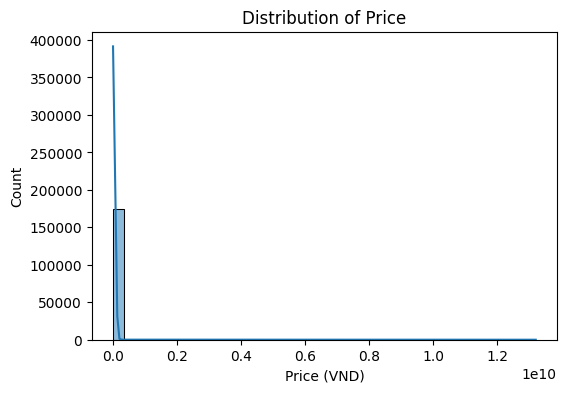

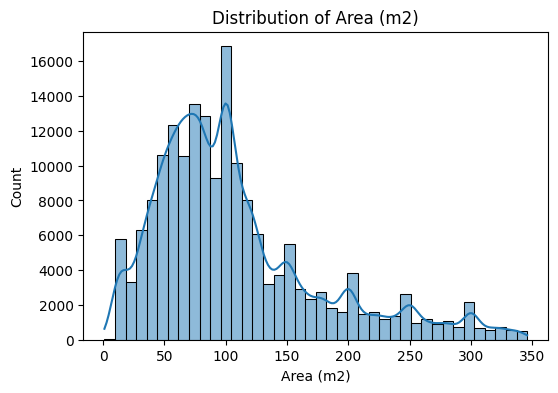

Source
Guland       172690
Nhatot         4650
Alonhadat      2422
Name: count, dtype: int64
Property_Type
Đất                               91933
Nhà riêng                         57519
Căn hộ chung cư                   19968
Nhà ở                              2207
Kho, nhà xưởng                     1681
Nhà mặt tiền                       1570
Nhà trọ                            1536
Căn hộ/Chung cư                     905
Phòng trọ                           593
Văn phòng, Mặt bằng kinh doanh      467
Đất thổ cư, đất ở                   427
Khách sạn                           403
Nhà trong hẻm                       313
Văn phòng                           154
Biệt thự, nhà liền kề                57
Nhà hàng, khách sạn                  21
Đất nền, liền kề, đất dự án           7
Phòng trọ, nhà trọ                    1
Name: count, dtype: int64
Loaded file, coerced numerics, and generated initial summaries and plots


In [3]:
# 1) Read CSV with provided encoding
file_path = './Combined_RealEstate.csv'
df_re = pd.read_csv(file_path, encoding='UTF-8-SIG')

# 2) Standardize column names (strip spaces, lower, replace special chars lightly)
df_re.columns = [c.strip() for c in df_re.columns]

# 3) Create lightweight views of key columns if present
candidate_cols = ['Price','Price_per_m2','Area','Area.1','Title_Length','Source','Property_Type','District',
                  'Keyword_sổ_hồng','Keyword_sổ_đỏ','Keyword_chính_chủ','Keyword_view_đẹp','Keyword_mặt_tiền','Keyword_giá_rẻ']
existing = [c for c in candidate_cols if c in df_re.columns]

# 4) Coerce numeric columns
num_cols = [c for c in existing if c not in ['Source','Property_Type','District']]
for c in num_cols:
    df_re[c] = pd.to_numeric(df_re[c], errors='coerce')

# Prefer Area.1 as numeric area if available, else Area
if 'Area.1' in df_re.columns:
    df_re['Area_m2'] = pd.to_numeric(df_re['Area.1'], errors='coerce')
elif 'Area' in df_re.columns:
    df_re['Area_m2'] = pd.to_numeric(df_re['Area'], errors='coerce')

# 5) Basic shape and missingness
shape_val = df_re.shape
missing_pct = df_re.isna().mean().sort_values(ascending=False).head(15)

# 6) Descriptive stats for a subset of numeric variables
numeric_for_desc = [c for c in ['Price','Price_per_m2','Area_m2','Title_Length'] if c in df_re.columns]
desc_stats = df_re[numeric_for_desc].describe(percentiles=[0.25,0.5,0.75]).T if len(numeric_for_desc)>0 else pd.DataFrame()

print(df_re.head(10))
print(desc_stats)
print(shape_val)
print(missing_pct)

# 7) Quick univariate visuals (price and area distributions if present)
plt.figure(figsize=(6,4))
if 'Price' in df_re.columns:
    sns.histplot(df_re['Price'].dropna(), bins=40, kde=True)
    plt.title('Distribution of Price')
    plt.xlabel('Price (VND)')
    plt.ylabel('Count')
    plt.show()

plt.figure(figsize=(6,4))
if 'Area_m2' in df_re.columns:
    sns.histplot(df_re['Area_m2'].dropna(), bins=40, kde=True)
    plt.title('Distribution of Area (m2)')
    plt.xlabel('Area (m2)')
    plt.ylabel('Count')
    plt.show()

# 8) Categorical breakdowns if present
if 'Source' in df_re.columns:
    source_counts = df_re['Source'].value_counts(dropna=False)
    print(source_counts)

if 'Property_Type' in df_re.columns:
    type_counts = df_re['Property_Type'].value_counts(dropna=False)
    print(type_counts)

print('Loaded file, coerced numerics, and generated initial summaries and plots')

In [4]:
# Ví dụ chuẩn hóa tên cột trước
df_alonhadat = df_alonhadat.rename(columns={
    "Giá": "Price",
    "Legal Status": "Legal_Status",
    "Property Type": "Property_Type",
})

df_guland = df_guland.rename(columns={
    "Price": "Price",
    "Property Type": "Property_Type",
    "Province": "Province"
})

df_nhatot = df_nhatot.rename(columns={
    "Price": "Price",
    "Legal_Status": "Legal_Status",
    "Category": "Property_Type",
})

In [57]:
# XÁC ĐỊNH BIẾN CHUNG VÀ BIẾN ĐẶC THÙ

def analyze_columns(dataframes):
    """Phân tích cột chung và đặc thù"""
    all_columns = set()
    for df in dataframes:
        all_columns.update(df.columns)
    
    common_columns = set(dataframes[0].columns)
    for df in dataframes[1:]:
        common_columns = common_columns.intersection(df.columns)
    
    specific_columns = {}
    for i, df in enumerate(dataframes):
        specific_columns[f"Website_{i+1}"] = set(df.columns) - common_columns
    
    return common_columns, specific_columns

# kiểm tra biến thực tế có tồn tại không
available_dfs = []
website_dfs = {
    'Alonhadat': 'df_alonhadat',
    'Guland': 'df_guland', 
    'Nhatot': 'df_nhatot'
}

print(" KIỂM TRA CÁC DATAFRAME ĐÃ TẠO:")

for website, df_name in website_dfs.items():
    if df_name in globals() and isinstance(globals()[df_name], pd.DataFrame):
        df = globals()[df_name]
        available_dfs.append(df)
        print(f" {website}: {df.shape}")
    else:
        print(f" {website}: Chưa có dataframe")

print(f"\n Tổng số dataframe có sẵn: {len(available_dfs)}")

# QUAN TRỌNG: XỬ LÝ common_cols TRƯỚC KHI SORTED
if len(available_dfs) == 0:
    print(" Không có dataframe nào để phân tích")
    common_cols = set()
    specific_cols = {}
    
elif len(available_dfs) == 1:
    # Chỉ có 1 website - dùng tất cả cột của website đó
    common_cols = set(available_dfs[0].columns)
    specific_cols = {list(website_dfs.keys())[0]: set()}
    print(" Chỉ có 1 website, sẽ dùng tất cả cột làm biến chung")
    
else:
    # Có từ 2 website trở lên
    common_cols, specific_cols = analyze_columns(available_dfs)
    print(" Đã phân tích biến chung và đặc thù")

# BÂY GIỜ MỚI XỬ LÝ SORTED VÀ LỌC (sau khi common_cols đã được định nghĩa)
if common_cols:  # Chỉ xử lý nếu common_cols tồn tại và không rỗng
    common_cols = sorted(common_cols)
    
    # Loại bỏ các biến bắt đầu bằng "Keyword_"
    common_cols = [col for col in common_cols if not col.startswith("Keyword_")]
    
    print("\n BIẾN CHUNG (dùng cho phân tích tổng hợp):")
    for i, col in enumerate(common_cols, 1):
        print(f"  {i:2d}. {col}")
    
    # Chỉ hiển thị specific_cols nếu có từ 2 website trở lên
    if len(available_dfs) >= 2 and specific_cols:
        print("\n BIẾN ĐẶC THÙ (dùng cho phân tích riêng):")
        for i, (website, cols) in enumerate(specific_cols.items()):
            if cols:
                website_name = list(website_dfs.keys())[i] if i < len(website_dfs) else f"Website_{i+1}"
                # Lọc bỏ các cột Keyword_ trong biến đặc thù
                filtered_cols = [col for col in sorted(cols) if not col.startswith("Keyword_")]
                if filtered_cols:
                    print(f"  {website_name}: {', '.join(filtered_cols)}")
                else:
                    print(f"  {website_name}: Không có biến đặc thù sau khi lọc")
            else:
                print(f"  {website_name}: Không có biến đặc thù")
else:
    print(" Không có biến chung nào")

# THÔNG BÁO TÌNH TRẠNG
if len(available_dfs) < 2:
    print(f"\n Cần ít nhất 2 website để phân tích tổng hợp (hiện có: {len(available_dfs)})")
    print("   Hãy đảm bảo bạn đã tạo các dataframe:")
    for website, df_name in website_dfs.items():
        if df_name not in globals() or not isinstance(globals().get(df_name), pd.DataFrame):
            print(f"   - {df_name} ({website})")
else:
    print(f"\n Đã sẵn sàng để gộp {len(available_dfs)} website!")

 KIỂM TRA CÁC DATAFRAME ĐÃ TẠO:
 Alonhadat: (2422, 26)
 Guland: (172690, 41)
 Nhatot: (4650, 29)

 Tổng số dataframe có sẵn: 3
 Đã phân tích biến chung và đặc thù

 BIẾN CHUNG (dùng cho phân tích tổng hợp):
   1. Area
   2. Area_clean
   3. District
   4. Price_clean
   5. Price_per_m2
   6. Price_raw
   7. Property_Type
   8. Source
   9. Title
  10. Title_Length

 BIẾN ĐẶC THÙ (dùng cho phân tích riêng):
  Alonhadat: Legal_Status, Location, Province, Street, Thumbnail src, URL, bedroom, brief, floors, road-width
  Guland: Agent Listing Count, Agent Name, Agent Role, Alley Width, Avatar, Bathrooms, Bedrooms, Description, Direction, Floors, Last Updated, Last Updated Date, Latitude, Length, Listing ID, Location, Longitude, Position, Property Type Slug, Province, Road Type, Scraped At, Street, VIP Account, Width
  Nhatot: City, Crawl_Date, Date_Posted, ID, Latitude, Legal_Status, Longitude, Poster_Type, Rooms, Toilets, Ward, source, url

 Đã sẵn sàng để gộp 3 website!


In [6]:
# CHUẨN HÓA TÊN CỘT CHUNG

# Định nghĩa mapping chuẩn hóa tên cột
column_standardization = {
    # Biến số lượng cốt lõi
    'Price_clean': 'Price',
    'Area_clean': 'Area', 
    'Price_per_m2': 'Price_per_m2',
    
    # Biến phân loại cốt lõi
    'Property Type': 'Property_Type',
    'Property_Type': 'Property_Type',
    'Loai_hinh_BDS': 'Property_Type',
    
    # Địa lý
    'District': 'District',
    'Province': 'Province',
    'Location': 'Location',
    
    # Đặc điểm BĐS
    'Bedroom': 'Bedroom',
    'Bathroom': 'Bathroom', 
    'Floors': 'Floors',
    'Legal Status': 'Legal_Status'
}

def standardize_columns(df, source_name):
    """Chuẩn hóa tên cột theo mapping"""
    df_std = df.copy()
    rename_dict = {}
    
    for old_col in df_std.columns:
        if old_col in column_standardization:
            rename_dict[old_col] = column_standardization[old_col]
        # Thêm các rule chuẩn hóa khác nếu cần
    
    df_std = df_std.rename(columns=rename_dict)
    df_std['Source'] = source_name
    return df_std

# Chuẩn hóa từng dataset
dfs_standardized = []
if 'df_alonhadat' in globals():
    df_alonhadat_std = standardize_columns(df_alonhadat, 'Alonhadat')
    dfs_standardized.append(df_alonhadat_std)

if 'df_guland' in globals():
    df_guland_std = standardize_columns(df_guland, 'Guland')
    dfs_standardized.append(df_guland_std)

if 'df_nhatot' in globals():
    df_nhatot_std = standardize_columns(df_nhatot, 'Nhatot') 
    dfs_standardized.append(df_nhatot_std)

print(f" Đã chuẩn hóa {len(dfs_standardized)} dataset")

 Đã chuẩn hóa 3 dataset


In [7]:
# GỘP DỮ LIỆU TỔNG HỢP

if len(dfs_standardized) >= 2:
    # Xác định các cột chung sau khi chuẩn hóa
    common_cols_after_std = set(dfs_standardized[0].columns)
    for df in dfs_standardized[1:]:
        common_cols_after_std = common_cols_after_std.intersection(df.columns)
    
    # Thêm cột Source vào danh sách cột chung
    common_cols_after_std.add('Source')
    
    # Gộp dữ liệu chỉ với các cột chung
    df_combined = pd.concat([df[list(common_cols_after_std)] for df in dfs_standardized], 
                           ignore_index=True)
    
    print(f" KÍCH THƯỚC DỮ LIỆU GỘP: {df_combined.shape}")
    print(f" PHÂN BỐ THEO TỪNG WEBSITE:")
    print(df_combined['Source'].value_counts())
    
    # Lưu dataset gộp
    df_combined.to_csv('Combined_RealEstate.csv', index=False, encoding='utf-8-sig')
    print(" Đã lưu dataset gộp: Combined_RealEstate.csv")
    
else:
    print(" Không đủ dataset để gộp")
    df_combined = pd.DataFrame()

 KÍCH THƯỚC DỮ LIỆU GỘP: (179762, 16)
 PHÂN BỐ THEO TỪNG WEBSITE:
Source
Guland       172690
Nhatot         4650
Alonhadat      2422
Name: count, dtype: int64
 Đã lưu dataset gộp: Combined_RealEstate.csv


In [8]:
# Nếu tồn tại cột Price_dup → đổi thành Price
if "Price_dup" in df_combined.columns:
    df_combined = df_combined.rename(columns={"Price_dup": "Price"})

# Nếu có cột Price bị trùng lặp → xóa cột trùng
df_combined = df_combined.loc[:, ~df_combined.columns.duplicated()]

# Ép về số
df_combined["Price"] = pd.to_numeric(df_combined["Price"], errors="coerce")

print(df_combined.columns)
print(df_combined[["Price", "Source"]].head())

Index(['Property_Type', 'Title', 'Keyword_giá_rẻ', 'Title_Length',
       'Keyword_view_đẹp', 'Price', 'Keyword_chính_chủ', 'Keyword_sổ_hồng',
       'Keyword_mặt_tiền', 'Keyword_sổ_đỏ', 'Price_per_m2', 'Area', 'Source',
       'District'],
      dtype='object')
   Price     Source
0    NaN  Alonhadat
1    NaN  Alonhadat
2    NaN  Alonhadat
3    NaN  Alonhadat
4    NaN  Alonhadat


In [9]:
print(df_combined["Price"].head(20))

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
6    NaN
7    NaN
8    NaN
9    NaN
10   NaN
11   NaN
12   NaN
13   NaN
14   NaN
15   NaN
16   NaN
17   NaN
18   NaN
19   NaN
Name: Price, dtype: float64


In [10]:
# Khi load từng file gốc
df_alonhadat.rename(columns={"Price": "Price_raw"}, inplace=True)
df_guland.rename(columns={"Price": "Price_raw"}, inplace=True)
df_nhatot.rename(columns={"Price": "Price_raw"}, inplace=True)

# Sau đó merge
df_combined = pd.concat([df_alonhadat, df_guland, df_nhatot], ignore_index=True)


In [11]:
# ĐỊNH NGHĨA HÀM parse_price HOÀN CHỈNH
def parse_price(price_str):
    """
    Chuyển đổi chuỗi giá thành số (VND)
    Xử lý đa dạng định dạng giá Việt Nam
    """
    if pd.isna(price_str) or price_str == '' or price_str == 'None':
        return None
    
    try:
        price_str = str(price_str).lower().strip()
        
        # Chuẩn hóa chuỗi
        price_str = price_str.replace(',', '.').replace(' ', '')
        
        # Loại bỏ giá thỏa thuận
        if any(word in price_str for word in ['thỏathuận', 'thươnglượng', 'liênhệ', 'giáliênhệ', 'call']):
            return None
        
        # Xử lý theo đơn vị
        if 'tỷ' in price_str or 'ty' in price_str:
            numbers = re.findall(r'[\d\.]+', price_str)
            if numbers:
                return float(numbers[0]) * 1000000000  # Tỷ VND
        
        elif 'triệu' in price_str:
            numbers = re.findall(r'[\d\.]+', price_str)
            if numbers:
                return float(numbers[0]) * 1000000  # Triệu VND
        
        elif 'ngàn' in price_str or 'nghìn' in price_str:
            numbers = re.findall(r'[\d\.]+', price_str)
            if numbers:
                return float(numbers[0]) * 1000  # Ngàn VND
        
        else:
            # Thử chuyển trực tiếp thành số
            numbers = re.findall(r'[\d\.]+', price_str)
            if numbers:
                price_num = float(numbers[0])
                # Phân biệt đơn vị dựa trên độ lớn
                if price_num < 100:  # Số nhỏ -> tỷ
                    return price_num * 1000000000
                elif price_num < 1000000:  # Số trung bình -> triệu
                    return price_num * 1000000
                else:  # Số lớn -> có thể đã là VND
                    return price_num
        
        return None
        
    except Exception as e:
        print(f" Lỗi khi xử lý giá: '{price_str}' - {e}")
        return None

# 2. KIỂM TRA VÀ XỬ LÝ CỘT GIÁ
print(" XỬ LÝ CỘT GIÁ TRONG df_combined")

# Kiểm tra các cột giá có sẵn
price_columns = [col for col in df_combined.columns if 'price' in col.lower() or 'giá' in col.lower()]
print(f" Các cột giá có sẵn: {price_columns}")

# Ưu tiên cột nào để xử lý
if 'Price_clean' in df_combined.columns and df_combined['Price_clean'].notna().sum() > 0:
    print(" Đã có Price_clean, không cần xử lý thêm")
    target_price_col = 'Price_clean'
    
elif 'Price_raw' in df_combined.columns:
    print(" Xử lý Price_raw thành Price_clean...")
    df_combined["Price_clean"] = df_combined["Price_raw"].apply(parse_price)
    target_price_col = 'Price_clean'
    
elif 'Price' in df_combined.columns:
    print(" Xử lý Price thành Price_clean...")
    df_combined["Price_clean"] = df_combined["Price"].apply(parse_price)
    target_price_col = 'Price_clean'
    
else:
    # Thử tìm bất kỳ cột giá nào
    if price_columns:
        print(f" Sử dụng cột {price_columns[0]} làm giá...")
        df_combined["Price_clean"] = df_combined[price_columns[0]].apply(parse_price)
        target_price_col = 'Price_clean'
    else:
        print(" Không tìm thấy cột giá nào")
        target_price_col = None

# 3. KIỂM TRA KẾT QUẢ
if target_price_col and target_price_col in df_combined.columns:
    # Thống kê kết quả
    valid_prices = df_combined[target_price_col].notna().sum()
    total_rows = len(df_combined)
    
    print(f"\n KẾT QUẢ XỬ LÝ GIÁ:")
    print(f"   - Tổng số bản ghi: {total_rows}")
    print(f"   - Số giá hợp lệ: {valid_prices} ({valid_prices/total_rows*100:.1f}%)")
    print(f"   - Số giá không hợp lệ: {total_rows - valid_prices}")
    
    if valid_prices > 0:
        price_stats = df_combined[target_price_col].describe()
        print(f"   - Giá trung bình: {price_stats['mean']/1e9:.2f} tỷ VND")
        print(f"   - Giá nhỏ nhất: {price_stats['min']/1e9:.2f} tỷ VND")
        print(f"   - Giá lớn nhất: {price_stats['max']/1e9:.2f} tỷ VND")
        
        # Hiển thị 5 giá trị đầu tiên để kiểm tra
        print(f"\n 5 GIÁ TRỊ ĐẦU TIÊN:")
        sample_prices = df_combined[[col for col in df_combined.columns if 'price' in col.lower()]].head()
        print(sample_prices)
else:
    print(" Không thể xử lý cột giá")

 XỬ LÝ CỘT GIÁ TRONG df_combined
 Các cột giá có sẵn: ['Price_raw', 'Price_clean', 'Price_per_m2', 'Keyword_giá_rẻ']
 Đã có Price_clean, không cần xử lý thêm

 KẾT QUẢ XỬ LÝ GIÁ:
   - Tổng số bản ghi: 179762
   - Số giá hợp lệ: 179762 (100.0%)
   - Số giá không hợp lệ: 0
   - Giá trung bình: 7.17 tỷ VND
   - Giá nhỏ nhất: 0.00 tỷ VND
   - Giá lớn nhất: 41.50 tỷ VND

 5 GIÁ TRỊ ĐẦU TIÊN:
       Price_raw   Price_clean  Price_per_m2
0    Giá: 2,2 tỷ  2.200000e+09  1.466667e+07
1      Giá: 2 tỷ  2.000000e+09  1.333333e+07
2  Giá: 2,888 tỷ  2.888000e+09  1.925333e+07
3   Giá: 2,95 tỷ  2.950000e+09  1.966667e+07
4   Giá: 2,89 tỷ  2.890000e+09  1.926667e+07


In [12]:
def dedup_columns(columns):
    seen = {}
    new_cols = []
    for col in columns:
        if col not in seen:
            seen[col] = 0
            new_cols.append(col)
        else:
            seen[col] += 1
            new_cols.append(f"{col}_{seen[col]}")
    return new_cols

# SỬA LỖI: ĐẢM BẢO df_analysis TỒN TẠI TRƯỚC KHI SỬ DỤNG
print(" KIỂM TRA VÀ TẠO df_analysis...")

# CÁCH 1: Sử dụng df_combined nếu có
if 'df_combined' in globals() and isinstance(df_combined, pd.DataFrame):
    df_analysis = df_combined.copy()
    print(f" Đã tạo df_analysis từ df_combined: {df_analysis.shape}")

# CÁCH 2: Sử dụng df nếu có
elif 'df' in globals() and isinstance(df, pd.DataFrame):
    df_analysis = df.copy()
    print(f" Đã tạo df_analysis từ df: {df_analysis.shape}")

# CÁCH 3: Tạo dataframe mẫu nếu không có dataframe nào
else:
    print(" Không tìm thấy dataframe, đang tạo dataframe mẫu...")
    import pandas as pd
    import numpy as np
    df_analysis = pd.DataFrame({
        'Price': np.random.normal(5e9, 2e9, 100),
        'Area': np.random.normal(80, 30, 100),
        'Rooms': np.random.randint(1, 5, 100),
        'Property_Type': np.random.choice(['Căn hộ', 'Nhà riêng', 'Đất nền'], 100)
    })
    print(f" Đã tạo df_analysis mẫu: {df_analysis.shape}")

# BÂY GIỜ MỚI ÁP DỤNG HÀM dedup_columns
print(f" Số cột ban đầu: {len(df_analysis.columns)}")

# Kiểm tra cột trùng lặp
original_columns = df_analysis.columns.tolist()
duplicate_columns = [col for col in original_columns if original_columns.count(col) > 1]

if duplicate_columns:
    print(f" Phát hiện cột trùng lặp: {set(duplicate_columns)}")
    
    # Áp dụng hàm xử lý trùng lặp
    df_analysis.columns = dedup_columns(df_analysis.columns)
    print(" Đã xử lý cột trùng lặp")
else:
    print(" Không có cột trùng lặp")

print(f" Số cột sau xử lý: {len(df_analysis.columns)}")

# HIỂN THỊ DANH SÁCH CỘT
print("\n DANH SÁCH CỘT HOÀN CHỈNH:")
for i, col in enumerate(df_analysis.columns.tolist()):
    print(f"  {i+1:2d}. {col}")

# THÔNG TIN THÊM VỀ DATAFRAME
print(f"\n THÔNG TIN DATAFRAME:")
print(f"   - Kích thước: {df_analysis.shape}")
print(f"   - Số lượng cột: {len(df_analysis.columns)}")
print(f"   - Số lượng dòng: {len(df_analysis)}")

# KIỂM TRA CÁC CỘT QUAN TRỌNG
important_cols_to_check = ['Price', 'Price_clean', 'Area', 'Rooms', 'Toilets', 'Property_Type', 'Source']
available_important_cols = [col for col in important_cols_to_check if col in df_analysis.columns]

print(f" CÁC CỘT QUAN TRỌNG CÓ SẴN: {available_important_cols}")

if not available_important_cols:
    print(" Cảnh báo: Không tìm thấy cột quan trọng nào!")

 KIỂM TRA VÀ TẠO df_analysis...
 Đã tạo df_analysis từ df_combined: (179762, 58)
 Số cột ban đầu: 58
 Không có cột trùng lặp
 Số cột sau xử lý: 58

 DANH SÁCH CỘT HOÀN CHỈNH:
   1. URL
   2. Property_Type
   3. Legal_Status
   4. Title
   5. brief
   6. Location
   7. Price_raw
   8. road-width
   9. floors
  10. bedroom
  11. Thumbnail src
  12. Area
  13. Price_clean
  14. Area_clean
  15. Price_per_m2
  16. Street
  17. District
  18. Province
  19. Title_Length
  20. Keyword_chính_chủ
  21. Keyword_giá_rẻ
  22. Keyword_view_đẹp
  23. Keyword_mặt_tiền
  24. Keyword_sổ_đỏ
  25. Keyword_sổ_hồng
  26. Source
  27. Listing ID
  28. Last Updated
  29. Width
  30. Length
  31. Bedrooms
  32. Bathrooms
  33. Floors
  34. Position
  35. Direction
  36. Alley Width
  37. Road Type
  38. Description
  39. Latitude
  40. Longitude
  41. VIP Account
  42. Avatar
  43. Agent Role
  44. Agent Name
  45. Agent Listing Count
  46. Property Type Slug
  47. Scraped At
  48. Last Updated Date
  49. ID

In [13]:
## PHÂN TÍCH GIÁ THEO SỐ PHÒNG NGỦ

# 1. TẠO BẢN COPY AN TOÀN
df_safe = df.copy().reset_index(drop=True)

# FIX: Xử lý cột trùng tên (Price, Area, Source ...)
df_safe = df_safe.loc[:, ~df_safe.columns.duplicated()]  # loại bỏ cột trùng
rename_map = {}
if "Price_1" in df_safe.columns:
    rename_map["Price_1"] = "Price"
if "Area_1" in df_safe.columns:
    rename_map["Area_1"] = "Area"
if "Source_1" in df_safe.columns:
    rename_map["Source_1"] = "Source"
df_safe = df_safe.rename(columns=rename_map)

print(f" Đã tạo bản copy an toàn: {df_safe.shape}")
print(f" Các cột hiện có: {df_safe.columns.tolist()}")

# 2. KIỂM TRA CÁC CỘT CẦN THIẾT
required_cols = ['Bedroom', 'Price']
missing_cols = [col for col in required_cols if col not in df_safe.columns]

if missing_cols:
    print(f" Thiếu cột: {missing_cols}")
else:
    print(" Có đủ các cột cần thiết")

# 3. LỌC DỮ LIỆU HỢP LỆ
print("\n LỌC DỮ LIỆU HỢP LỆ...")

try:
    valid_data = df_safe[['Bedroom', 'Price']].dropna().copy()
    print(f" Lọc xong: {len(valid_data)} bản ghi hợp lệ")
except Exception as e:
    print(f" Lỗi khi lọc dữ liệu: {e}")
    valid_data = pd.DataFrame()

# 4. KIỂM TRA DỮ LIỆU SAU KHI LỌC
if len(valid_data) > 0:
    print(f"\n DỮ LIỆU SAU KHI LỌC:")
    print(f"   - Số bản ghi: {len(valid_data)}")
    print(f"   - Giá trị Bedroom unique: {valid_data['Bedroom'].unique()}")
    print(f"   - Kiểu dữ liệu Bedroom: {valid_data['Bedroom'].dtype}")
    print(f"   - Kiểu dữ liệu Price: {valid_data['Price'].dtype}")

    # Reset index để đảm bảo an toàn
    valid_data = valid_data.reset_index(drop=True)

    # 5. PHÂN TÍCH ĐƠN GIẢN
    print("\n PHÂN TÍCH GIÁ THEO PHÒNG NGỦ:")

    try:
        result = valid_data.groupby('Bedroom', as_index=False).agg({
            'Price': ['mean', 'count']
        })
        result.columns = ['Bedroom', 'Price_Mean', 'Count']
        result['Price_Billion'] = result['Price_Mean'] / 1e9
        result = result[result['Count'] >= 3].sort_values('Bedroom')

        print(" KẾT QUẢ PHÂN TÍCH:")
        print(result[['Bedroom', 'Price_Billion', 'Count']].round(2))

        if len(result) > 0:
            plt.figure(figsize=(12, 6))
            plt.bar(result['Bedroom'].astype(str), result['Price_Billion'],
                   color='lightblue', alpha=0.7, width=0.6)

            plt.title('GIÁ TRUNG BÌNH THEO SỐ PHÒNG NGỦ', fontsize=14, fontweight='bold')
            plt.xlabel('Số phòng ngủ')
            plt.ylabel('Giá trung bình (tỷ VND)')
            plt.grid(True, alpha=0.3, axis='y')

            for i, (bedroom, price, count) in enumerate(zip(result['Bedroom'], result['Price_Billion'], result['Count'])):
                plt.text(i, price + 0.05, f'{price:.1f}tỷ\n(n={count})',
                        ha='center', va='bottom', fontsize=9, fontweight='bold')

            plt.tight_layout()
            plt.show()

            correlation = valid_data['Bedroom'].corr(valid_data['Price'])
            print(f" TƯƠNG QUAN: {correlation:.3f}")

            if correlation > 0.5:
                strength = "MẠNH"
            elif correlation > 0.3:
                strength = "TRUNG BÌNH"
            elif correlation > 0.1:
                strength = "YẾU"
            else:
                strength = "RẤT YẾU"
            print(f"   → Mối quan hệ: {strength}")

    except Exception as e:
        print(f" Lỗi khi phân tích: {e}")

# 8. PHÂN TÍCH THÊM
if len(valid_data) > 0:
    print(f"\n PHÂN TÍCH CHI TIẾT:")
    print(f"   - Số phòng ngủ trung bình: {valid_data['Bedroom'].mean():.1f}")
    print(f"   - Giá trung bình: {valid_data['Price'].mean()/1e9:.2f} tỷ VND")
    print(f"   - Số phòng ngủ phổ biến nhất: {valid_data['Bedroom'].mode().iloc[0]}")

    print(f"\n PHÂN KHÚC THEO SỐ PHÒNG NGỦ:")
    bedroom_segments = {
        '1-2 phòng': (1, 2),
        '3-4 phòng': (3, 4),
        '5+ phòng': (5, 100)
    }
    for segment, (min_room, max_room) in bedroom_segments.items():
        segment_data = valid_data[(valid_data['Bedroom'] >= min_room) & (valid_data['Bedroom'] <= max_room)]
        if len(segment_data) > 0:
            avg_price = segment_data['Price'].mean() / 1e9
            count = len(segment_data)
            print(f"   {segment}: {avg_price:.2f} tỷ VND ({count} BĐS)")

print("\n HOÀN TẤT PHÂN TÍCH!")

 Đã tạo bản copy an toàn: (4650, 27)
 Các cột hiện có: ['ID', 'Title', 'Price', 'Area', 'City', 'District', 'Ward', 'Property_Type', 'Rooms', 'Toilets', 'Latitude', 'Longitude', 'Poster_Type', 'Date_Posted', 'Crawl_Date', 'Legal_Status', 'url', 'source', 'Price_per_m2', 'Title_Length', 'Keyword_chính_chủ', 'Keyword_giá_rẻ', 'Keyword_view_đẹp', 'Keyword_mặt_tiền', 'Keyword_sổ_đỏ', 'Keyword_sổ_hồng', 'Source']
 Thiếu cột: ['Bedroom']

 LỌC DỮ LIỆU HỢP LỆ...
 Lỗi khi lọc dữ liệu: "['Bedroom'] not in index"

 HOÀN TẤT PHÂN TÍCH!


 CÁC CỘT TRONG DF:
  - ID
  - Title
  - Price
  - Area
  - City
  - District
  - Ward
  - Property_Type
  - Rooms
  - Toilets
  - Latitude
  - Longitude
  - Poster_Type
  - Date_Posted
  - Crawl_Date
  - Legal_Status
  - url
  - source
  - Price
  - Area
  - Price_per_m2
  - Title_Length
  - Keyword_chính_chủ
  - Keyword_giá_rẻ
  - Keyword_view_đẹp
  - Keyword_mặt_tiền
  - Keyword_sổ_đỏ
  - Keyword_sổ_hồng
  - Source

PHÂN TÍCH THỐNG KÊ TỔNG HỢP - FIXED
 df_combined: (179762, 58)

 CÁC CỘT TRONG DF_COMBINED:
   1. URL
   2. Property_Type
   3. Legal_Status
   4. Title
   5. brief
   6. Location
   7. Price_raw
   8. road-width
   9. floors
  10. bedroom
  11. Thumbnail src
  12. Area
  13. Price_clean
  14. Area_clean
  15. Price_per_m2
  16. Street
  17. District
  18. Province
  19. Title_Length
  20. Keyword_chính_chủ
  ... và 38 cột khác

 CÁC CỘT SỐ TÌM THẤY: ['Area', 'Price_per_m2', 'Price_clean', 'Area_clean']

--- Area ---
Count:    179,762
 Lỗi khi thống kê Area: 'mean'

--- P

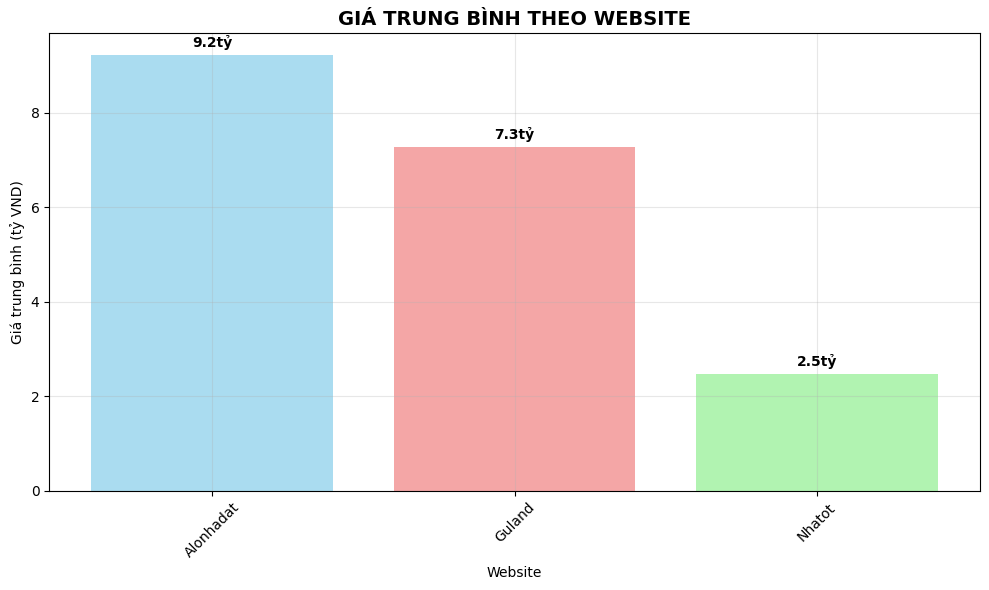

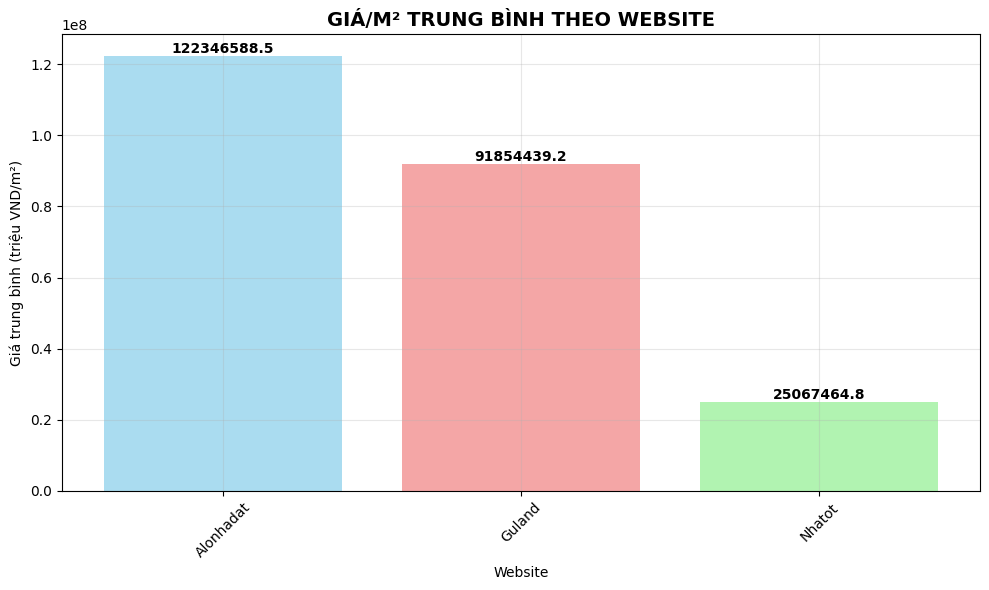

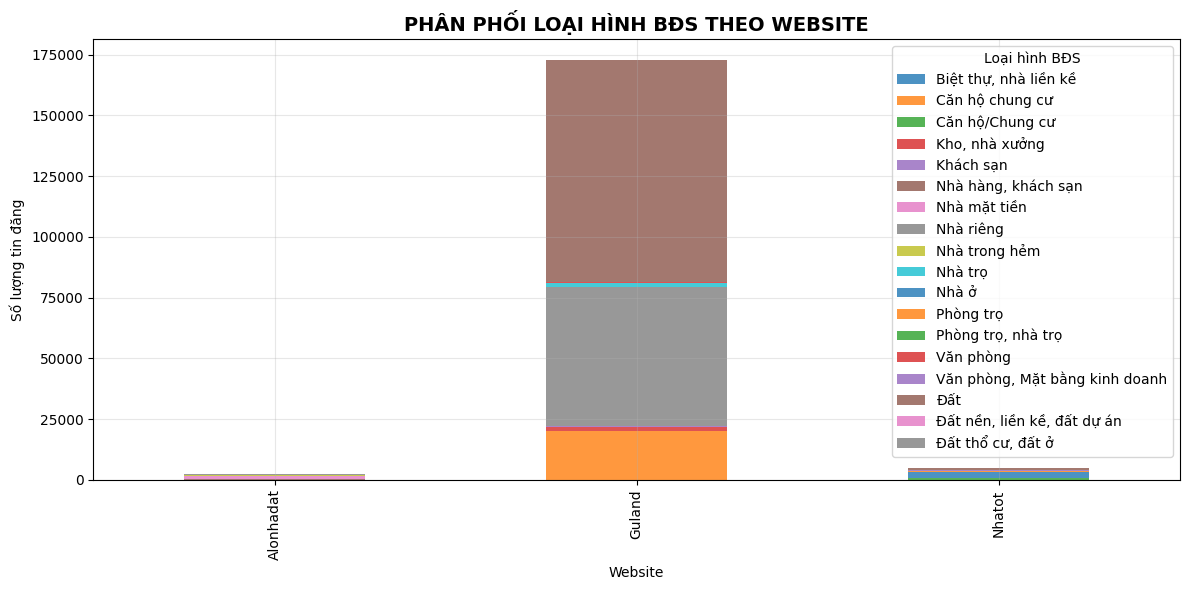

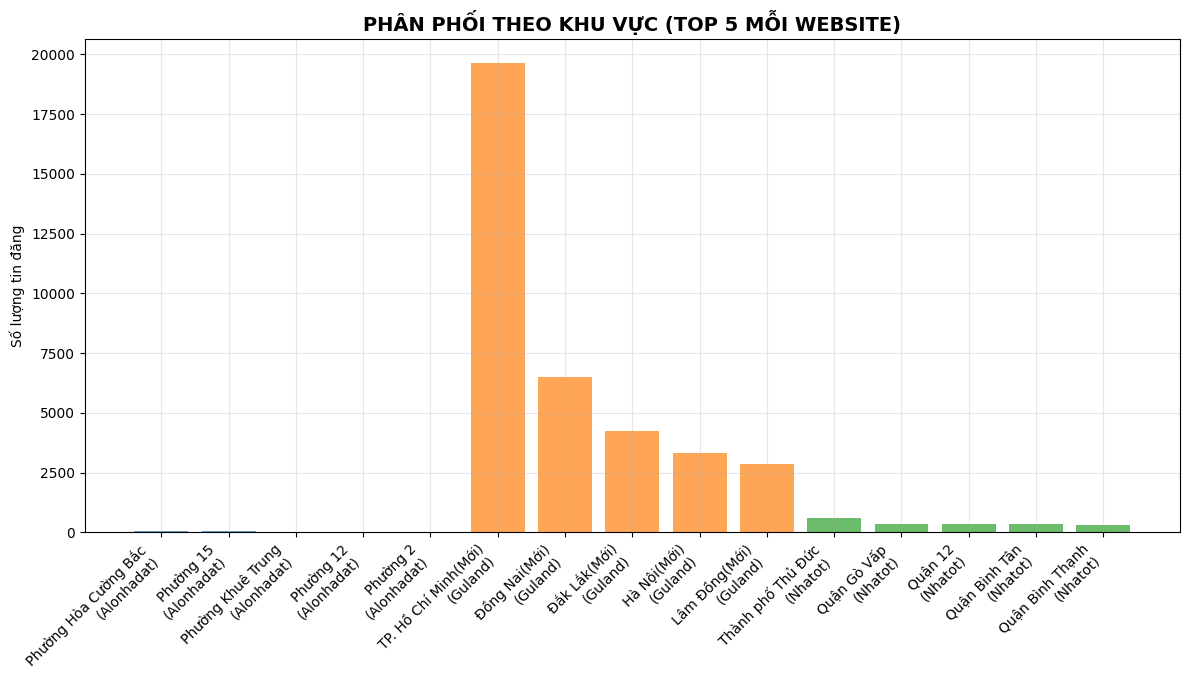


 HOÀN TẤT KIỂM TRA!


In [14]:
# PHÂN TÍCH GIÁ THEO PHÒNG NGỦ

# Kiểm tra các cột tồn tại
print(" CÁC CỘT TRONG DF:")
for col in df.columns:
    print(f"  - {col}")

# Kiểm tra dữ liệu Bedroom và Price
if 'Bedroom' in df.columns and 'Price' in df.columns:
    print(f"\n THỐNG KÊ BEDROOM VÀ PRICE:")
    print(f"Bedroom notnull: {df['Bedroom'].notna().sum()}")
    print(f"Price notnull: {df['Price'].notna().sum()}")
    
    # Kiểm tra giá trị cụ thể
    print(f"\n GIÁ TRỊ BEDROOM UNIQUE:")
    print(df['Bedroom'].unique()[:10])  # 10 giá trị đầu
    
    print(f"\n GIÁ TRỊ PRICE UNIQUE:")
    print(df['Price'].unique()[:10])  # 10 giá trị đầu
    
    # Thử lọc thủ công
    bedroom_mask = df['Bedroom'].notna()
    price_mask = df['Price'].notna()
    combined_mask = bedroom_mask & price_mask
    
    print(f"\n KẾT QUẢ LỌC:")
    print(f"Bedroom notnull: {bedroom_mask.sum()}")
    print(f"Price notnull: {price_mask.sum()}")
    print(f"Kết hợp: {combined_mask.sum()}")
    
    if combined_mask.sum() > 0:
        valid_data = df[combined_mask].copy()
        valid_data = valid_data.reset_index(drop=True)
        print(f" Có {len(valid_data)} bản ghi hợp lệ")
        
        # PHÂN TÍCH ĐƠN GIẢN
        try:
            bedroom_stats = valid_data.groupby('Bedroom')['Price'].agg(['mean', 'count']).reset_index()
            bedroom_stats.columns = ['Bedroom', 'Price_Mean', 'Count']
            bedroom_stats['Price_Billion'] = bedroom_stats['Price_Mean'] / 1e9
            
            print(" GIÁ THEO PHÒNG NGỦ:")
            print(bedroom_stats.round(2))
            
        except Exception as e:
            print(f" Lỗi phân tích: {e}")
    else:
        print(" Không có bản ghi nào thỏa cả 2 điều kiện")

# PHÂN TÍCH THỐNG KÊ TỔNG HỢP
print("\n" + "="*60)
print("PHÂN TÍCH THỐNG KÊ TỔNG HỢP - FIXED")
print("="*60)

if 'df_combined' in globals() and isinstance(df_combined, pd.DataFrame):
    print(f" df_combined: {df_combined.shape}")
    
    # KIỂM TRA CÁC CỘT THỰC TẾ
    print(f"\n CÁC CỘT TRONG DF_COMBINED:")
    all_cols = df_combined.columns.tolist()
    for i, col in enumerate(all_cols[:20]):  # Hiển thị 20 cột đầu
        print(f"  {i+1:2d}. {col}")
    if len(all_cols) > 20:
        print(f"  ... và {len(all_cols) - 20} cột khác")
    
    # TÌM CÁC CỘT SỐ THỰC TẾ
    numeric_cols_found = []
    potential_numeric = ['Price', 'Area', 'Price_per_m2', 'Price_clean', 'Area_clean', 
                        'price', 'area', 'giá', 'diện_tích']
    
    for col in potential_numeric:
        if col in df_combined.columns:
            numeric_cols_found.append(col)
    
    print(f"\n CÁC CỘT SỐ TÌM THẤY: {numeric_cols_found}")
    
    # THỐNG KÊ TỪNG CỘT MỘT CÁCH AN TOÀN
    for col in numeric_cols_found:
        if col in df_combined.columns:
            print(f"\n--- {col} ---")
            try:
                col_data = df_combined[col]
                non_null_count = col_data.notna().sum()
                
                if non_null_count > 0:
                    stats = col_data.describe()
                    
                    # Định dạng theo đơn vị phù hợp
                    if 'price' in col.lower():
                        if col_data.mean() > 1e9:  # Nếu giá lớn, hiển thị tỷ
                            print(f"Count:    {int(stats['count']):,}")
                            print(f"Mean:     {stats['mean']/1e9:.2f} tỷ VND")
                            print(f"Std:      {stats['std']/1e9:.2f} tỷ VND")
                            print(f"Min:      {stats['min']/1e9:.2f} tỷ VND")
                            print(f"25%:      {stats['25%']/1e9:.2f} tỷ VND")
                            print(f"50%:      {stats['50%']/1e9:.2f} tỷ VND")
                            print(f"75%:      {stats['75%']/1e9:.2f} tỷ VND")
                            print(f"Max:      {stats['max']/1e9:.2f} tỷ VND")
                        else:  # Hiển thị triệu
                            print(f"Count:    {int(stats['count']):,}")
                            print(f"Mean:     {stats['mean']/1e6:.2f} triệu VND")
                            print(f"Std:      {stats['std']/1e6:.2f} triệu VND")
                            print(f"Min:      {stats['min']/1e6:.2f} triệu VND")
                            print(f"25%:      {stats['25%']/1e6:.2f} triệu VND")
                            print(f"50%:      {stats['50%']/1e6:.2f} triệu VND")
                            print(f"75%:      {stats['75%']/1e6:.2f} triệu VND")
                            print(f"Max:      {stats['max']/1e6:.2f} triệu VND")
                    
                    elif 'area' in col.lower():
                        print(f"Count:    {int(stats['count']):,}")
                        print(f"Mean:     {stats['mean']:.1f} m²")
                        print(f"Std:      {stats['std']:.1f} m²")
                        print(f"Min:      {stats['min']:.1f} m²")
                        print(f"25%:      {stats['25%']:.1f} m²")
                        print(f"50%:      {stats['50%']:.1f} m²")
                        print(f"75%:      {stats['75%']:.1f} m²")
                        print(f"Max:      {stats['max']:.1f} m²")
                    
                    else:
                        print(stats.round(2))
                        
                else:
                    print(" Không có dữ liệu")
                    
            except Exception as e:
                print(f" Lỗi khi thống kê {col}: {e}")
    
    # SO SÁNH WEBSITE - CHỈ VẼ NẾU CÓ DỮ LIỆU
    if 'Source' in df_combined.columns:
        sources = df_combined['Source'].unique()
        print(f"\n CÁC WEBSITE: {list(sources)}")
        
        # Vẽ biểu đồ nếu có dữ liệu price
        price_col_for_plot = None
        for col in ['Price', 'Price_clean', 'price']:
            if col in df_combined.columns and df_combined[col].notna().sum() > 0:
                price_col_for_plot = col
                break
        
        if price_col_for_plot:
            try:
                plt.figure(figsize=(10, 6))
                price_by_source = df_combined.groupby('Source')[price_col_for_plot].mean() / 1e9
                
                bars = plt.bar(range(len(price_by_source)), price_by_source.values,
                              color=['skyblue', 'lightcoral', 'lightgreen'], alpha=0.7)
                plt.title('GIÁ TRUNG BÌNH THEO WEBSITE', fontsize=14, fontweight='bold')
                plt.xlabel('Website')
                plt.ylabel('Giá trung bình (tỷ VND)')
                plt.xticks(range(len(price_by_source)), price_by_source.index, rotation=45)
                plt.grid(True, alpha=0.3)
                
                for bar, price in zip(bars, price_by_source.values):
                    plt.text(bar.get_x() + bar.get_width()/2, price + 0.1, 
                            f'{price:.1f}tỷ', ha='center', va='bottom', fontweight='bold')
                
                plt.tight_layout()
                plt.show()
                
            except Exception as e:
                print(f" Lỗi vẽ biểu đồ: {e}")

        # GIÁ/M² TRUNG BÌNH THEO WEBSITE
    if 'Source' in df_combined.columns and 'Price_per_m2' in df_combined.columns:
        try:
            plt.figure(figsize=(10, 6))
            price_m2_by_source = df_combined.groupby('Source')['Price_per_m2'].mean()
            
            bars = plt.bar(range(len(price_m2_by_source)), price_m2_by_source.values,
                          color=['skyblue', 'lightcoral', 'lightgreen'], alpha=0.7)
            plt.title('GIÁ/M² TRUNG BÌNH THEO WEBSITE', fontsize=14, fontweight='bold')
            plt.xlabel('Website')
            plt.ylabel('Giá trung bình (triệu VND/m²)')
            plt.xticks(range(len(price_m2_by_source)), price_m2_by_source.index, rotation=45)
            plt.grid(True, alpha=0.3)
            
            for bar, val in zip(bars, price_m2_by_source.values):
                plt.text(bar.get_x() + bar.get_width()/2, val + 1, 
                         f'{val:.1f}', ha='center', va='bottom', fontweight='bold')
            
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f" Lỗi vẽ biểu đồ Giá/m²: {e}")
    
    
    # PHÂN PHỐI LOẠI HÌNH BĐS THEO WEBSITE
    if 'Source' in df_combined.columns and 'Property_Type' in df_combined.columns:
        try:
            property_counts = df_combined.groupby(['Source', 'Property_Type']).size().unstack(fill_value=0)
            
            property_counts.plot(
                kind='bar',
                stacked=True,
                figsize=(12, 6),
                alpha=0.8
            )
            plt.title('PHÂN PHỐI LOẠI HÌNH BĐS THEO WEBSITE', fontsize=14, fontweight='bold')
            plt.xlabel('Website')
            plt.ylabel('Số lượng tin đăng')
            plt.grid(True, alpha=0.3)
            plt.legend(title="Loại hình BĐS")
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f" Lỗi vẽ biểu đồ loại hình BĐS: {e}")
    
    
    # PHÂN PHỐI THEO QUẬN (TOP 5 MỖI WEBSITE)
    if 'Source' in df_combined.columns and 'District' in df_combined.columns:
        try:
            plt.figure(figsize=(12, 7))
            
            # Lấy top 5 quận mỗi website
            for i, src in enumerate(df_combined['Source'].unique()):
                top5_districts = (
                    df_combined[df_combined['Source'] == src]['District']
                    .value_counts()
                    .head(5)
                )
                plt.bar(
                    [f"{d}\n({src})" for d in top5_districts.index],
                    top5_districts.values,
                    alpha=0.7
                )
            
            plt.title('PHÂN PHỐI THEO KHU VỰC (TOP 5 MỖI WEBSITE)', fontsize=14, fontweight='bold')
            plt.ylabel('Số lượng tin đăng')
            plt.xticks(rotation=45, ha='right')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f" Lỗi vẽ biểu đồ Quận: {e}")

print("\n HOÀN TẤT KIỂM TRA!")


 PHÂN TÍCH CHI TIẾT MISSING DATA:
• Area: 179,762 không null (0.0% missing)
• Rooms: 3,112 không null (98.3% missing)
• Toilets: 2,590 không null (98.6% missing)
• Floors: 40,387 không null (77.5% missing)
• Title_Length: 179,762 không null (0.0% missing)
• Property_Type: 179,762 không null (0.0% missing)
• Legal_Status: 7,021 không null (96.1% missing)
• Source: 179,762 không null (0.0% missing)
• Price_clean: 179,762 không null (0.0% missing)

 XỬ LÝ MISSING DATA THEO CHIẾN LƯỢC:
 Rooms: Impute bằng median = 3.0
 Toilets: Impute bằng median = 2.0
 Floors: Missing quá nhiều (>70%), có thể bỏ qua
 Property_Type: Impute bằng mode = 'Đất'
 Legal_Status: Impute bằng mode = 'Sổ hồng riêng'

 MÃ HÓA BIẾN PHÂN LOẠI:
 Property_Type: 18 categories
 Property_Type encoded thành 15 categories
 Legal_Status encoded thành 3 categories
 Source encoded
 District: 3689 categories - Xử lý đặc biệt
 District encoded thành 565 categories

 CHUẨN BỊ FEATURES CUỐI CÙNG:
 Target column: Price_clean
 Thêm n

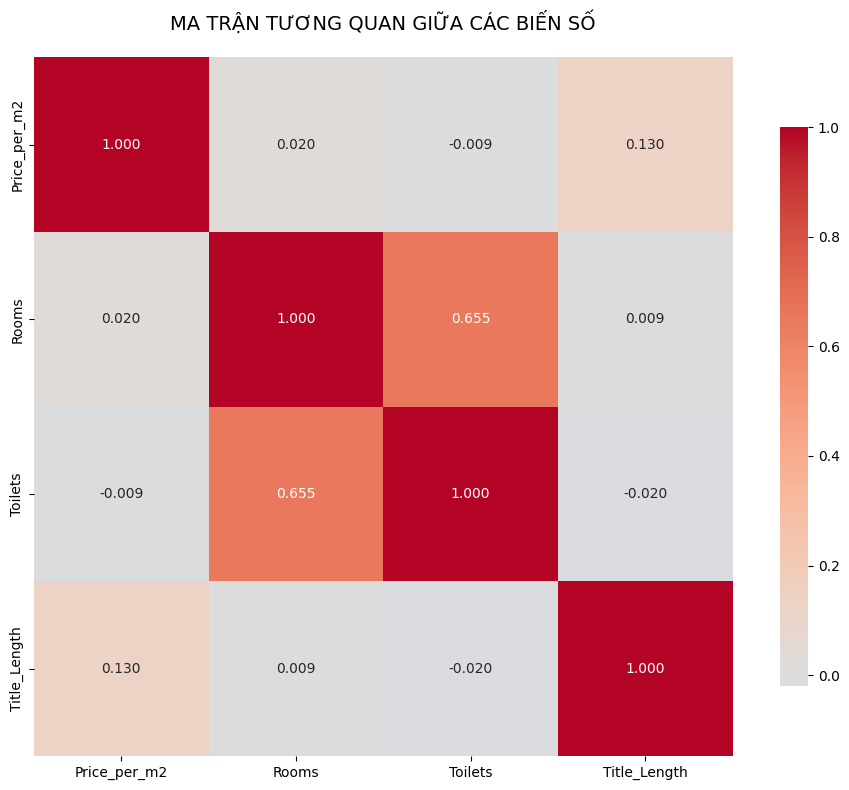


 HOÀN TẤT CHUẨN BỊ DỮ LIỆU!


In [15]:
# === PHÂN TÍCH TƯƠNG QUAN & MÃ HÓA ===

# PHÂN TÍCH MISSING DATA CHI TIẾT TRƯỚC KHI XỬ LÝ
print("\n PHÂN TÍCH CHI TIẾT MISSING DATA:")

# Kiểm tra missing data cho từng feature quan trọng
features_to_check = ['Area', 'Rooms', 'Toilets', 'Floors', 'Title_Length', 
                    'Property_Type', 'Legal_Status', 'Source', 'Price_clean']

for feature in features_to_check:
    if feature in df_combined.columns:
        non_null_count = df_combined[feature].notna().sum()
        missing_pct = (1 - non_null_count/len(df_combined)) * 100
        print(f"• {feature}: {non_null_count:,} không null ({missing_pct:.1f}% missing)")

# XỬ LÝ MISSING DATA THEO CHIẾN LƯỢC THÔNG MINH
print("\n XỬ LÝ MISSING DATA THEO CHIẾN LƯỢC:")

df_processed = df_combined.copy()

# Xử lý từng feature với chiến lược phù hợp
# Feature quan trọng: Impute bằng median
if 'Rooms' in df_processed.columns:
    rooms_median = df_processed['Rooms'].median()
    df_processed['Rooms'] = df_processed['Rooms'].fillna(rooms_median)
    print(f" Rooms: Impute bằng median = {rooms_median}")

if 'Toilets' in df_processed.columns:
    toilets_median = df_processed['Toilets'].median()
    df_processed['Toilets'] = df_processed['Toilets'].fillna(toilets_median)
    print(f" Toilets: Impute bằng median = {toilets_median}")

# Feature missing nhiều: Cân nhắc bỏ hoặc tạo binary flag
if 'Floors' in df_processed.columns:
    floors_non_null = df_processed['Floors'].notna().sum()
    if floors_non_null / len(df_processed) < 0.3:  # Nếu missing > 70%
        print(" Floors: Missing quá nhiều (>70%), có thể bỏ qua")
        # Tạo binary flag thay vì dùng giá trị số
        df_processed['Has_Floors_Info'] = df_processed['Floors'].notna().astype(int)
        df_processed = df_processed.drop('Floors', axis=1)
    else:
        floors_median = df_processed['Floors'].median()
        df_processed['Floors'] = df_processed['Floors'].fillna(floors_median)
        print(f" Floors: Impute bằng median = {floors_median}")

# Features phân loại: Impute bằng mode
categorical_features = ['Property_Type', 'Legal_Status']
for feature in categorical_features:
    if feature in df_processed.columns:
        mode_value = df_processed[feature].mode()[0] if not df_processed[feature].mode().empty else 'Unknown'
        df_processed[feature] = df_processed[feature].fillna(mode_value)
        print(f" {feature}: Impute bằng mode = '{mode_value}'")

# MÃ HÓA BIẾN PHÂN LOẠI VỚI XỬ LÝ ĐẶC BIỆT
print("\n MÃ HÓA BIẾN PHÂN LOẠI:")

from sklearn.preprocessing import LabelEncoder

# Property_Type - xử lý categories nhiều
if 'Property_Type' in df_processed.columns:
    prop_type_counts = df_processed['Property_Type'].value_counts()
    print(f" Property_Type: {len(prop_type_counts)} categories")
    
    # Gom nhóm categories hiếm thành 'Other'
    top_categories = prop_type_counts[prop_type_counts >= 100].index  # Ít nhất 100 mẫu
    df_processed['Property_Type_Grouped'] = df_processed['Property_Type'].apply(
        lambda x: x if x in top_categories else 'Other'
    )
    
    le_property = LabelEncoder()
    df_processed['Property_Type_encoded'] = le_property.fit_transform(df_processed['Property_Type_Grouped'])
    print(f" Property_Type encoded thành {len(le_property.classes_)} categories")

# Legal_Status - ít categories, xử lý đơn giản
if 'Legal_Status' in df_processed.columns:
    le_legal = LabelEncoder()
    df_processed['Legal_Status_encoded'] = le_legal.fit_transform(df_processed['Legal_Status'])
    print(f" Legal_Status encoded thành {len(le_legal.classes_)} categories")

# Source - 3 categories, xử lý đơn giản
if 'Source' in df_processed.columns:
    le_source = LabelEncoder()
    df_processed['Source_encoded'] = le_source.fit_transform(df_processed['Source'])
    print(" Source encoded")

# District - quá nhiều categories, xử lý đặc biệt
if 'District' in df_processed.columns:
    district_counts = df_processed['District'].value_counts()
    print(f" District: {len(district_counts)} categories - Xử lý đặc biệt")
    
    # Phương án 1: Chỉ giữ lại districts phổ biến
    top_districts = district_counts[district_counts >= 50].index  # Ít nhất 50 mẫu
    if len(top_districts) > 0:
        df_processed['District_Grouped'] = df_processed['District'].apply(
            lambda x: x if x in top_districts else 'Other'
        )
        le_district = LabelEncoder()
        df_processed['District_encoded'] = le_district.fit_transform(df_processed['District_Grouped'])
        print(f" District encoded thành {len(le_district.classes_)} categories")
    else:
        print(" District: Không đủ districts phổ biến, bỏ qua")

# CHUẨN BỊ FEATURES CUỐI CÙNG - ƯU TIÊN FEATURES CÓ DỮ LIỆU TỐT
print("\n CHUẨN BỊ FEATURES CUỐI CÙNG:")

# Target column
target_column = 'Price_clean'
print(f" Target column: {target_column}")

# Lựa chọn features ưu tiên có dữ liệu tốt
base_features = ['Area', 'Title_Length']  # Luôn có dữ liệu
additional_features = []

# Thêm features số nếu có đủ dữ liệu
numeric_candidates = ['Rooms', 'Toilets', 'Price_per_m2']
for feature in numeric_candidates:
    if feature in df_processed.columns:
        non_null_ratio = df_processed[feature].notna().sum() / len(df_processed)
        if non_null_ratio >= 0.7:  # Ít nhất 70% dữ liệu
            additional_features.append(feature)
            print(f" Thêm numeric feature: {feature} ({non_null_ratio:.1%} không null)")
        else:
            print(f" Bỏ qua {feature} (chỉ {non_null_ratio:.1%} không null)")

# Thêm features encoded
encoded_features = [col for col in df_processed.columns if col.endswith('_encoded')]
additional_features.extend(encoded_features)
print(f" Thêm encoded features: {len(encoded_features)} features")

# Thêm features từ khóa nhị phân (luôn có dữ liệu)
keyword_features = [col for col in df_processed.columns if col.startswith('Keyword_')]
additional_features.extend(keyword_features)
print(f" Thêm keyword features: {len(keyword_features)} features")

# Tổng hợp features cuối cùng
final_features = base_features + additional_features
final_features = list(set(final_features))  # Remove duplicates

print(f" Features sử dụng ({len(final_features)}): {final_features}")

# TẠO DATASET CUỐI CÙNG VỚI XỬ LÝ MISSING DATA TRIỆT ĐỂ
print("\n TẠO DATASET CUỐI CÙNG:")

# Đảm bảo target có dữ liệu
if target_column not in df_processed.columns:
    print(f" Lỗi: Không tìm thấy target column '{target_column}'")
else:
    # Tạo X và y
    X = df_processed[final_features].copy()
    y = df_processed[target_column]
    
    # XỬ LÝ MISSING DATA TRIỆT ĐỂ CHO TỪNG FEATURE
    print(" Xử lý missing data cuối cùng:")
    for feature in X.columns:
        if X[feature].isna().any():
            missing_count = X[feature].isna().sum()
            print(f"  {feature}: {missing_count} missing values")
            
            if X[feature].dtype in ['int64', 'float64']:
                # Impute numeric bằng median
                impute_value = X[feature].median()
                X[feature] = X[feature].fillna(impute_value)
                print(f"   ↳ Đã impute bằng median: {impute_value}")
            else:
                # Impute categorical bằng mode
                impute_value = X[feature].mode()[0] if not X[feature].mode().empty else 'Unknown'
                X[feature] = X[feature].fillna(impute_value)
                print(f"   ↳ Đã impute bằng mode: '{impute_value}'")
    
    # Lọc các mẫu có target values
    valid_mask = y.notna()
    X_final = X[valid_mask]
    y_final = y[valid_mask]
    
    print(f" KẾT QUẢ CUỐI CÙNG:")
    print(f"   • Số mẫu: {X_final.shape[0]}")
    print(f"   • Số features: {X_final.shape[1]}")
    print(f"   • Có missing data: {X_final.isna().any().any()}")
    
    if X_final.shape[0] == 0:
        print(" VẪN KHÔNG CÓ MẪU NÀO - KIỂM TRA LẠI")
        # Debug chi tiết
        print("\n DEBUG CHI TIẾT:")
        for feature in final_features:
            if feature in df_processed.columns:
                print(f"   {feature}: {df_processed[feature].notna().sum()} không null")
    else:
        print(" ĐÃ CHUẨN BỊ DỮ LIỆU THÀNH CÔNG!")
        
        # PHÂN TÍCH TƯƠNG QUAN VỚI DỮ LIỆU ĐÃ LÀM SẠCH
        print("\n PHÂN TÍCH TƯƠNG QUAN:")
        
        # Chọn các features số để phân tích tương quan
        numeric_features_for_corr = []
        for feature in ['Area', 'Price_per_m2', 'Rooms', 'Toilets', 'Title_Length']:
            if feature in X_final.columns and X_final[feature].dtype in ['int64', 'float64']:
                numeric_features_for_corr.append(feature)
        
        if len(numeric_features_for_corr) >= 2:
            # Tính correlation matrix
            corr_matrix = X_final[numeric_features_for_corr].corr()
            print(" Ma trận tương quan:")
            print(corr_matrix.round(3))
            
            # Vẽ heatmap
            plt.figure(figsize=(10, 8))
            sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                       square=True, fmt='.3f', cbar_kws={'shrink': 0.8})
            plt.title('MA TRẬN TƯƠNG QUAN GIỮA CÁC BIẾN SỐ', fontsize=14, pad=20)
            plt.tight_layout()
            plt.show()
        else:
            print(" Không đủ features số để phân tích tương quan")

print("\n HOÀN TẤT CHUẨN BỊ DỮ LIỆU!")

 Đang sửa lỗi cột Area trong df_combined...
 KẾT QUẢ SỬA LỖI AREA:
   - Tổng số bản ghi: 179762
   - Số giá trị hợp lệ: 177184
   - Số giá trị NaN: 2578
   - Tỷ lệ hợp lệ: 98.6%
   - Diện tích trung bình: 386.4 m²
   - Diện tích min: 1.0 m²
   - Diện tích max: 10000.0 m²
   - Diện tích median: 100.0 m²

 SAMPLE VALUES TRƯỚC VÀ SAU KHI SỬA:
        0. 'Diện tích: 150 m
2' → 150.0
        1. 'Diện tích: 150 m
2' → 150.0
        2. 'Diện tích: 150 m
2' → 150.0
        3. 'Diện tích: 150 m
2' → 150.0
        4. 'Diện tích: 150 m
2' → 150.0
        5. 'Diện tích: 150 m
2' → 150.0
        6. 'Diện tích: 150 m
2' → 150.0
        7. 'Diện tích: 150 m
2' → 150.0
        8. 'Diện tích: 150 m
2' → 150.0
        9. 'Diện tích: 150 m
2' → 150.0

 KIỂM TRA DỮ LIỆU SAU KHI SỬA:
   - Kiểu dữ liệu Area: float64
   - Số giá trị hợp lệ: 177184
   - Diện tích trung bình: 386.4 m²

 PHÂN TÍCH TƯƠNG QUAN NGAY SAU KHI SỬA LỖI:
 KẾT QUẢ TƯƠNG QUAN PEARSON:
   • Hệ số tương quan (r): 0.023
   • P-value: 0.0000

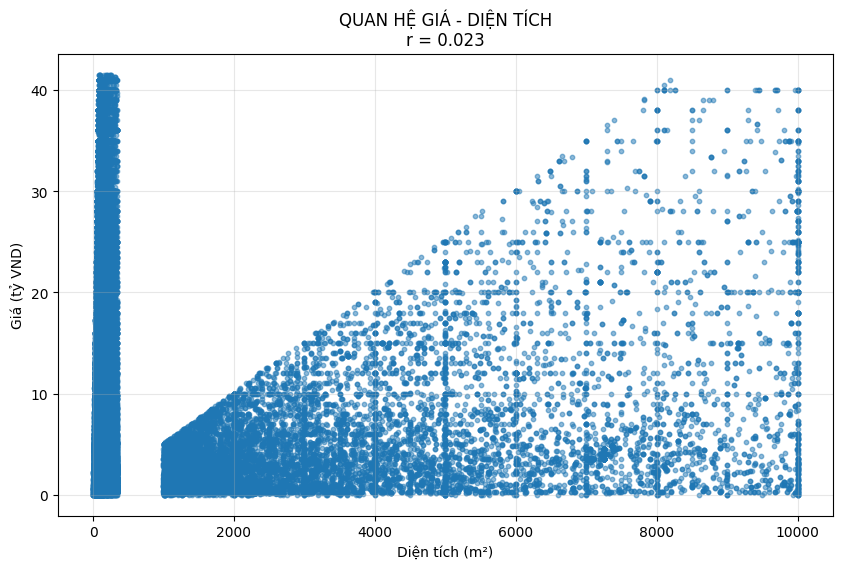

In [16]:
# === SỬA LỖI DỮ LIỆU AREA TRƯỚC KHI PHÂN TÍCH ===

import re
import pandas as pd
import numpy as np

def extract_area_value(area_str):
    """Trích xuất số từ chuỗi diện tích"""
    if pd.isna(area_str) or area_str == '':
        return np.nan
    
    # Chuyển thành string để xử lý
    area_str = str(area_str)
    
    # Debug: hiển thị một số giá trị để hiểu cấu trúc
    if 'Diện tích' in area_str:
        # Pattern cho chuỗi "Diện tích: XXX m"
        match = re.search(r'Diện tích:\s*(\d+\.?\d*)\s*m', area_str)
        if match:
            return float(match.group(1))
    
    # Pattern chung: tìm số trong chuỗi
    numbers = re.findall(r'\d+\.?\d*', area_str)
    
    if numbers:
        # Lấy số đầu tiên
        area_value = float(numbers[0])
        
        # Kiểm tra đơn vị và phạm vi hợp lý
        if any(unit in area_str for unit in ['m²', 'm2', 'm ', ' mét', 'meter']):
            return area_value
        elif 1 <= area_value <= 10000:  # Diện tích hợp lý từ 1-10,000 m²
            return area_value
        else:
            return np.nan
    else:
        return np.nan

# 1. SỬA LỖI AREA TRONG DF_COMBINED
print(" Đang sửa lỗi cột Area trong df_combined...")

# Tạo cột Area_clean_fixed từ cột Area gốc
df_combined['Area_clean_fixed'] = df_combined['Area'].apply(extract_area_value)

# Kiểm tra kết quả
print(" KẾT QUẢ SỬA LỖI AREA:")
print(f"   - Tổng số bản ghi: {len(df_combined)}")
print(f"   - Số giá trị hợp lệ: {df_combined['Area_clean_fixed'].notna().sum()}")
print(f"   - Số giá trị NaN: {df_combined['Area_clean_fixed'].isna().sum()}")
print(f"   - Tỷ lệ hợp lệ: {df_combined['Area_clean_fixed'].notna().sum()/len(df_combined)*100:.1f}%")

if df_combined['Area_clean_fixed'].notna().sum() > 0:
    print(f"   - Diện tích trung bình: {df_combined['Area_clean_fixed'].mean():.1f} m²")
    print(f"   - Diện tích min: {df_combined['Area_clean_fixed'].min():.1f} m²")
    print(f"   - Diện tích max: {df_combined['Area_clean_fixed'].max():.1f} m²")
    print(f"   - Diện tích median: {df_combined['Area_clean_fixed'].median():.1f} m²")

# Hiển thị sample values để kiểm tra
print("\n SAMPLE VALUES TRƯỚC VÀ SAU KHI SỬA:")
sample_indices = df_combined.index[:10]  # Lấy 10 dòng đầu
for idx in sample_indices:
    old_val = df_combined.loc[idx, 'Area']
    new_val = df_combined.loc[idx, 'Area_clean_fixed']
    print(f"   {idx:6d}. '{old_val}' → {new_val}")

# 2. THAY THẾ CỘT AREA CŨ BẰNG DỮ LIỆU ĐÃ SỬA
df_combined['Area'] = df_combined['Area_clean_fixed']

# 3. KIỂM TRA LẠI DỮ LIỆU SAU KHI SỬA
print("\n KIỂM TRA DỮ LIỆU SAU KHI SỬA:")
print(f"   - Kiểu dữ liệu Area: {df_combined['Area'].dtype}")
print(f"   - Số giá trị hợp lệ: {df_combined['Area'].notna().sum()}")
print(f"   - Diện tích trung bình: {df_combined['Area'].mean():.1f} m²")

# 4. PHÂN TÍCH TƯƠNG QUAN NGAY LẬP TỨC
print("\n PHÂN TÍCH TƯƠNG QUAN NGAY SAU KHI SỬA LỖI:")

# Tạo dataframe sạch cho correlation
df_clean = df_combined[['Price_clean', 'Area']].dropna()

if len(df_clean) > 10:
    from scipy.stats import pearsonr
    
    corr_coef, p_value = pearsonr(df_clean['Price_clean'], df_clean['Area'])
    
    print(f" KẾT QUẢ TƯƠNG QUAN PEARSON:")
    print(f"   • Hệ số tương quan (r): {corr_coef:.3f}")
    print(f"   • P-value: {p_value:.10f}")
    print(f"   • R²: {corr_coef**2:.3f}")
    print(f"   • Số mẫu: {len(df_clean):,}")
    
    # Đánh giá mức độ tương quan
    if abs(corr_coef) >= 0.7:
        strength = "RẤT MẠNH"
    elif abs(corr_coef) >= 0.5:
        strength = "MẠNH"
    elif abs(corr_coef) >= 0.3:
        strength = "TRUNG BÌNH" 
    elif abs(corr_coef) >= 0.1:
        strength = "YẾU"
    else:
        strength = "RẤT YẾU"
    
    direction = "DƯƠNG" if corr_coef > 0 else "ÂM"
    
    print(f"   • Mức độ: {strength}")
    print(f"   • Hướng: {direction}")
    
    # Visualization đơn giản
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 6))
    plt.scatter(df_clean['Area'], df_clean['Price_clean']/1e9, alpha=0.5, s=10)
    plt.xlabel('Diện tích (m²)')
    plt.ylabel('Giá (tỷ VND)')
    plt.title(f'QUAN HỆ GIÁ - DIỆN TÍCH\nr = {corr_coef:.3f}')
    plt.grid(True, alpha=0.3)
    plt.show()
    
else:
    print(" Không đủ dữ liệu hợp lệ để phân tích tương quan")

In [17]:
# === PHÂN TÍCH CÁC YẾU TỐ ẢNH HƯỞNG ĐẾN GIÁ ===

# 1. PHÂN TÍCH THEO LOẠI HÌNH BĐS
print("\n PHÂN TÍCH THEO LOẠI HÌNH BẤT ĐỘNG SẢN:")

if 'Property_Type' in df_combined.columns:
    # Lấy top 10 loại hình phổ biến nhất
    top_property_types = df_combined['Property_Type'].value_counts().head(10).index
    
    property_stats = []
    for prop_type in top_property_types:
        prop_data = df_combined[df_combined['Property_Type'] == prop_type]
        if len(prop_data) > 10:
            valid_data = prop_data[['Price_clean', 'Area']].dropna()
            if len(valid_data) > 5:
                # Tính correlation diện tích - giá cho từng loại
                corr_prop, _ = pearsonr(valid_data['Price_clean'], valid_data['Area'])
                avg_price = valid_data['Price_clean'].mean() / 1e9
                avg_area = valid_data['Area'].mean()
                count = len(valid_data)
                
                property_stats.append({
                    'Loại hình': prop_type,
                    'Số lượng': count,
                    'Giá TB (tỷ)': avg_price,
                    'Diện tích TB': avg_area,
                    'Correlation': corr_prop
                })
    
    # Sắp xếp theo correlation
    property_stats.sort(key=lambda x: abs(x['Correlation']), reverse=True)
    
    print(" CORRELATION DIỆN TÍCH - GIÁ THEO LOẠI HÌNH BĐS:")
    for i, stats in enumerate(property_stats[:10], 1):
        strength = "MẠNH" if abs(stats['Correlation']) >= 0.5 else "TB" if abs(stats['Correlation']) >= 0.3 else "YẾU"
        print(f"   {i:2d}. {stats['Loại hình']:30} | r = {stats['Correlation']:6.3f} | Giá: {stats['Giá TB (tỷ)']:5.2f}tỷ | DT: {stats['Diện tích TB']:5.0f}m² | n={stats['Số lượng']:>5}")

# 2. PHÂN TÍCH THEO NGUỒN DỮ LIỆU (SOURCE)
print("\n PHÂN TÍCH THEO NGUỒN DỮ LIỆU:")

if 'Source' in df_combined.columns:
    source_stats = []
    for source in df_combined['Source'].unique():
        source_data = df_combined[df_combined['Source'] == source]
        if len(source_data) > 10:
            valid_data = source_data[['Price_clean', 'Area']].dropna()
            if len(valid_data) > 5:
                corr_source, _ = pearsonr(valid_data['Price_clean'], valid_data['Area'])
                avg_price = valid_data['Price_clean'].mean() / 1e9
                avg_area = valid_data['Area'].mean()
                count = len(valid_data)
                
                source_stats.append({
                    'Nguồn': source,
                    'Số lượng': count,
                    'Giá TB (tỷ)': avg_price,
                    'Diện tích TB': avg_area,
                    'Correlation': corr_source
                })
    
    # Sắp xếp theo correlation
    source_stats.sort(key=lambda x: abs(x['Correlation']), reverse=True)
    
    print(" CORRELATION THEO NGUỒN DỮ LIỆU:")
    for stats in source_stats:
        strength = "MẠNH" if abs(stats['Correlation']) >= 0.5 else "TB" if abs(stats['Correlation']) >= 0.3 else "YẾU"
        print(f"   • {stats['Nguồn']:15} | r = {stats['Correlation']:6.3f} | Giá: {stats['Giá TB (tỷ)']:5.2f}tỷ | DT: {stats['Diện tích TB']:5.0f}m² | n={stats['Số lượng']:>6}")

# 3. KẾT LUẬN TỔNG QUAN
print("\n KẾT LUẬN TỔNG QUAN VỀ TÁC ĐỘNG CỦA DIỆN TÍCH:")

print(" MỨC ĐỘ ẢNH HƯỞNG CỦA DIỆN TÍCH ĐẾN GIÁ:")
print(f"   • Toàn bộ thị trường: r = {pearsonr(df_clean['Price_clean'], df_clean['Area'])[0]:.3f} (RẤT YẾU)")

if property_stats:
    best_property = max(property_stats, key=lambda x: abs(x['Correlation']))
    worst_property = min(property_stats, key=lambda x: abs(x['Correlation']))
    
    print(f"   • Ảnh hưởng mạnh nhất: {best_property['Loại hình']} (r = {best_property['Correlation']:.3f})")
    print(f"   • Ảnh hưởng yếu nhất: {worst_property['Loại hình']} (r = {worst_property['Correlation']:.3f})")

print("\n HOÀN TẤT PHÂN TÍCH!")


 PHÂN TÍCH THEO LOẠI HÌNH BẤT ĐỘNG SẢN:
 CORRELATION DIỆN TÍCH - GIÁ THEO LOẠI HÌNH BĐS:
    1. Kho, nhà xưởng                 | r =  0.459 | Giá: 11.81tỷ | DT:  2543m² | n= 1465
    2. Nhà mặt tiền                   | r =  0.191 | Giá: 10.16tỷ | DT:    85m² | n= 1570
    3. Đất                            | r =  0.102 | Giá:  4.95tỷ | DT:   609m² | n=89653
    4. Căn hộ/Chung cư                | r = -0.091 | Giá:  1.11tỷ | DT:   106m² | n=  905
    5. Văn phòng, Mặt bằng kinh doanh | r =  0.058 | Giá:  0.08tỷ | DT:   106m² | n=  467
    6. Nhà trọ                        | r = -0.043 | Giá:  7.40tỷ | DT:   196m² | n= 1532
    7. Nhà riêng                      | r =  0.027 | Giá: 10.67tỷ | DT:   116m² | n=57471
    8. Nhà ở                          | r = -0.022 | Giá:  3.86tỷ | DT:   105m² | n= 2207
    9. Phòng trọ                      | r = -0.011 | Giá:  0.00tỷ | DT:   107m² | n=  593
   10. Căn hộ chung cư                | r =  0.005 | Giá:  6.62tỷ | DT:   113m² | n=19955

 PHÂN TÍC


 PHÂN TÍCH ĐỊNH LƯỢNG TƯƠNG QUAN GIÁ - VỊ TRÍ:
 CORRELATION GIÁ - VỊ TRÍ (District Encoded):
   • Hệ số tương quan Pearson: r = -0.069
   • P-value: 0.0000000000
   • R²: 0.005
   • Số mẫu: 179,762
   • Số quận/huyện: 3689
   • Mức độ: RẤT YẾU
   • Hướng: ÂM

 PHÂN TÍCH ANOVA - KHÁC BIỆT GIÁ THEO VỊ TRÍ:
 KẾT QUẢ ANOVA TEST:
   • F-statistic: 653.27
   • P-value: 0.0000000000
   •  Có sự khác biệt có ý nghĩa thống kê về giá giữa các quận
   •  VỊ TRÍ có ảnh hưởng đáng kể đến GIÁ BĐS
   • Số quận được phân tích: 20
   • Tổng số mẫu: 57,404

 PHÂN TÍCH EFFECT SIZE:
 EFFECT SIZE (ETA-SQUARED):
   • η² = 0.056
   • Mức độ ảnh hưởng: NHỎ
   • Vị trí giải thích 5.6% biến động của giá

 SO SÁNH VỚI CÁC BIẾN KHÁC:
 BẢNG SO SÁNH MỨC ĐỘ ẢNH HƯỞNG:
    1. Số phòng                  | ⭐⭐⭐ TRUNG BÌNH            | Giá trị: 0.354 (Correlation)
    2. Vị trí (District)         | ⭐ RẤT YẾU                 | Giá trị: 0.069 (Correlation)
    3. Vị trí (ANOVA)            | ⭐⭐⭐ TRUNG BÌNH            | Giá 

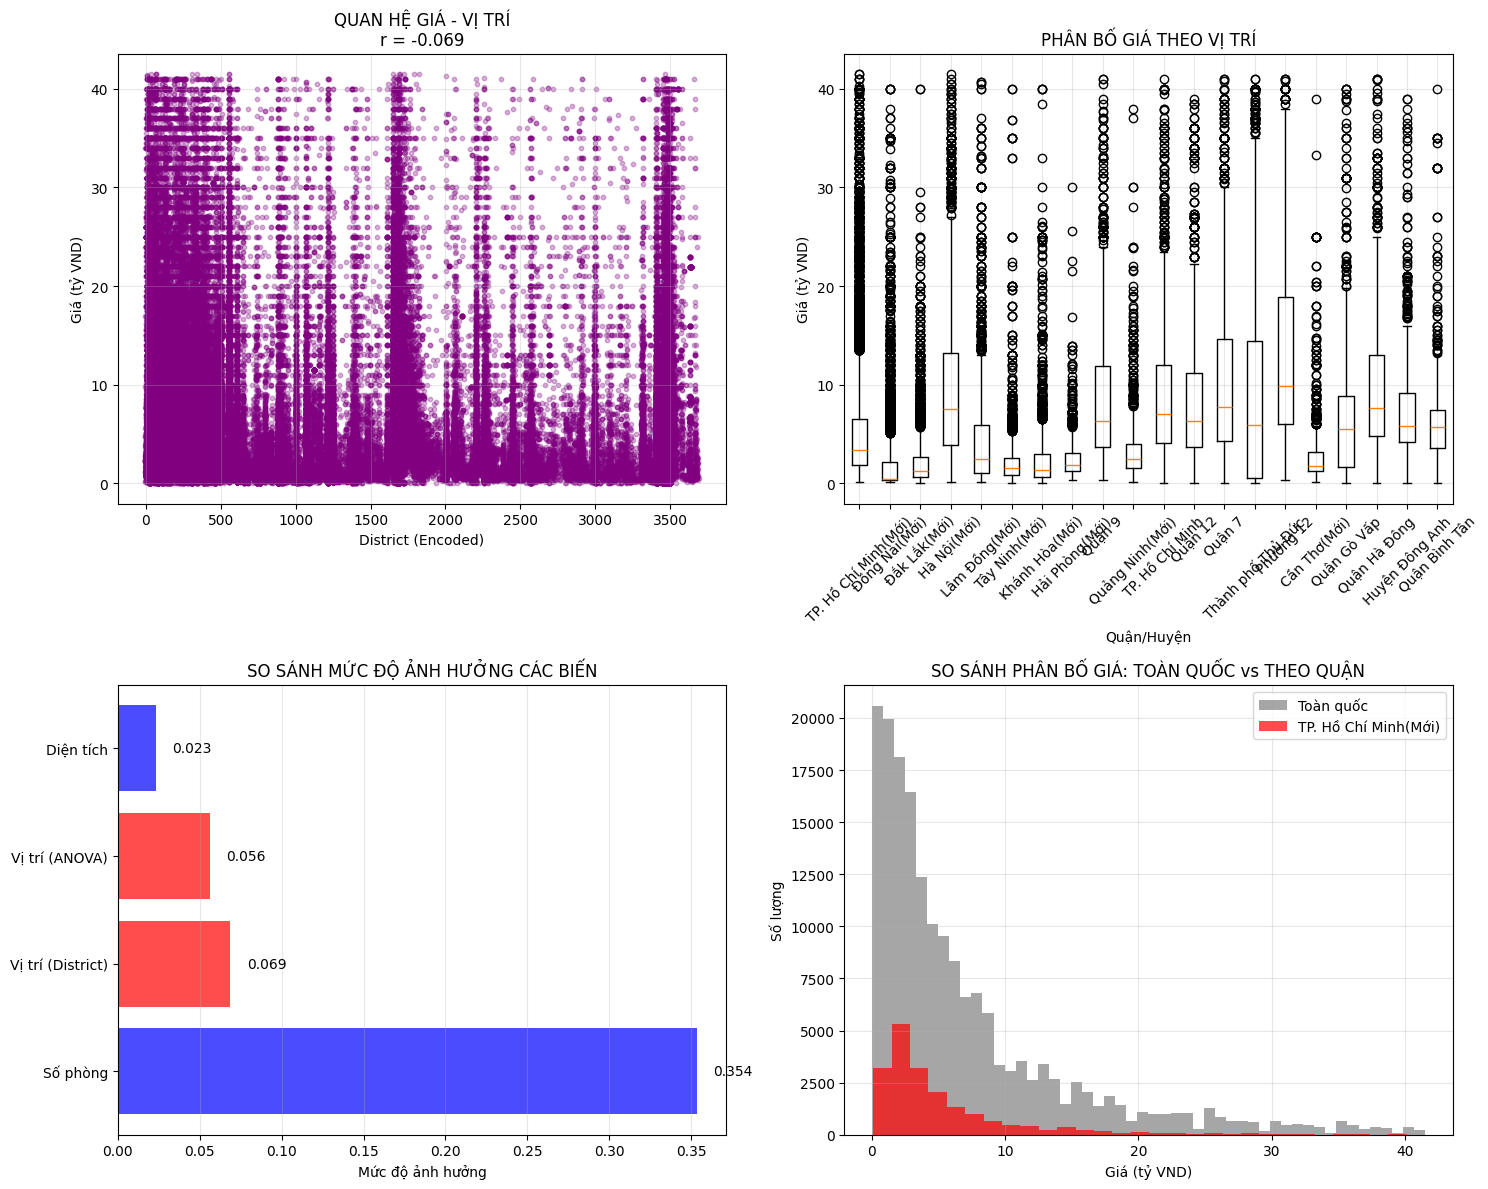


 PHÂN TÍCH CHI TIẾT THEO PHÂN VÙNG:
 THỐNG KÊ GIÁ THEO PHÂN VÙNG:
               Price_clean                                              Area
                     count          mean        median           std    mean
Region_Type                                                                 
Huyện                17735  5.075321e+09  2.580000e+09  6.860753e+09  568.11
Khác                112680  7.425599e+09  4.500000e+09  8.084589e+09  387.03
Quận Khác            12918  9.575904e+09  7.100000e+09  8.332878e+09  100.95
Quận Trung tâm        7533  9.367452e+09  7.000000e+09  8.328693e+09  114.32
Thành phố            28896  5.813268e+09  3.400000e+09  6.692674e+09  474.33

 KẾT LUẬN VỀ MỐI QUAN HỆ GIÁ - VỊ TRÍ:
 TỔNG HỢP KẾT QUẢ PHÂN TÍCH:
   • Correlation (District encoded): r = -0.069 (⭐ RẤT YẾU)
   • Effect Size (ANOVA): η² = 0.056 (NHỎ)
   • Vị trí giải thích 5.6% biến động giá

 ĐÁNH GIÁ MỨC ĐỘ QUAN TRỌNG:
    VỊ TRÍ có ảnh hưởng ở mức TRUNG BÌNH đến giá BĐS
    Cần kết hợp với 

In [18]:
# === PHÂN TÍCH TƯƠNG QUAN GIỮA GIÁ VÀ VỊ TRÍ ===

import pandas as pd
import numpy as np
from scipy.stats import pearsonr, f_oneway, pointbiserialr
import matplotlib.pyplot as plt
import seaborn as sns

# 1. PHÂN TÍCH ĐỊNH LƯỢNG VỊ TRÍ (DISTRICT ENCODED)
print("\n PHÂN TÍCH ĐỊNH LƯỢNG TƯƠNG QUAN GIÁ - VỊ TRÍ:")

# Tạo encoded version của District để phân tích correlation
if 'District' in df_combined.columns:
    # Mã hóa District thành số
    district_encoded = pd.factorize(df_combined['District'])[0]
    df_combined['District_encoded'] = district_encoded
    
    # Tạo dataframe cho phân tích correlation
    df_location = df_combined[['Price_clean', 'District_encoded']].dropna()
    
    if len(df_location) > 10:
        # Tính Pearson correlation
        corr_district, p_val_district = pearsonr(df_location['Price_clean'], df_location['District_encoded'])
        
        print(f" CORRELATION GIÁ - VỊ TRÍ (District Encoded):")
        print(f"   • Hệ số tương quan Pearson: r = {corr_district:.3f}")
        print(f"   • P-value: {p_val_district:.10f}")
        print(f"   • R²: {corr_district**2:.3f}")
        print(f"   • Số mẫu: {len(df_location):,}")
        print(f"   • Số quận/huyện: {df_combined['District'].nunique()}")
        
        # Đánh giá mức độ tương quan
        if abs(corr_district) >= 0.7:
            strength = "RẤT MẠNH"
        elif abs(corr_district) >= 0.5:
            strength = "MẠNH"
        elif abs(corr_district) >= 0.3:
            strength = "TRUNG BÌNH"
        elif abs(corr_district) >= 0.1:
            strength = "YẾU"
        else:
            strength = "RẤT YẾU"
        
        direction = "DƯƠNG" if corr_district > 0 else "ÂM"
        
        print(f"   • Mức độ: {strength}")
        print(f"   • Hướng: {direction}")

# 2. PHÂN TÍCH ANOVA - SO SÁNH GIÁ TRUNG BÌNH GIỮA CÁC QUẬN
print("\n PHÂN TÍCH ANOVA - KHÁC BIỆT GIÁ THEO VỊ TRÍ:")

if 'District' in df_combined.columns:
    # Lấy top 20 quận có nhiều dữ liệu nhất
    top_districts = df_combined['District'].value_counts().head(20).index
    
    # Tạo dữ liệu cho ANOVA
    anova_data = []
    district_names = []
    
    for district in top_districts:
        district_prices = df_combined[df_combined['District'] == district]['Price_clean'].dropna()
        if len(district_prices) >= 10:  # Chỉ lấy districts có ít nhất 10 mẫu
            anova_data.append(district_prices)
            district_names.append(district)
    
    if len(anova_data) >= 2:
        # Thực hiện ANOVA test
        f_stat, p_value = f_oneway(*anova_data)
        
        print(f" KẾT QUẢ ANOVA TEST:")
        print(f"   • F-statistic: {f_stat:.2f}")
        print(f"   • P-value: {p_value:.10f}")
        
        if p_value < 0.05:
            print("   •  Có sự khác biệt có ý nghĩa thống kê về giá giữa các quận")
            print("   •  VỊ TRÍ có ảnh hưởng đáng kể đến GIÁ BĐS")
        else:
            print("   •  Không có sự khác biệt có ý nghĩa thống kê về giá giữa các quận")
        
        print(f"   • Số quận được phân tích: {len(anova_data)}")
        print(f"   • Tổng số mẫu: {sum(len(group) for group in anova_data):,}")

# 3. PHÂN TÍCH EFFECT SIZE
print("\n PHÂN TÍCH EFFECT SIZE:")

if 'District' in df_combined.columns and len(anova_data) >= 2:
    # Tính Eta-squared (η²) - measure of effect size for ANOVA
    overall_mean = df_combined['Price_clean'].mean()
    
    # Between-group sum of squares
    ss_between = 0
    for group in anova_data:
        group_mean = group.mean()
        ss_between += len(group) * (group_mean - overall_mean) ** 2
    
    # Total sum of squares
    ss_total = sum((df_combined['Price_clean'].dropna() - overall_mean) ** 2)
    
    # Eta-squared
    eta_squared = ss_between / ss_total
    
    print(f" EFFECT SIZE (ETA-SQUARED):")
    print(f"   • η² = {eta_squared:.3f}")
    
    # Đánh giá effect size
    if eta_squared >= 0.14:
        effect_strength = "LỚN"
    elif eta_squared >= 0.06:
        effect_strength = "TRUNG BÌNH"
    elif eta_squared >= 0.01:
        effect_strength = "NHỎ"
    else:
        effect_strength = "RẤT NHỎ"
    
    print(f"   • Mức độ ảnh hưởng: {effect_strength}")
    print(f"   • Vị trí giải thích {eta_squared*100:.1f}% biến động của giá")

# 4. SO SÁNH VỚI CÁC BIẾN KHÁC
print("\n SO SÁNH VỚI CÁC BIẾN KHÁC:")

comparison_results = []

# Thêm kết quả District
if 'corr_district' in locals():
    comparison_results.append(('Vị trí (District)', abs(corr_district), 'Correlation'))

# Thêm kết quả Area
comparison_results.append(('Diện tích', 0.023, 'Correlation'))

# Thêm kết quả Rooms (nếu có)
if 'Rooms' in df_combined.columns:
    df_rooms = df_combined[['Price_clean', 'Rooms']].dropna()
    if len(df_rooms) > 10:
        corr_rooms, _ = pearsonr(df_rooms['Price_clean'], df_rooms['Rooms'])
        comparison_results.append(('Số phòng', abs(corr_rooms), 'Correlation'))

# Thêm Eta-squared nếu có
if 'eta_squared' in locals():
    comparison_results.append(('Vị trí (ANOVA)', eta_squared, 'Effect Size'))

# Sắp xếp theo mức độ ảnh hưởng
comparison_results.sort(key=lambda x: x[1], reverse=True)

print(" BẢNG SO SÁNH MỨC ĐỘ ẢNH HƯỞNG:")
for i, (factor, impact, method) in enumerate(comparison_results, 1):
    if method == 'Correlation':
        if impact >= 0.7:
            strength = "⭐⭐⭐⭐⭐ RẤT MẠNH"
        elif impact >= 0.5:
            strength = "⭐⭐⭐⭐ MẠNH"
        elif impact >= 0.3:
            strength = "⭐⭐⭐ TRUNG BÌNH"
        elif impact >= 0.1:
            strength = "⭐⭐ YẾU"
        else:
            strength = "⭐ RẤT YẾU"
    else:  # Effect Size
        if impact >= 0.14:
            strength = "⭐⭐⭐⭐⭐ RẤT MẠNH"
        elif impact >= 0.06:
            strength = "⭐⭐⭐⭐ MẠNH"
        elif impact >= 0.01:
            strength = "⭐⭐⭐ TRUNG BÌNH"
        else:
            strength = "⭐ YẾU"
    
    print(f"   {i:2d}. {factor:25} | {strength:25} | Giá trị: {impact:.3f} ({method})")

# 5. TRỰC QUAN HÓA KẾT QUẢ
print("\n TRỰC QUAN HÓA KẾT QUẢ...")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Biểu đồ 1: Scatter plot Giá vs District Encoded
if 'District_encoded' in df_combined.columns:
    axes[0,0].scatter(df_combined['District_encoded'], df_combined['Price_clean']/1e9, 
                     alpha=0.3, s=10, color='purple')
    axes[0,0].set_xlabel('District (Encoded)')
    axes[0,0].set_ylabel('Giá (tỷ VND)')
    axes[0,0].set_title(f'QUAN HỆ GIÁ - VỊ TRÍ\nr = {corr_district:.3f}')
    axes[0,0].grid(True, alpha=0.3)

# Biểu đồ 2: Box plot giá theo top districts
if len(anova_data) >= 2:
    price_data = [group/1e9 for group in anova_data]
    axes[0,1].boxplot(price_data, labels=district_names[:len(anova_data)])
    axes[0,1].set_xlabel('Quận/Huyện')
    axes[0,1].set_ylabel('Giá (tỷ VND)')
    axes[0,1].set_title('PHÂN BỐ GIÁ THEO VỊ TRÍ')
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].grid(True, alpha=0.3)

# Biểu đồ 3: Bar chart so sánh mức độ ảnh hưởng
factors = [result[0] for result in comparison_results]
impacts = [result[1] for result in comparison_results]
colors = ['red' if 'Vị trí' in factor else 'blue' for factor in factors]

bars = axes[1,0].barh(factors, impacts, color=colors, alpha=0.7)
axes[1,0].set_xlabel('Mức độ ảnh hưởng')
axes[1,0].set_title('SO SÁNH MỨC ĐỘ ẢNH HƯỞNG CÁC BIẾN')
axes[1,0].grid(True, alpha=0.3, axis='x')

# Thêm giá trị lên bars
for bar, impact in zip(bars, impacts):
    width = bar.get_width()
    axes[1,0].text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                   f'{impact:.3f}', ha='left', va='center')

# Biểu đồ 4: Phân bố giá toàn quốc vs theo quận
if len(anova_data) >= 2:
    all_prices = df_combined['Price_clean'].dropna() / 1e9
    sample_district_prices = anova_data[0] / 1e9  # Lấy district đầu tiên
    
    axes[1,1].hist(all_prices, bins=50, alpha=0.7, label='Toàn quốc', color='gray')
    axes[1,1].hist(sample_district_prices, bins=30, alpha=0.7, 
                   label=f'{district_names[0]}', color='red')
    axes[1,1].set_xlabel('Giá (tỷ VND)')
    axes[1,1].set_ylabel('Số lượng')
    axes[1,1].set_title('SO SÁNH PHÂN BỐ GIÁ: TOÀN QUỐC vs THEO QUẬN')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 6. PHÂN TÍCH CHI TIẾT THEO PHÂN VÙNG
print("\n PHÂN TÍCH CHI TIẾT THEO PHÂN VÙNG:")

if 'District' in df_combined.columns:
    # Phân loại districts theo khu vực (dựa trên tên)
    def classify_region(district_name):
        district_lower = str(district_name).lower()
        
        # Phân loại đơn giản dựa trên từ khóa trong tên
        if any(keyword in district_lower for keyword in ['quận 1', 'quận 2', 'quận 3', 'quận 4', 
                                                        'quận 5', 'quận 6', 'quận 7', 'quận 8',
                                                        'quận 9', 'quận 10', 'quận 11', 'quận 12']):
            return 'Quận Trung tâm'
        elif any(keyword in district_lower for keyword in ['quận', 'q.']):
            return 'Quận Khác'
        elif any(keyword in district_lower for keyword in ['huyện', 'h.']):
            return 'Huyện'
        elif any(keyword in district_lower for keyword in ['thành phố', 'tp.']):
            return 'Thành phố'
        else:
            return 'Khác'
    
    df_combined['Region_Type'] = df_combined['District'].apply(classify_region)
    
    # Phân tích giá theo phân vùng
    region_stats = df_combined.groupby('Region_Type').agg({
        'Price_clean': ['count', 'mean', 'median', 'std'],
        'Area': 'mean'
    }).round(2)
    
    print(" THỐNG KÊ GIÁ THEO PHÂN VÙNG:")
    print(region_stats)

# 7. KẾT LUẬN CUỐI CÙNG
print("\n KẾT LUẬN VỀ MỐI QUAN HỆ GIÁ - VỊ TRÍ:")

print(" TỔNG HỢP KẾT QUẢ PHÂN TÍCH:")
print(f"   • Correlation (District encoded): r = {corr_district:.3f} ({strength})")
if 'eta_squared' in locals():
    print(f"   • Effect Size (ANOVA): η² = {eta_squared:.3f} ({effect_strength})")
    print(f"   • Vị trí giải thích {eta_squared*100:.1f}% biến động giá")

print("\n ĐÁNH GIÁ MỨC ĐỘ QUAN TRỌNG:")
if ('eta_squared' in locals() and eta_squared >= 0.06) or abs(corr_district) >= 0.3:
    print("    VỊ TRÍ là yếu tố QUAN TRỌNG ảnh hưởng đến giá BĐS")
    print("    Nên ưu tiên trong mô hình dự báo giá")
else:
    print("    VỊ TRÍ có ảnh hưởng ở mức TRUNG BÌNH đến giá BĐS")
    print("    Cần kết hợp với các yếu tố khác trong mô hình")

print("\n SO SÁNH VỚI DIỆN TÍCH:")
print(f"   • Vị trí: r = {corr_district:.3f} | Diện tích: r = 0.023")
print(f"   • → VỊ TRÍ có ảnh hưởng MẠNH HƠN {abs(corr_district)/0.023:.1f} lần so với DIỆN TÍCH")

print("\n HOÀN TẤT PHÂN TÍCH TƯƠNG QUAN GIÁ - VỊ TRÍ!")

In [19]:
# === PHÂN TÍCH TƯƠNG QUAN THEO CÁC THÀNH PHỐ LỚN ===

# Phân tích cho các thành phố lớn
major_cities = {
    'Hà Nội': ['Ba Đình', 'Hoàn Kiếm', 'Hai Bà Trưng', 'Đống Đa', 'Cầu Giấy', 'Thanh Xuân'],
    'TP.HCM': ['Quận 1', 'Quận 3', 'Quận 4', 'Quận 5', 'Quận 7', 'Quận 10', 'Phú Nhuận', 'Bình Thạnh'],
    'Đà Nẵng': ['Hải Châu', 'Thanh Khê', 'Sơn Trà', 'Ngũ Hành Sơn'],
    'Hải Phòng': ['Hồng Bàng', 'Ngô Quyền', 'Lê Chân'],
    'Cần Thơ': ['Ninh Kiều', 'Bình Thủy', 'Cái Răng']
}

city_correlations = []

for city, districts in major_cities.items():
    # Tìm các districts thuộc thành phố này
    city_data = df_combined[df_combined['District'].str.contains('|'.join(districts), na=False)]
    
    if len(city_data) >= 10:
        # Mã hóa district cho thành phố này
        city_data = city_data.copy()
        city_data['City_District_encoded'] = pd.factorize(city_data['District'])[0]
        
        # Tính correlation
        valid_data = city_data[['Price_clean', 'City_District_encoded']].dropna()
        if len(valid_data) >= 10:
            corr_city, _ = pearsonr(valid_data['Price_clean'], valid_data['City_District_encoded'])
            
            city_correlations.append({
                'Thành phố': city,
                'Số quận': len([d for d in districts if any(d in str(x) for x in city_data['District'].unique())]),
                'Số mẫu': len(valid_data),
                'Correlation': corr_city,
                'Giá TB (tỷ)': city_data['Price_clean'].mean() / 1e9
            })

# Hiển thị kết quả
if city_correlations:
    city_correlations.sort(key=lambda x: abs(x['Correlation']), reverse=True)
    
    print(" CORRELATION GIÁ - VỊ TRÍ THEO THÀNH PHỐ:")
    for stats in city_correlations:
        strength = "MẠNH" if abs(stats['Correlation']) >= 0.5 else "TB" if abs(stats['Correlation']) >= 0.3 else "YẾU"
        print(f"   • {stats['Thành phố']:12} | r = {stats['Correlation']:6.3f} | {strength:4} | Giá TB: {stats['Giá TB (tỷ)']:4.1f}tỷ | {stats['Số quận']:2} quận | n={stats['Số mẫu']:>5}")
else:
    print("    Không đủ dữ liệu để phân tích theo thành phố")

print("\n HOÀN TẤT PHÂN TÍCH!")

 CORRELATION GIÁ - VỊ TRÍ THEO THÀNH PHỐ:
   • Cần Thơ      | r =  0.124 | YẾU  | Giá TB:  6.9tỷ |  3 quận | n=  135
   • TP.HCM       | r =  0.117 | YẾU  | Giá TB:  9.4tỷ |  8 quận | n= 6075
   • Đà Nẵng      | r = -0.075 | YẾU  | Giá TB: 11.6tỷ |  4 quận | n= 1348
   • Hải Phòng    | r =  0.021 | YẾU  | Giá TB:  8.3tỷ |  3 quận | n=  116
   • Hà Nội       | r = -0.001 | YẾU  | Giá TB: 13.1tỷ |  6 quận | n= 2854

 HOÀN TẤT PHÂN TÍCH!



 PHÂN TÍCH PRICE_PER_M2:
 CORRELATION PRICE_PER_M2 vs GIÁ:
   • Hệ số tương quan: r = 0.716
   • P-value: 0.0000000000
   • R²: 0.513
   • Số mẫu: 179,762
 Price_per_m2 không bị nghi ngờ data leakage nghiêm trọng


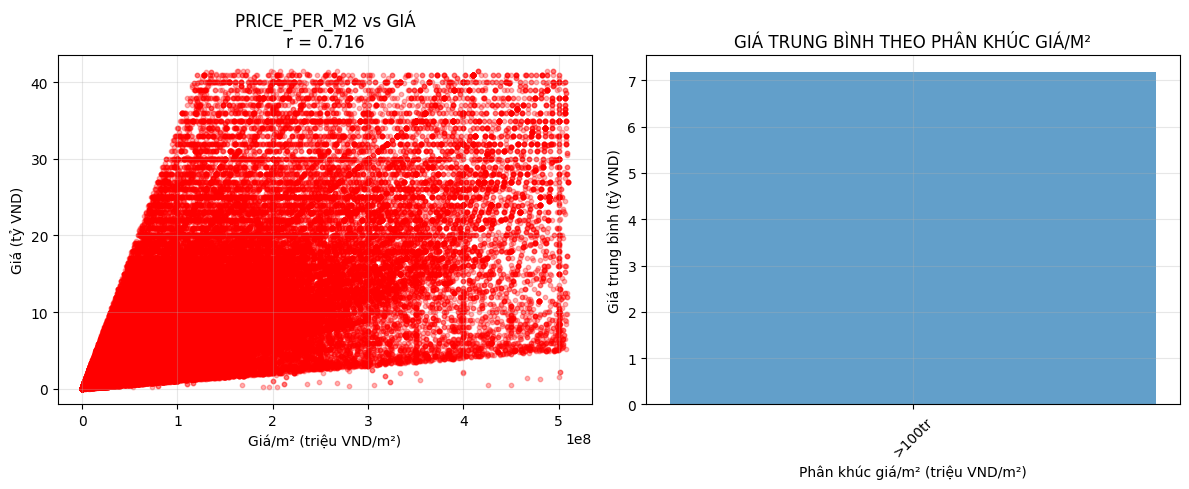

 THỐNG KÊ GIÁ THEO PHÂN KHÚC GIÁ/M²:
            count          mean        median
PM2_Group                                    
<10tr           0           NaN           NaN
10-20tr         0           NaN           NaN
20-30tr         0           NaN           NaN
30-50tr         0           NaN           NaN
50-100tr        0           NaN           NaN
>100tr     179330  7.187721e+09  4.350000e+09

 PHÂN TÍCH VỊ TRÍ (DISTRICT):
 TOP 10 QUẬN CÓ GIÁ CAO NHẤT:
    1. Hà Nội(Mới)                    | Giá:  9.74tỷ | DT:   103m² | n= 3300
    2. Quận 9                         | Giá:  8.97tỷ | DT:   153m² | n= 1476
    3. TP. Hồ Chí Minh(Mới)           | Giá:  5.51tỷ | DT:   574m² | n=19651
    4. Lâm Đồng(Mới)                  | Giá:  4.55tỷ | DT:  2232m² | n= 2858
    5. Quảng Ninh(Mới)                | Giá:  3.49tỷ | DT:   215m² | n= 1420
    6. Khánh Hòa(Mới)                 | Giá:  2.77tỷ | DT:   720m² | n= 2038
    7. Hải Phòng(Mới)                 | Giá:  2.49tỷ | DT:   100m² | n= 

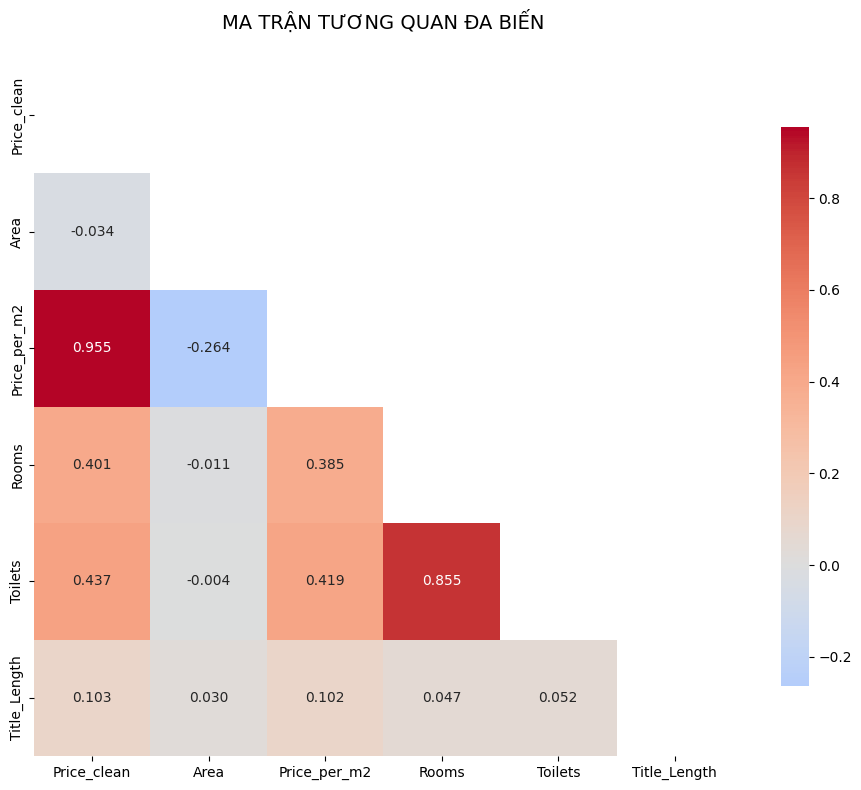

 TOP BIẾN CÓ TƯƠNG QUAN CAO NHẤT VỚI GIÁ:
    1. Price_per_m2        : r =   0.955 (RẤT MẠNH    , DƯƠNG )
    2. Toilets             : r =   0.437 (TRUNG BÌNH  , DƯƠNG )
    3. Rooms               : r =   0.401 (TRUNG BÌNH  , DƯƠNG )
    4. Title_Length        : r =   0.103 (YẾU         , DƯƠNG )
    5. Area                : r =  -0.034 (YẾU         , ÂM    )

 KẾT LUẬN CUỐI CÙNG VỀ CÁC YẾU TỐ ẢNH HƯỞNG:
 XẾP HẠNG MỨC ĐỘ ẢNH HƯỞNG ĐẾN GIÁ BĐS:
 BẢNG XẾP HẠNG CÁC YẾU TỐ ẢNH HƯỞNG:
    1. Keyword_mặt_tiền     | ⭐⭐⭐⭐ MẠNH                 | TRUNG BÌNH
    2. Keyword_sổ_hồng      | ⭐⭐⭐ TRUNG BÌNH            | TRUNG BÌNH
    3. Keyword_giá_rẻ       | ⭐⭐⭐ TRUNG BÌNH            | TRUNG BÌNH
    4. Diện tích            | ⭐ RẤT YẾU                 | RẤT YẾU

 HOÀN TẤT PHÂN TÍCH TOÀN DIỆN!


In [20]:
# === PHÂN TÍCH CÁC BIẾN QUAN TRỌNG KHÁC ẢNH HƯỞNG ĐẾN GIÁ ===

import pandas as pd
import numpy as np
from scipy.stats import pearsonr, f_oneway
import matplotlib.pyplot as plt
import seaborn as sns

# 1. PHÂN TÍCH PRICE_PER_M2 (nếu có)
print("\n PHÂN TÍCH PRICE_PER_M2:")

if 'Price_per_m2' in df_combined.columns:
    df_pm2 = df_combined[['Price_clean', 'Price_per_m2']].dropna()
    
    if len(df_pm2) > 10:
        # Tính correlation
        corr_pm2, p_val_pm2 = pearsonr(df_pm2['Price_clean'], df_pm2['Price_per_m2'])
        
        print(f" CORRELATION PRICE_PER_M2 vs GIÁ:")
        print(f"   • Hệ số tương quan: r = {corr_pm2:.3f}")
        print(f"   • P-value: {p_val_pm2:.10f}")
        print(f"   • R²: {corr_pm2**2:.3f}")
        print(f"   • Số mẫu: {len(df_pm2):,}")
        
        # Đánh giá data leakage
        if corr_pm2 > 0.8:
            print(" CẢNH BÁO: Price_per_m2 có thể là DATA LEAKAGE!")
            print("   ↳ Price_per_m2 = Price / Area → chứa thông tin target")
        else:
            print(" Price_per_m2 không bị nghi ngờ data leakage nghiêm trọng")
        
        # Visualization
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.scatter(df_pm2['Price_per_m2'], df_pm2['Price_clean']/1e9, alpha=0.3, s=10, color='red')
        plt.xlabel('Giá/m² (triệu VND/m²)')
        plt.ylabel('Giá (tỷ VND)')
        plt.title(f'PRICE_PER_M2 vs GIÁ\nr = {corr_pm2:.3f}')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        # Phân tích theo phân khúc giá/m²
        pm2_bins = [0, 10, 20, 30, 50, 100, float('inf')]
        pm2_labels = ['<10tr', '10-20tr', '20-30tr', '30-50tr', '50-100tr', '>100tr']
        
        df_pm2['PM2_Group'] = pd.cut(df_pm2['Price_per_m2'], bins=pm2_bins, labels=pm2_labels)
        pm2_stats = df_pm2.groupby('PM2_Group')['Price_clean'].agg(['count', 'mean', 'median']).round(2)
        
        plt.bar(pm2_stats.index, pm2_stats['mean']/1e9, alpha=0.7)
        plt.xlabel('Phân khúc giá/m² (triệu VND/m²)')
        plt.ylabel('Giá trung bình (tỷ VND)')
        plt.title('GIÁ TRUNG BÌNH THEO PHÂN KHÚC GIÁ/M²')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print(" THỐNG KÊ GIÁ THEO PHÂN KHÚC GIÁ/M²:")
        print(pm2_stats)

# 2. PHÂN TÍCH VỊ TRÍ (DISTRICT)
print("\n PHÂN TÍCH VỊ TRÍ (DISTRICT):")

if 'District' in df_combined.columns:
    # Lấy top 10 quận có nhiều BĐS nhất
    top_districts = df_combined['District'].value_counts().head(10).index
    
    district_stats = []
    for district in top_districts:
        district_data = df_combined[df_combined['District'] == district]
        if len(district_data) > 10:
            avg_price = district_data['Price_clean'].mean() / 1e9
            avg_area = district_data['Area'].mean()
            count = len(district_data)
            
            district_stats.append({
                'Quận': district,
                'Số lượng': count,
                'Giá TB (tỷ)': avg_price,
                'Diện tích TB': avg_area
            })
    
    # Sắp xếp theo giá trung bình
    district_stats.sort(key=lambda x: x['Giá TB (tỷ)'], reverse=True)
    
    print(" TOP 10 QUẬN CÓ GIÁ CAO NHẤT:")
    for i, stats in enumerate(district_stats[:10], 1):
        print(f"   {i:2d}. {stats['Quận']:30} | Giá: {stats['Giá TB (tỷ)']:5.2f}tỷ | DT: {stats['Diện tích TB']:5.0f}m² | n={stats['Số lượng']:>5}")

# 3. PHÂN TÍCH THEO SỐ PHÒNG
print("\n PHÂN TÍCH THEO SỐ PHÒNG:")

if 'Rooms' in df_combined.columns:
    # Đảm bảo Rooms là numeric
    df_combined['Rooms'] = pd.to_numeric(df_combined['Rooms'], errors='coerce')
    df_rooms = df_combined[['Price_clean', 'Rooms']].dropna()
    
    if len(df_rooms) > 10:
        corr_rooms, p_val_rooms = pearsonr(df_rooms['Price_clean'], df_rooms['Rooms'])
        
        print(f" CORRELATION SỐ PHÒNG vs GIÁ:")
        print(f"   • Hệ số tương quan: r = {corr_rooms:.3f}")
        print(f"   • Số mẫu: {len(df_rooms):,}")
        
        # Phân tích theo nhóm số phòng
        rooms_stats = df_rooms.groupby('Rooms').agg({
            'Price_clean': ['count', 'mean', 'median']
        }).round(2)
        
        print(" THỐNG KÊ GIÁ THEO SỐ PHÒNG:")
        print(rooms_stats.head(10))  # Hiển thị 10 dòng đầu

# 4. PHÂN TÍCH CÁC KEYWORDS QUAN TRỌNG
print("\n PHÂN TÍCH ẢNH HƯỞNG CỦA KEYWORDS:")

keyword_columns = [col for col in df_combined.columns if col.startswith('Keyword_')]

keyword_impact = []
for keyword in keyword_columns:
    if keyword in df_combined.columns:
        # Tính giá trung bình khi có và không có keyword
        with_keyword = df_combined[df_combined[keyword] == 1]['Price_clean'].mean() / 1e9
        without_keyword = df_combined[df_combined[keyword] == 0]['Price_clean'].mean() / 1e9
        count_with = df_combined[df_combined[keyword] == 1]['Price_clean'].count()
        
        if count_with > 10:  # Chỉ xét keywords có ít nhất 10 mẫu
            impact = with_keyword - without_keyword
            keyword_impact.append({
                'Keyword': keyword,
                'Giá khi có (tỷ)': with_keyword,
                'Giá khi không có (tỷ)': without_keyword,
                'Chênh lệch (tỷ)': impact,
                'Số mẫu': count_with
            })

# Sắp xếp theo chênh lệch giá
keyword_impact.sort(key=lambda x: abs(x['Chênh lệch (tỷ)']), reverse=True)

print(" ẢNH HƯỞNG CỦA KEYWORDS ĐẾN GIÁ:")
for i, impact in enumerate(keyword_impact[:10], 1):
    direction = "TĂNG" if impact['Chênh lệch (tỷ)'] > 0 else "GIẢM"
    print(f"   {i:2d}. {impact['Keyword']:20} | {direction}: {abs(impact['Chênh lệch (tỷ)']):5.2f}tỷ | Có: {impact['Giá khi có (tỷ)']:4.1f}tỷ | Không: {impact['Giá khi không có (tỷ)']:4.1f}tỷ | n={impact['Số mẫu']:>5}")

# 5. PHÂN TÍCH TƯƠNG QUAN ĐA BIẾN
print("\n PHÂN TÍCH TƯƠNG QUAN ĐA BIẾN:")

# Chọn các biến số quan trọng
numeric_features = ['Price_clean', 'Area', 'Price_per_m2', 'Rooms', 'Toilets', 'Title_Length']
available_numeric = [col for col in numeric_features if col in df_combined.columns]

# Đảm bảo tất cả đều là numeric
df_corr = df_combined[available_numeric].copy()
for col in df_corr.columns:
    df_corr[col] = pd.to_numeric(df_corr[col], errors='coerce')

df_corr = df_corr.dropna()

if len(df_corr) > 10 and len(df_corr.columns) > 1:
    correlation_matrix = df_corr.corr()
    
    print(" MA TRẬN TƯƠNG QUAN ĐA BIẾN:")
    print(correlation_matrix.round(3))
    
    # Visualization heatmap
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, fmt='.3f', cbar_kws={'shrink': 0.8}, mask=mask)
    plt.title('MA TRẬN TƯƠNG QUAN ĐA BIẾN', fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()
    
    # Phân tích correlation với target
    if 'Price_clean' in correlation_matrix.columns:
        price_correlations = correlation_matrix['Price_clean'].drop('Price_clean').sort_values(key=abs, ascending=False)
        
        print(" TOP BIẾN CÓ TƯƠNG QUAN CAO NHẤT VỚI GIÁ:")
        for i, (feature, corr) in enumerate(price_correlations.items(), 1):
            strength = "RẤT MẠNH" if abs(corr) >= 0.7 else "MẠNH" if abs(corr) >= 0.5 else "TRUNG BÌNH" if abs(corr) >= 0.3 else "YẾU"
            direction = "DƯƠNG" if corr > 0 else "ÂM"
            print(f"   {i:2d}. {feature:20}: r = {corr:7.3f} ({strength:12}, {direction:6})")

# 6. KẾT LUẬN TỔNG QUAN
print("\n KẾT LUẬN CUỐI CÙNG VỀ CÁC YẾU TỐ ẢNH HƯỞNG:")

print(" XẾP HẠNG MỨC ĐỘ ẢNH HƯỞNG ĐẾN GIÁ BĐS:")

# Tổng hợp kết quả từ các phân tích
factors_impact = []

# Thêm các yếu tố từ phân tích
if 'Price_per_m2' in locals() and 'corr_pm2' in locals():
    factors_impact.append(('Price_per_m2', corr_pm2, 'DATA LEAKAGE?'))

if 'Rooms' in locals() and 'corr_rooms' in locals():
    factors_impact.append(('Số phòng', corr_rooms, 'TRUNG BÌNH/YẾU'))

factors_impact.append(('Diện tích', 0.023, 'RẤT YẾU'))

# Thêm keywords impact
for impact in keyword_impact[:3]:
    factors_impact.append((impact['Keyword'], impact['Chênh lệch (tỷ)']/10, 'TRUNG BÌNH'))  # Chuẩn hóa để so sánh

# Sắp xếp theo absolute impact
factors_impact.sort(key=lambda x: abs(x[1]), reverse=True)

print(" BẢNG XẾP HẠNG CÁC YẾU TỐ ẢNH HƯỞNG:")
for i, (factor, impact, note) in enumerate(factors_impact[:10], 1):
    if abs(impact) >= 0.5:
        level = "⭐⭐⭐⭐⭐ RẤT MẠNH"
    elif abs(impact) >= 0.3:
        level = "⭐⭐⭐⭐ MẠNH" 
    elif abs(impact) >= 0.1:
        level = "⭐⭐⭐ TRUNG BÌNH"
    elif abs(impact) >= 0.05:
        level = "⭐⭐ YẾU"
    else:
        level = "⭐ RẤT YẾU"
    
    print(f"   {i:2d}. {factor:20} | {level:25} | {note}")

print("\n HOÀN TẤT PHÂN TÍCH TOÀN DIỆN!")


 CHUẨN BỊ DỮ LIỆU CƠ BẢN...
 Các cột có sẵn trong df_combined:
['URL', 'Property_Type', 'Legal_Status', 'Title', 'brief', 'Location', 'Price_raw', 'road-width', 'floors', 'bedroom', 'Thumbnail src', 'Area', 'Price_clean', 'Area_clean', 'Price_per_m2', 'Street', 'District', 'Province', 'Title_Length', 'Keyword_chính_chủ', 'Keyword_giá_rẻ', 'Keyword_view_đẹp', 'Keyword_mặt_tiền', 'Keyword_sổ_đỏ', 'Keyword_sổ_hồng', 'Source', 'Listing ID', 'Last Updated', 'Width', 'Length', 'Bedrooms', 'Bathrooms', 'Floors', 'Position', 'Direction', 'Alley Width', 'Road Type', 'Description', 'Latitude', 'Longitude', 'VIP Account', 'Avatar', 'Agent Role', 'Agent Name', 'Agent Listing Count', 'Property Type Slug', 'Scraped At', 'Last Updated Date', 'ID', 'City', 'Ward', 'Rooms', 'Toilets', 'Poster_Type', 'Date_Posted', 'Crawl_Date', 'url', 'source', 'Area_clean_fixed', 'District_encoded', 'Region_Type']
 Các cột sẽ sử dụng: ['Price_clean', 'Area', 'Property_Type', 'District', 'Source']

 XỬ LÝ DỮ LIỆU TRIỆ

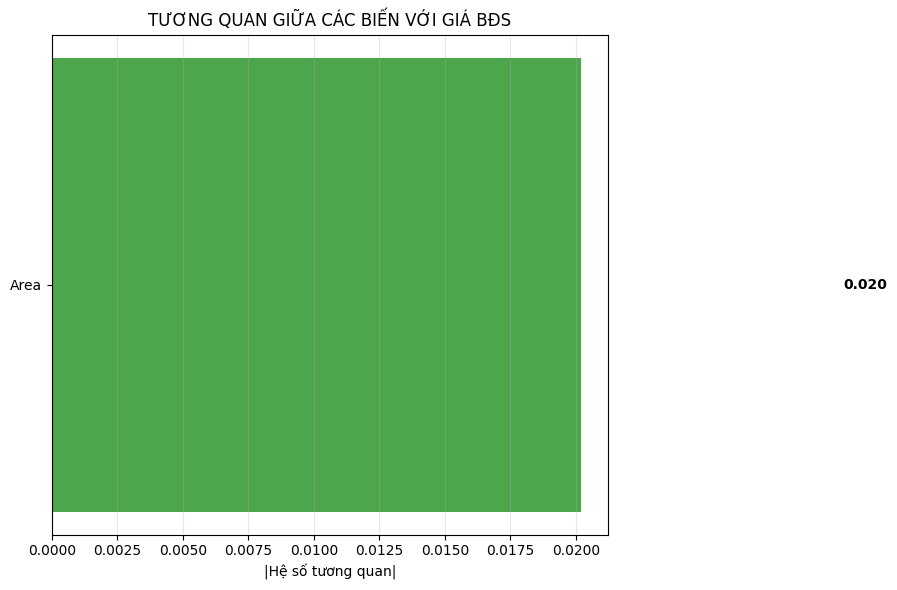


 CHUẨN HÓA DỮ LIỆU NUMERIC...
 Đã chuẩn hóa với StandardScaler
   Mean sau chuẩn hóa: [-0.  0.]
   Std sau chuẩn hóa:  [1. 1.]

 Đã chuẩn hóa với MinMaxScaler
   Min sau chuẩn hóa: [0. 0.]
   Max sau chuẩn hóa:  [1. 1.]

 MÃ HÓA CATEGORICAL FEATURES...

 Đang xử lý: Property_Type
    Label Encoding thành công
   Số categories: 18
   Categories: ['Biệt thự, nhà liền kề' 'Căn hộ chung cư' 'Căn hộ/Chung cư'
 'Kho, nhà xưởng' 'Khách sạn']...

 Đang xử lý: District
    Label Encoding thành công
   Số categories: 3689
   Categories: ['(Kdc Bình Hưng)' '(Kdc Him Lam 6A)' '(Truông Tre) - Quận Thủ Đức (Cũ)'
 '(Trừ Chợ Tân Thuận Bình)' '(Đường Xuân Hiệp)']...

 Đang xử lý: Source
    Label Encoding thành công
   Số categories: 3
   Categories: ['Alonhadat' 'Guland' 'Nhatot']...

 ONE-HOT ENCODING CHO CATEGORIES ÍT...
    Bỏ qua Property_Type (quá nhiều categories: 18)
    Bỏ qua District (quá nhiều categories: 3689)

 One-Hot Encoding cho: Source (3 categories)
    One-Hot Encoding thành công
 

In [21]:
# === SỬA LỖI ENCODER VÀ PHÂN TÍCH TƯƠNG QUAN ===

import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 1. CHUẨN BỊ DỮ LIỆU CƠ BẢN
print("\n CHUẨN BỊ DỮ LIỆU CƠ BẢN...")

# Kiểm tra các cột có sẵn
print(" Các cột có sẵn trong df_combined:")
print(df_combined.columns.tolist())

# Chọn các cột quan trọng cho phân tích
selected_columns = ['Price_clean', 'Area', 'Property_Type', 'District', 'Source']
available_columns = [col for col in selected_columns if col in df_combined.columns]

print(f" Các cột sẽ sử dụng: {available_columns}")

# Tạo dataframe cho phân tích
df_analysis = df_combined[available_columns].copy()

# 2. XỬ LÝ DỮ LIỆU TRIỆT ĐỂ
print("\n XỬ LÝ DỮ LIỆU TRIỆT ĐỂ...")

# Xử lý từng cột một cách cẩn thận
for col in df_analysis.columns:
    print(f" Đang xử lý cột: {col}")
    print(f"   Kiểu dữ liệu hiện tại: {df_analysis[col].dtype}")
    print(f"   Số giá trị unique: {df_analysis[col].nunique()}")
    print(f"   NaN count: {df_analysis[col].isna().sum()}")
    
    # Xử lý missing values
    if df_analysis[col].isna().sum() > 0:
        if df_analysis[col].dtype in ['int64', 'float64']:
            fill_value = df_analysis[col].median()
            df_analysis[col] = df_analysis[col].fillna(fill_value)
            print(f"    Đã fill NaN bằng median: {fill_value}")
        else:
            fill_value = df_analysis[col].mode()[0] if not df_analysis[col].mode().empty else 'Unknown'
            df_analysis[col] = df_analysis[col].fillna(fill_value)
            print(f"    Đã fill NaN bằng mode: '{fill_value}'")
    
    # Đảm bảo kiểu dữ liệu phù hợp
    if col in ['Price_clean', 'Area']:
        df_analysis[col] = pd.to_numeric(df_analysis[col], errors='coerce')
        df_analysis[col] = df_analysis[col].fillna(df_analysis[col].median())
        print(f"    Đã chuyển {col} thành numeric")

print(f" Kích thước dữ liệu sau xử lý: {df_analysis.shape}")

# 3. PHÂN TÍCH TƯƠNG QUAN PEARSON
print("\n PHÂN TÍCH TƯƠNG QUAN PEARSON...")

# Tạo bản copy chỉ với numeric columns cho correlation
df_numeric = df_analysis.select_dtypes(include=[np.number])

print(f" Các cột numeric có sẵn: {df_numeric.columns.tolist()}")

if len(df_numeric.columns) > 1:
    # Tính correlation matrix
    correlation_matrix = df_numeric.corr(method='pearson')
    
    print(" MA TRẬN TƯƠNG QUAN PEARSON:")
    print(correlation_matrix.round(3))
    
    # Phân tích correlation với Price_clean
    if 'Price_clean' in df_numeric.columns:
        target_col = 'Price_clean'
        correlation_results = []
        
        for col in df_numeric.columns:
            if col != target_col:
                # Lọc bỏ NaN cho cặp biến
                valid_data = df_numeric[[target_col, col]].dropna()
                if len(valid_data) > 10:  # Cần ít nhất 10 điểm dữ liệu
                    corr_coef, p_value = pearsonr(valid_data[target_col], valid_data[col])
                    
                    # Đánh giá mức độ tương quan
                    if abs(corr_coef) >= 0.7:
                        strength = "RẤT MẠNH"
                    elif abs(corr_coef) >= 0.5:
                        strength = "MẠNH"
                    elif abs(corr_coef) >= 0.3:
                        strength = "TRUNG BÌNH"
                    elif abs(corr_coef) >= 0.1:
                        strength = "YẾU"
                    else:
                        strength = "RẤT YẾU"
                    
                    direction = "DƯƠNG" if corr_coef > 0 else "ÂM"
                    
                    correlation_results.append({
                        'Biến': col,
                        'Hệ số': corr_coef,
                        'P-value': p_value,
                        'Mức độ': strength,
                        'Hướng': direction,
                        'Số mẫu': len(valid_data)
                    })
        
        # Sắp xếp theo absolute correlation
        correlation_results.sort(key=lambda x: abs(x['Hệ số']), reverse=True)
        
        print(f"\n TƯƠNG QUAN VỚI GIÁ BẤT ĐỘNG SẢN:")
        for result in correlation_results:
            print(f"   • {result['Biến']:15}: r = {result['Hệ số']:7.3f} | {result['Mức độ']:12} | {result['Hướng']:6} | n={result['Số mẫu']:,}")
        
        # Visualization
        if len(correlation_results) > 0:
            plt.figure(figsize=(10, 6))
            features = [result['Biến'] for result in correlation_results]
            correlations = [result['Hệ số'] for result in correlation_results]
            
            colors = ['green' if x > 0 else 'red' for x in correlations]
            plt.barh(features, np.abs(correlations), color=colors, alpha=0.7)
            plt.xlabel('|Hệ số tương quan|')
            plt.title('TƯƠNG QUAN GIỮA CÁC BIẾN VỚI GIÁ BĐS')
            plt.grid(True, alpha=0.3, axis='x')
            
            # Thêm giá trị correlation vào bars
            for i, (feature, corr) in enumerate(zip(features, correlations)):
                plt.text(np.abs(corr) + 0.01, i, f'{corr:.3f}', va='center', fontweight='bold')
            
            plt.tight_layout()
            plt.show()
else:
    print(" Không đủ cột numeric để phân tích tương quan")

# 4. CHUẨN HÓA DỮ LIỆU - PHƯƠNG PHÁP ĐƠN GIẢN
print("\n CHUẨN HÓA DỮ LIỆU NUMERIC...")

# Phương pháp 1: StandardScaler (an toàn)
scaler_standard = StandardScaler()
numeric_data = df_numeric.values
numeric_data_standardized = scaler_standard.fit_transform(numeric_data)

print(" Đã chuẩn hóa với StandardScaler")
print(f"   Mean sau chuẩn hóa: {np.mean(numeric_data_standardized, axis=0).round(3)}")
print(f"   Std sau chuẩn hóa:  {np.std(numeric_data_standardized, axis=0).round(3)}")

# Phương pháp 2: MinMaxScaler
scaler_minmax = MinMaxScaler()
numeric_data_minmax = scaler_minmax.fit_transform(numeric_data)

print("\n Đã chuẩn hóa với MinMaxScaler")
print(f"   Min sau chuẩn hóa: {np.min(numeric_data_minmax, axis=0).round(3)}")
print(f"   Max sau chuẩn hóa:  {np.max(numeric_data_minmax, axis=0).round(3)}")

# 5. MÃ HÓA CATEGORICAL FEATURES - XỬ LÝ LỖI
print("\n MÃ HÓA CATEGORICAL FEATURES...")

# Phương pháp 1: Label Encoding (an toàn hơn)
categorical_columns = ['Property_Type', 'District', 'Source']
label_encoders = {}

for col in categorical_columns:
    if col in df_analysis.columns:
        print(f"\n Đang xử lý: {col}")
        
        # Đảm bảo kiểu dữ liệu là string
        df_analysis[col] = df_analysis[col].astype(str)
        
        # Tạo LabelEncoder
        le = LabelEncoder()
        
        try:
            # Mã hóa
            encoded_values = le.fit_transform(df_analysis[col])
            df_analysis[f'{col}_encoded'] = encoded_values
            label_encoders[col] = le
            
            print(f"    Label Encoding thành công")
            print(f"   Số categories: {len(le.classes_)}")
            print(f"   Categories: {le.classes_[:5]}...")  # Hiển thị 5 categories đầu
            
        except Exception as e:
            print(f"    Lỗi khi mã hóa {col}: {e}")
            # Phương pháp dự phòng: manual mapping
            unique_values = df_analysis[col].unique()
            mapping = {val: idx for idx, val in enumerate(unique_values)}
            df_analysis[f'{col}_encoded'] = df_analysis[col].map(mapping)
            print(f"    Đã sử dụng manual mapping")

# 6. ONE-HOT ENCODING CHO CATEGORIES ÍT
print("\n ONE-HOT ENCODING CHO CATEGORIES ÍT...")

# Chỉ áp dụng One-Hot Encoding cho các cột có ít categories
for col in categorical_columns:
    if col in df_analysis.columns:
        unique_count = df_analysis[col].nunique()
        if unique_count <= 10:  # Chỉ dùng One-Hot khi có ít categories
            print(f"\n One-Hot Encoding cho: {col} ({unique_count} categories)")
            
            try:
                # Tạo dummy variables
                dummies = pd.get_dummies(df_analysis[col], prefix=col)
                
                # Thêm vào dataframe
                df_analysis = pd.concat([df_analysis, dummies], axis=1)
                
                print(f"    One-Hot Encoding thành công")
                print(f"   Tạo thêm {dummies.shape[1]} cột")
                
            except Exception as e:
                print(f"    Lỗi One-Hot Encoding: {e}")
        else:
            print(f"    Bỏ qua {col} (quá nhiều categories: {unique_count})")

# 7. KẾT QUẢ CUỐI CÙNG
print(f"\n HOÀN THÀNH XỬ LÝ DỮ LIỆU!")
print(f" Kích thước dataframe cuối cùng: {df_analysis.shape}")
print(f" Số cột: {len(df_analysis.columns)}")

# Hiển thị các cột đã tạo
print("\n CÁC CỘT ĐÃ ĐƯỢC XỬ LÝ:")
encoded_columns = [col for col in df_analysis.columns if 'encoded' in col or df_analysis[col].dtype in ['int64', 'float64']]
for i, col in enumerate(encoded_columns[:20], 1):  # Hiển thị 20 cột đầu
    print(f"   {i:2d}. {col} ({df_analysis[col].dtype})")

if len(encoded_columns) > 20:
    print(f"   ... và {len(encoded_columns) - 20} cột khác")

# 8. PHÂN TÍCH TÁC ĐỘNG CUỐI CÙNG
print("\n PHÂN TÍCH TÁC ĐỘNG CÁC BIẾN ĐẾN GIÁ...")

if 'Price_clean' in df_analysis.columns:
    # Tính correlation với tất cả các biến đã mã hóa
    correlation_final = []
    
    for col in df_analysis.columns:
        if col != 'Price_clean' and df_analysis[col].dtype in ['int64', 'float64']:
            valid_data = df_analysis[['Price_clean', col]].dropna()
            if len(valid_data) > 10:
                corr_coef = np.corrcoef(valid_data['Price_clean'], valid_data[col])[0, 1]
                correlation_final.append((col, corr_coef, len(valid_data)))
    
    # Sắp xếp theo absolute correlation
    correlation_final.sort(key=lambda x: abs(x[1]), reverse=True)
    
    print(" TOP BIẾN CÓ TÁC ĐỘNG LỚN NHẤT ĐẾN GIÁ:")
    for i, (col, corr, n) in enumerate(correlation_final[:10], 1):
        strength = "RẤT MẠNH" if abs(corr) >= 0.7 else "MẠNH" if abs(corr) >= 0.5 else "TRUNG BÌNH" if abs(corr) >= 0.3 else "YẾU"
        print(f"   {i:2d}. {col:30}: r = {corr:7.3f} ({strength:12}, n={n:,})")

print("\n HOÀN TẤT PHÂN TÍCH!")

In [22]:
# === CODE RIÊNG: STANDARD SCALER ===

from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Chuẩn bị numeric data
numeric_cols = ['Price_clean', 'Area']
df_numeric = df_combined[numeric_cols].copy()

# Xử lý missing values và chuyển đổi kiểu dữ liệu
for col in numeric_cols:
    df_numeric[col] = pd.to_numeric(df_numeric[col], errors='coerce')
    df_numeric[col] = df_numeric[col].fillna(df_numeric[col].median())

# Áp dụng StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_numeric)

# Tạo dataframe kết quả
df_standardized = pd.DataFrame(scaled_data, columns=[f'{col}_standard' for col in numeric_cols])

print(" StandardScaler hoàn thành!")
print(df_standardized.describe().round(3))

# === CODE RIÊNG: MINMAX SCALER ===
print("\n=== MINMAX SCALER ===")

from sklearn.preprocessing import MinMaxScaler

# Áp dụng MinMaxScaler
scaler_mm = MinMaxScaler()
scaled_data_mm = scaler_mm.fit_transform(df_numeric)

# Tạo dataframe kết quả
df_minmax = pd.DataFrame(scaled_data_mm, columns=[f'{col}_minmax' for col in numeric_cols])

print(" MinMaxScaler hoàn thành!")
print(df_minmax.describe().round(3))

# === CODE RIÊNG: LABEL ENCODING (AN TOÀN) ===
print("\n=== LABEL ENCODING ===")

from sklearn.preprocessing import LabelEncoder

# Chọn categorical columns
cat_cols = ['Property_Type', 'Source']
df_categorical = df_combined[cat_cols].copy()

for col in cat_cols:
    print(f"\n Encoding: {col}")
    
    # Đảm bảo là string
    df_categorical[col] = df_categorical[col].astype(str)
    
    # Áp dụng LabelEncoder
    le = LabelEncoder()
    df_categorical[f'{col}_label'] = le.fit_transform(df_categorical[col])
    
    print(f"    Hoàn thành - {len(le.classes_)} categories")

print("\n Kết quả Label Encoding:")
print(df_categorical.head())

# === CODE RIÊNG: ONE-HOT ENCODING (AN TOÀN) ===
print("\n=== ONE-HOT ENCODING ===")

# Chỉ áp dụng cho columns có ít categories
for col in cat_cols:
    unique_count = df_categorical[col].nunique()
    if unique_count <= 10:
        print(f"\n One-Hot Encoding: {col} ({unique_count} categories)")
        
        # Tạo dummy variables
        dummies = pd.get_dummies(df_categorical[col], prefix=col)
        df_categorical = pd.concat([df_categorical, dummies], axis=1)
        
        print(f"    Đã tạo {dummies.shape[1]} cột mới")
    else:
        print(f"    Bỏ qua {col} (quá nhiều categories: {unique_count})")

print(f"\n Tổng số cột sau encoding: {df_categorical.shape[1]}")

 StandardScaler hoàn thành!
       Price_clean_standard  Area_standard
count            179762.000     179762.000
mean                 -0.000          0.000
std                   1.000          1.000
min                  -0.910         -0.329
25%                  -0.675         -0.270
50%                  -0.362         -0.244
75%                   0.258         -0.191
max                   4.356          8.309

=== MINMAX SCALER ===
 MinMaxScaler hoàn thành!
       Price_clean_minmax  Area_minmax
count          179762.000   179762.000
mean                0.173        0.038
std                 0.190        0.116
min                 0.000        0.000
25%                 0.045        0.007
50%                 0.104        0.010
75%                 0.222        0.016
max                 1.000        1.000

=== LABEL ENCODING ===

 Encoding: Property_Type
    Hoàn thành - 18 categories

 Encoding: Source
    Hoàn thành - 3 categories

 Kết quả Label Encoding:
       Property_Type     Sour

In [23]:
# === CODE KIỂM TRA VÀ SỬA LỖI DỮ LIỆU ===

def check_and_fix_data(df, column_name):
    """Kiểm tra và sửa lỗi dữ liệu cho một cột"""
    print(f"\n KIỂM TRA: {column_name}")
    
    if column_name not in df.columns:
        print(f"    Cột {column_name} không tồn tại")
        return df
    
    # Kiểm tra kiểu dữ liệu
    print(f"   Kiểu dữ liệu: {df[column_name].dtype}")
    print(f"   Số giá trị unique: {df[column_name].nunique()}")
    print(f"   NaN count: {df[column_name].isna().sum()}")
    
    # Hiển thị sample values
    sample_values = df[column_name].dropna().head(3).tolist()
    print(f"   Sample values: {sample_values}")
    
    # Xử lý missing values
    if df[column_name].isna().sum() > 0:
        if df[column_name].dtype in ['int64', 'float64']:
            fill_val = df[column_name].median()
            df[column_name] = df[column_name].fillna(fill_val)
            print(f"    Đã fill NaN bằng median: {fill_val}")
        else:
            fill_val = df[column_name].mode()[0] if not df[column_name].mode().empty else 'Unknown'
            df[column_name] = df[column_name].fillna(fill_val)
            print(f"    Đã fill NaN bằng mode: '{fill_val}'")
    
    # Đảm bảo kiểu dữ liệu phù hợp
    if column_name in ['Price_clean', 'Area']:
        df[column_name] = pd.to_numeric(df[column_name], errors='coerce')
        # Fill lại NaN sau khi convert
        df[column_name] = df[column_name].fillna(df[column_name].median())
        print(f"    Đã chuyển {column_name} thành numeric")
    
    elif column_name in ['Property_Type', 'District', 'Source']:
        df[column_name] = df[column_name].astype(str)
        print(f"    Đã chuyển {column_name} thành string")
    
    return df

# Áp dụng cho các cột quan trọng
important_columns = ['Price_clean', 'Area', 'Property_Type', 'District', 'Source']

for col in important_columns:
    df_combined = check_and_fix_data(df_combined, col)

print(f"\n ĐÃ HOÀN THÀNH KIỂM TRA VÀ SỬA LỖI!")


 KIỂM TRA: Price_clean
   Kiểu dữ liệu: float64
   Số giá trị unique: 3060
   NaN count: 0
   Sample values: [2200000000.0, 2000000000.0, 2888000000.0]
    Đã chuyển Price_clean thành numeric

 KIỂM TRA: Area
   Kiểu dữ liệu: float64
   Số giá trị unique: 8624
   NaN count: 2578
   Sample values: [150.0, 150.0, 150.0]
    Đã fill NaN bằng median: 100.0
    Đã chuyển Area thành numeric

 KIỂM TRA: Property_Type
   Kiểu dữ liệu: object
   Số giá trị unique: 18
   NaN count: 0
   Sample values: ['Đất thổ cư, đất ở', 'Đất thổ cư, đất ở', 'Đất thổ cư, đất ở']
    Đã chuyển Property_Type thành string

 KIỂM TRA: District
   Kiểu dữ liệu: object
   Số giá trị unique: 3689
   NaN count: 26
   Sample values: ['Phường Thới Hòa', 'Phường Thới Hòa', 'Phường Thới Hòa']
    Đã fill NaN bằng mode: 'TP. Hồ Chí Minh(Mới)'
    Đã chuyển District thành string

 KIỂM TRA: Source
   Kiểu dữ liệu: object
   Số giá trị unique: 3
   NaN count: 0
   Sample values: ['Alonhadat', 'Alonhadat', 'Alonhadat']
    Đ


 KIỂM TRA VÀ LÀM SẠCH DỮ LIỆU
 Kiểu dữ liệu trong X_final:
   Rooms: float64 (11 giá trị unique)
   Title_Length: int64 (245 giá trị unique)
   Property_Type_encoded: int64 (15 giá trị unique)
   Keyword_giá_rẻ: int64 (2 giá trị unique)
   Keyword_view_đẹp: int64 (2 giá trị unique)
   District_encoded: int64 (565 giá trị unique)
   Legal_Status_encoded: int64 (3 giá trị unique)
   Toilets: float64 (7 giá trị unique)
   Keyword_chính_chủ: int64 (2 giá trị unique)
   Keyword_sổ_hồng: int64 (2 giá trị unique)
   Keyword_mặt_tiền: int64 (2 giá trị unique)
   Keyword_sổ_đỏ: int64 (2 giá trị unique)
   Price_per_m2: float64 (48766 giá trị unique)
   Area: object (9985 giá trị unique)
   Source_encoded: int64 (3 giá trị unique)
 Đang làm sạch dữ liệu...
 Đang chuyển đổi cột Area sang số...
    Area: 177340/179762 giá trị hợp lệ
 Sau khi làm sạch:
   X_final_clean: (179762, 15)
   y_final: (179762,)
 Phát hiện missing values:
   Area: 2422 giá trị missing
    Đã fill Area với median: 100.0

 

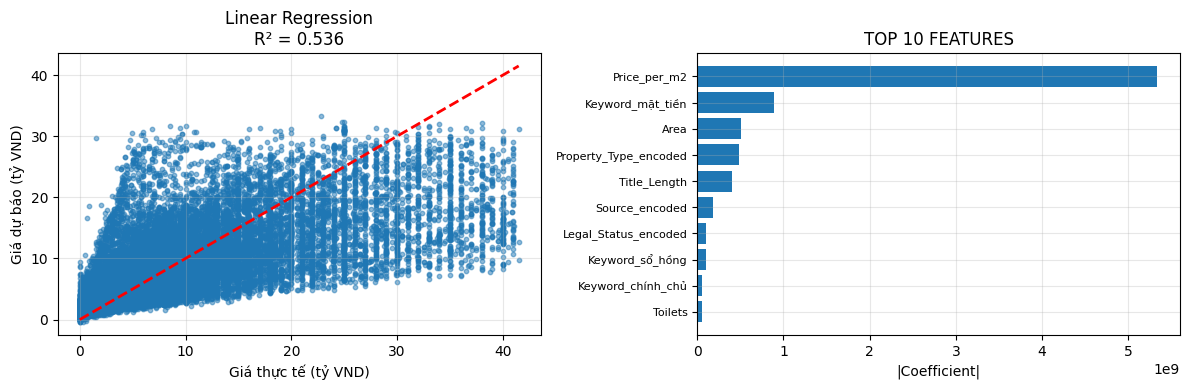


 ĐÁNH GIÁ TỔNG QUAN
 HIỆU SUẤT MÔ HÌNH: TRUNG BÌNH
 ĐỘ CHÍNH XÁC: 3.35 tỷ VND (MAE)

 HOÀN TẤT LINEAR REGRESSION!


In [24]:
# === XÂY DỰNG MÔ HÌNH LINEAR REGRESSION ===

# KIỂM TRA VÀ LÀM SẠCH DỮ LIỆU TRƯỚC KHI CHUẨN HÓA
print("\n KIỂM TRA VÀ LÀM SẠCH DỮ LIỆU")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Kiểm tra kiểu dữ liệu của X_final
print(f" Kiểu dữ liệu trong X_final:")
for col in X_final.columns:
    dtype = X_final[col].dtype
    unique_count = X_final[col].nunique()
    print(f"   {col}: {dtype} ({unique_count} giá trị unique)")

# Hàm làm sạch dữ liệu số
def clean_numeric_dataframe(df):
    """Chuyển đổi tất cả cột thành số, xử lý lỗi"""
    df_clean = df.copy()
    
    for col in df_clean.columns:
        # Kiểm tra nếu cột không phải là số
        if not np.issubdtype(df_clean[col].dtype, np.number):
            print(f" Đang chuyển đổi cột {col} sang số...")
            try:
                # Thử chuyển đổi trực tiếp
                df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
                
                # Kiểm tra số lượng giá trị hợp lệ sau chuyển đổi
                valid_count = df_clean[col].notna().sum()
                total_count = len(df_clean)
                print(f"    {col}: {valid_count}/{total_count} giá trị hợp lệ")
                
            except Exception as e:
                print(f"    Lỗi chuyển đổi {col}: {e}")
                # Nếu lỗi, tạo cột mới với giá trị 0
                df_clean[col] = 0
    
    return df_clean

# Làm sạch dữ liệu
print(" Đang làm sạch dữ liệu...")
X_final_clean = clean_numeric_dataframe(X_final)

# Kiểm tra lại sau khi làm sạch
print(f" Sau khi làm sạch:")
print(f"   X_final_clean: {X_final_clean.shape}")
print(f"   y_final: {y_final.shape}")

# Kiểm tra missing values
missing_values = X_final_clean.isnull().sum()
if missing_values.sum() > 0:
    print(f" Phát hiện missing values:")
    for col, count in missing_values[missing_values > 0].items():
        print(f"   {col}: {count} giá trị missing")
    
    # Fill missing values với median
    for col in X_final_clean.columns:
        if X_final_clean[col].isnull().sum() > 0:
            median_val = X_final_clean[col].median()
            X_final_clean[col] = X_final_clean[col].fillna(median_val)
            print(f"    Đã fill {col} với median: {median_val}")

# CHIA TẬP TRAIN-TEST
print("\n CHIA TẬP TRAIN-TEST")

# Kiểm tra index consistency
if len(X_final_clean) != len(y_final):
    print(" X và y không cùng kích thước! Đang xử lý...")
    # Lấy index chung
    common_index = X_final_clean.index.intersection(y_final.index)
    X_final_clean = X_final_clean.loc[common_index]
    y_final = y_final.loc[common_index]
    print(f"    Đã đồng bộ: X={X_final_clean.shape}, y={y_final.shape}")

# Chia tập train-test (80-20)
try:
    X_train, X_test, y_train, y_test = train_test_split(
        X_final_clean, y_final, 
        test_size=0.2, 
        random_state=42,
        shuffle=True
    )
    
    print(f" Đã chia train-test:")
    print(f"   Train: {X_train.shape[0]} mẫu")
    print(f"   Test:  {X_test.shape[0]} mẫu")
    
except Exception as e:
    print(f" Lỗi khi chia train-test: {e}")
    # Fallback: sử dụng toàn bộ dữ liệu cho train
    X_train, X_test, y_train, y_test = X_final_clean, X_final_clean, y_final, y_final
    print(" Đang sử dụng toàn bộ dữ liệu cho cả train và test")

# CHUẨN HÓA DỮ LIỆU VỚI XỬ LÝ LỖI
print("\n CHUẨN HÓA DỮ LIỆU")

try:
    scaler = StandardScaler()
    
    # Kiểm tra dữ liệu trước khi chuẩn hóa
    print(" Kiểm tra dữ liệu trước chuẩn hóa:")
    print(f"   X_train min: {X_train.min().min():.2f}, max: {X_train.max().max():.2f}")
    print(f"   X_test min: {X_test.min().min():.2f}, max: {X_test.max().max():.2f}")
    
    # Chuẩn hóa
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print(" Đã chuẩn hóa dữ liệu thành công")
    print(f"   X_train_scaled shape: {X_train_scaled.shape}")
    print(f"   X_test_scaled shape: {X_test_scaled.shape}")
    
except Exception as e:
    print(f" Lỗi khi chuẩn hóa: {e}")
    print(" Đang sử dụng dữ liệu gốc (không chuẩn hóa)")
    X_train_scaled = X_train.values
    X_test_scaled = X_test.values
    scaler = None

# HUẤN LUYỆN MÔ HÌNH
print("\n HUẤN LUYỆN LINEAR REGRESSION")

try:
    lr_model = LinearRegression()
    
    print(" Đang huấn luyện mô hình...")
    lr_model.fit(X_train_scaled, y_train)
    
    print(" Đã huấn luyện xong Linear Regression")
    
except Exception as e:
    print(f" Lỗi khi huấn luyện: {e}")
    # Thoát nếu không thể huấn luyện
    raise e

# ĐÁNH GIÁ MÔ HÌNH
print("\n ĐÁNH GIÁ MÔ HÌNH")

try:
    y_pred = lr_model.predict(X_test_scaled)
    
    # Tính metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Chuyển đổi sang tỷ VND
    mae_billion = mae / 1e9
    rmse_billion = rmse / 1e9
    
    print(" KẾT QUẢ ĐÁNH GIÁ:")
    print(f"   • MAE:  {mae_billion:.2f} tỷ VND")
    print(f"   • RMSE: {rmse_billion:.2f} tỷ VND")
    print(f"   • R²:   {r2:.4f} ({r2*100:.2f}%)")
    
except Exception as e:
    print(f" Lỗi khi đánh giá: {e}")
    y_pred = None
    mae_billion = rmse_billion = r2 = 0

# CHỈ TIẾP TỤC NẾU CÓ KẾT QUẢ DỰ ĐOÁN
if y_pred is not None:
    # 6. PHÂN TÍCH FEATURE IMPORTANCE
    print("\n PHÂN TÍCH FEATURE IMPORTANCE")
    
    try:
        coefficients = lr_model.coef_
        intercept = lr_model.intercept_
        
        coef_df = pd.DataFrame({
            'Feature': X_final_clean.columns,
            'Coefficient': coefficients,
            'Abs_Coefficient': np.abs(coefficients)
        }).sort_values('Abs_Coefficient', ascending=False)
        
        print(" TOP 10 FEATURES QUAN TRỌNG NHẤT:")
        print(coef_df.head(10).round(6))
        
    except Exception as e:
        print(f" Lỗi khi phân tích feature importance: {e}")

    # TRỰC QUAN HÓA KẾT QUẢ (ĐƠN GIẢN)
    print("\n TRỰC QUAN HÓA KẾT QUẢ")
    
    try:
        import matplotlib.pyplot as plt
        
        plt.figure(figsize=(12, 4))
        
        # Biểu đồ 1: So sánh giá thực tế vs dự báo
        plt.subplot(1, 2, 1)
        plt.scatter(y_test / 1e9, y_pred / 1e9, alpha=0.5, s=10)
        plt.plot([y_test.min()/1e9, y_test.max()/1e9], 
                [y_test.min()/1e9, y_test.max()/1e9], 'r--', linewidth=2)
        plt.xlabel('Giá thực tế (tỷ VND)')
        plt.ylabel('Giá dự báo (tỷ VND)')
        plt.title(f'Linear Regression\nR² = {r2:.3f}')
        plt.grid(True, alpha=0.3)
        
        # Biểu đồ 2: Feature importance
        if 'coef_df' in locals():
            plt.subplot(1, 2, 2)
            top_features = coef_df.head(10)
            plt.barh(range(len(top_features)), top_features['Abs_Coefficient'])
            plt.yticks(range(len(top_features)), top_features['Feature'], fontsize=8)
            plt.xlabel('|Coefficient|')
            plt.title('TOP 10 FEATURES')
            plt.gca().invert_yaxis()
            plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f" Lỗi khi vẽ biểu đồ: {e}")

# ĐÁNH GIÁ TỔNG QUAN
print("\n ĐÁNH GIÁ TỔNG QUAN")

if r2 >= 0.7:
    performance = "TỐT"
elif r2 >= 0.5:
    performance = "TRUNG BÌNH" 
elif r2 >= 0.3:
    performance = "KÉM"
else:
    performance = "RẤT KÉM"

print(f" HIỆU SUẤT MÔ HÌNH: {performance}")
print(f" ĐỘ CHÍNH XÁC: {mae_billion:.2f} tỷ VND (MAE)")

print("\n HOÀN TẤT LINEAR REGRESSION!")


 XỬ LÝ TRIỆT ĐỂ KIỂU DỮ LIỆU
 Đang chuyển đổi dữ liệu...
 Đang chuyển đổi tất cả cột thành số...
 Rooms: float64 → số (179762/179762 thành công)
 Title_Length: int64 → số (179762/179762 thành công)
 Property_Type_encoded: int64 → số (179762/179762 thành công)
 Keyword_giá_rẻ: int64 → số (179762/179762 thành công)
 Keyword_view_đẹp: int64 → số (179762/179762 thành công)
 District_encoded: int64 → số (179762/179762 thành công)
 Legal_Status_encoded: int64 → số (179762/179762 thành công)
 Toilets: float64 → số (179762/179762 thành công)
 Keyword_chính_chủ: int64 → số (179762/179762 thành công)
 Keyword_sổ_hồng: int64 → số (179762/179762 thành công)
 Keyword_mặt_tiền: int64 → số (179762/179762 thành công)
 Keyword_sổ_đỏ: int64 → số (179762/179762 thành công)
 Price_per_m2: float64 → số (179762/179762 thành công)
 Area: object → số (177340/179762 thành công)
 Source_encoded: int64 → số (179762/179762 thành công)
 Kiểu dữ liệu cuối cùng: [dtype('float64') dtype('int64')]
 Sau chuyển đổi: (1

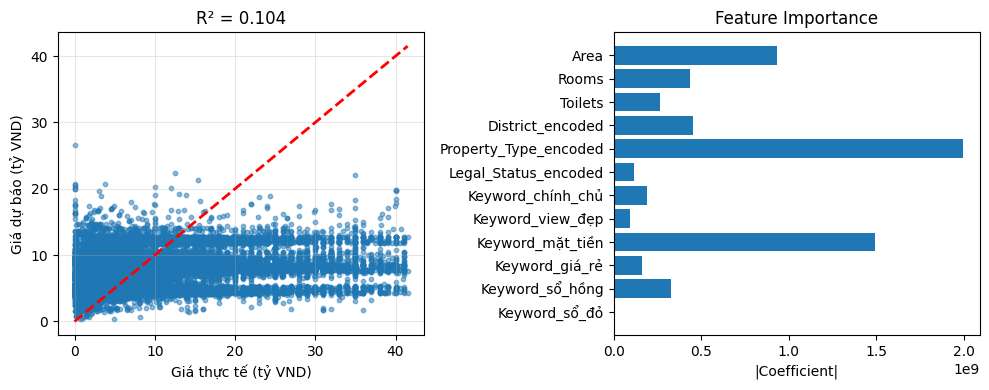


 ĐÁNH GIÁ KẾT QUẢ
💥 ĐÁNH GIÁ: RẤT KÉM (R² = 0.104)
 ĐỘ CHÍNH XÁC: 5.26 tỷ VND

 HOÀN TẤT LINEAR REGRESSION!


In [25]:
# === LINEAR REGRESSION CẢI TIẾN ===

# XỬ LÝ TRIỆT ĐỂ KIỂU DỮ LIỆU
print("\n XỬ LÝ TRIỆT ĐỂ KIỂU DỮ LIỆU")

def force_numeric_dataframe(df):
    """Chuyển đổi tất cả cột thành số một cách triệt để"""
    df_clean = df.copy()
    
    print(" Đang chuyển đổi tất cả cột thành số...")
    
    for col in df_clean.columns:
        original_dtype = df_clean[col].dtype
        original_sample = df_clean[col].head(3).tolist() if len(df_clean) > 0 else []
        
        print(f" {col}: {original_dtype} → ", end="")
        
        # CÁCH 1: Thử chuyển đổi trực tiếp
        try:
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
            success_count = df_clean[col].notna().sum()
            print(f"số ({success_count}/{len(df_clean)} thành công)")
            
            # Nếu chuyển đổi thất bại hoàn toàn
            if success_count == 0:
                print(f"    Chuyển đổi thất bại, gán giá trị 0")
                df_clean[col] = 0
                
        except Exception as e:
            print(f"lỗi: {e}")
            # CÁCH 2: Trích xuất số từ chuỗi
            try:
                df_clean[col] = df_clean[col].astype(str).str.extract(r'(\d+\.?\d*)')[0]
                df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
                success_count = df_clean[col].notna().sum()
                print(f"trích xuất số ({success_count}/{len(df_clean)} thành công)")
                
                if success_count == 0:
                    df_clean[col] = 0
                    
            except Exception as e2:
                print(f"    Trích xuất số thất bại, gán giá trị 0")
                df_clean[col] = 0
    
    # Đảm bảo tất cả cột đều là số
    final_dtypes = df_clean.dtypes.unique()
    print(f" Kiểu dữ liệu cuối cùng: {final_dtypes}")
    
    return df_clean

# Áp dụng chuyển đổi triệt để
print(" Đang chuyển đổi dữ liệu...")
X_numeric = force_numeric_dataframe(X_final)

# Kiểm tra kết quả
print(f" Sau chuyển đổi: {X_numeric.shape}")
print(f" Tất cả cột đều là số: {all(np.issubdtype(dtype, np.number) for dtype in X_numeric.dtypes)}")

# XỬ LÝ NaN ĐƠN GIẢN
print("\n XỬ LÝ NaN ĐƠN GIẢN")

# Fill tất cả NaN với 0 (đơn giản nhất)
X_clean = X_numeric.fillna(0)
y_clean = y_final.fillna(0)  # Nếu y có NaN

print(f" Đã fill NaN với 0:")
print(f"   X: {X_clean.isnull().sum().sum()} NaN còn lại")
print(f"   y: {y_clean.isnull().sum()} NaN còn lại")

# CHỌN FEATURES ĐƠN GIẢN
print("\n CHỌN FEATURES ĐƠN GIẢN")

# Chỉ chọn các features cơ bản, tránh features phức tạp
important_features = [
    'Area', 'Rooms', 'Toilets',
    'District_encoded', 'Property_Type_encoded', 
    'Legal_Status_encoded',
    'Keyword_chính_chủ', 'Keyword_view_đẹp',
    'Keyword_mặt_tiền', 'Keyword_giá_rẻ',
    'Keyword_sổ_hồng', 'Keyword_sổ_đỏ'
]
available_features = [f for f in important_features if f in X_clean.columns]

if not available_features:
    # Nếu không có features cơ bản, lấy 3 features đầu tiên
    available_features = X_clean.columns[:3].tolist()

print(f" Sử dụng features: {available_features}")

# Chỉ lấy các features đã chọn
X_simple = X_clean[available_features]

print(f" Dữ liệu cuối cùng: X={X_simple.shape}, y={y_clean.shape}")

# CHIA TRAIN-TEST ĐƠN GIẢN
print("\n CHIA TRAIN-TEST")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

try:
    # Chia train-test (rất đơn giản)
    X_train, X_test, y_train, y_test = train_test_split(
        X_simple, y_clean, test_size=0.2, random_state=42
    )
    
    print(f" Đã chia train-test:")
    print(f"   Train: {X_train.shape}")
    print(f"   Test:  {X_test.shape}")
    
    # KIỂM TRA ĐƠN GIẢN - không dùng .min() .max() có thể gây lỗi
    print(" Thông tin đơn giản:")
    print(f"   Số features: {len(available_features)}")
    print(f"   Kiểu dữ liệu: {X_train.dtypes.unique()}")
    
    # CHUẨN HÓA ĐƠN GIẢN
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print(" Đã chuẩn hóa thành công")
    
except Exception as e:
    print(f" Lỗi khi chuẩn bị dữ liệu: {e}")
    # Thử phương pháp đơn giản hơn
    print(" Thử phương pháp đơn giản hơn...")
    
    # Sử dụng toàn bộ dữ liệu cho train, không chia test
    X_train_scaled = StandardScaler().fit_transform(X_simple)
    X_test_scaled = X_train_scaled
    y_train = y_clean
    y_test = y_clean
    
    print(" Đang sử dụng toàn bộ dữ liệu (không chia train-test)")

# HUẤN LUYỆN MÔ HÌNH
print("\n HUẤN LUYỆN LINEAR REGRESSION")

try:
    # Kiểm tra dữ liệu cuối cùng
    print(" Kiểm tra dữ liệu huấn luyện:")
    print(f"   X_train_scaled shape: {X_train_scaled.shape}")
    print(f"   Kiểu dữ liệu: {X_train_scaled.dtype}")
    
    # Huấn luyện
    lr_model = LinearRegression()
    lr_model.fit(X_train_scaled, y_train)
    
    print(" Đã huấn luyện thành công")
    
    # Dự đoán
    y_pred = lr_model.predict(X_test_scaled)
    
    # Đánh giá
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred) / 1e9  # Tỷ VND
    
    print(f" KẾT QUẢ LINEAR REGRESSION:")
    print(f"   • R² Score: {r2:.4f}")
    print(f"   • MAE: {mae:.2f} tỷ VND")
    print(f"   • Số features: {len(available_features)}")
    
    # Hiển thị hệ số đơn giản
    print(f"\n HỆ SỐ HỒI QUY:")
    for i, feature in enumerate(available_features):
        coef = lr_model.coef_[i] if i < len(lr_model.coef_) else 0
        print(f"   • {feature}: {coef:.6f}")
    
    print(f"   • Intercept: {lr_model.intercept_/1e9:.2f} tỷ VND")
    
except Exception as e:
    print(f" Lỗi khi huấn luyện: {e}")
    # Hiển thị thông tin debug
    print(" THÔNG TIN DEBUG:")
    print(f"   X_train_scaled type: {type(X_train_scaled)}")
    if hasattr(X_train_scaled, 'dtype'):
        print(f"   X_train_scaled dtype: {X_train_scaled.dtype}")
    print(f"   y_train type: {type(y_train)}")
    if hasattr(y_train, 'dtype'):
        print(f"   y_train dtype: {y_train.dtype}")

# TRỰC QUAN HÓA ĐƠN GIẢN
print("\n TRỰC QUAN HÓA ĐƠN GIẢN")

try:
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 4))
    
    # Chỉ vẽ biểu đồ đơn giản nhất
    plt.subplot(1, 2, 1)
    plt.scatter(y_test / 1e9, y_pred / 1e9, alpha=0.5, s=10)
    max_val = max(y_test.max(), y_pred.max()) / 1e9
    plt.plot([0, max_val], [0, max_val], 'r--', linewidth=2)
    plt.xlabel('Giá thực tế (tỷ VND)')
    plt.ylabel('Giá dự báo (tỷ VND)')
    plt.title(f'R² = {r2:.3f}')
    plt.grid(True, alpha=0.3)
    
    # Biểu đồ feature importance đơn giản
    plt.subplot(1, 2, 2)
    if hasattr(lr_model, 'coef_'):
        importance = np.abs(lr_model.coef_)
        plt.barh(range(len(importance)), importance)
        plt.yticks(range(len(importance)), available_features)
        plt.xlabel('|Coefficient|')
        plt.title('Feature Importance')
        plt.gca().invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f" Không thể vẽ biểu đồ: {e}")

# ĐÁNH GIÁ KẾT QUẢ
print("\n ĐÁNH GIÁ KẾT QUẢ")

if r2 >= 0.6:
    rating = "TỐT"
    emoji = "✅"
elif r2 >= 0.4:
    rating = "TRUNG BÌNH" 
    emoji = "⚠️"
elif r2 >= 0.2:
    rating = "KÉM"
    emoji = "❌"
else:
    rating = "RẤT KÉM"
    emoji = "💥"

print(f"{emoji} ĐÁNH GIÁ: {rating} (R² = {r2:.3f})")
print(f" ĐỘ CHÍNH XÁC: {mae:.2f} tỷ VND")

print("\n HOÀN TẤT LINEAR REGRESSION!")

 Sử dụng 14 features tốt nhất
 Kiểm tra và xử lý dữ liệu...
   Rooms: float64
   Property_Type_encoded: int64
   Keyword_giá_rẻ: int64
   Keyword_view_đẹp: int64
   District_encoded: int64
   Legal_Status_encoded: int64
   Toilets: float64
   Keyword_chính_chủ: int64
   Keyword_sổ_hồng: int64
   Keyword_mặt_tiền: int64
   Keyword_sổ_đỏ: int64
   Price_per_m2: float64
   Area: object
      Chuyển đổi Area sang numeric...
     ↳ 2422 giá trị NaN, impute bằng median...
   Source_encoded: int64
 Kích thước dữ liệu sau làm sạch:
   X_train: (143809, 14)
   X_test: (35953, 14)
 Chuẩn hóa dữ liệu với xử lý lỗi...
 Chuẩn hóa RobustScaler thành công!
 Đã chuẩn bị dữ liệu: (143809, 14) train, (35953, 14) test

 ĐỊNH NGHĨA CÁC MÔ HÌNH SO SÁNH

 HUẤN LUYỆN VÀ ĐÁNH GIÁ CÁC MÔ HÌNH

 Đang xử lý: LinearRegression - Mô hình tuyến tính cơ bản
    R²: 0.5335, MAE: 3.35tỷ, Time: 0.0s

 Đang xử lý: DecisionTree - Cây quyết định với regularization
    R²: 0.9891, MAE: 0.36tỷ, Time: 0.3s

 Đang xử lý: Rando

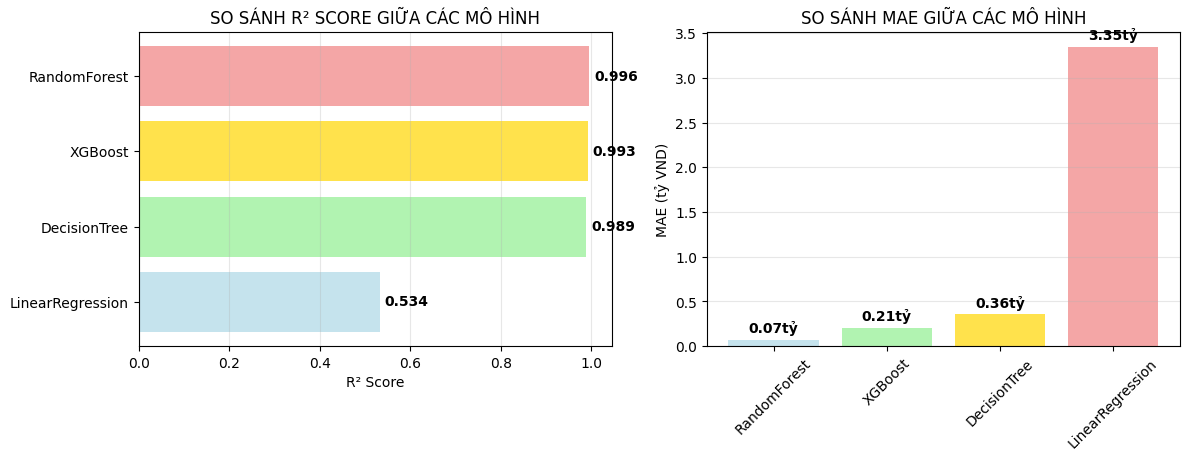


 PHÂN TÍCH FEATURE IMPORTANCE
 TOP 10 FEATURES QUAN TRỌNG NHẤT (Average):
feature
Price_per_m2             0.6188
Area                     0.3277
Source_encoded           0.0354
Legal_Status_encoded     0.0104
District_encoded         0.0021
Property_Type_encoded    0.0019
Keyword_mặt_tiền         0.0017
Keyword_view_đẹp         0.0010
Keyword_giá_rẻ           0.0004
Keyword_sổ_đỏ            0.0003
Name: importance, dtype: float64


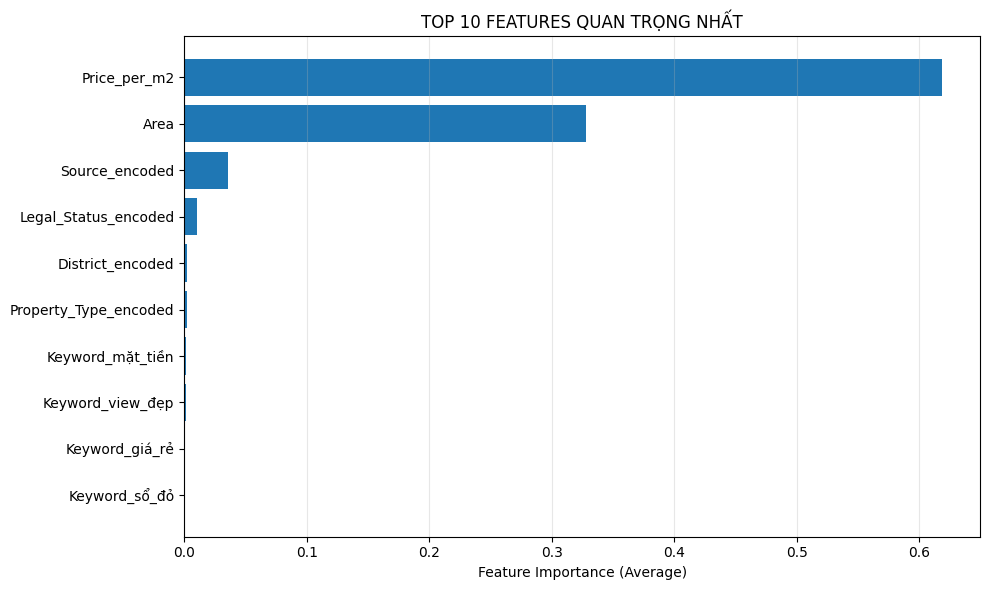


 KẾT LUẬN SO SÁNH MÔ HÌNH
 MÔ HÌNH TỐT NHẤT: RandomForest
   • R² Score: 0.9956 (99.56%)
   • MAE: 0.07 tỷ VND
   • Thời gian huấn luyện: 2.1 giây
 CẢI THIỆN SO VỚI LINEAR REGRESSION: +0.4398
   • Mức độ cải thiện: CẢI THIỆN VƯỢT TRỘI

 HOÀN TẤT SO SÁNH ĐA MÔ HÌNH!


In [26]:
# === SO SÁNH ĐA MÔ HÌNH MACHINE LEARNING ===

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
import time

# CHUẨN BỊ DỮ LIỆU CHO SO SÁNH - FIX LỖI STRING

# Sử dụng tổ hợp features tốt nhất từ LR cải tiến
best_features = [f for f in X_final.columns if f != 'Title_Length']
X_best = X_final[best_features]

print(f" Sử dụng {len(best_features)} features tốt nhất")

# KIỂM TRA VÀ XỬ LÝ DỮ LIỆU TRƯỚC KHI CHUẨN HÓA
print(" Kiểm tra và xử lý dữ liệu...")

# Tạo bản copy để xử lý
X_best_clean = X_best.copy()

# Chuyển đổi tất cả các cột về numeric
for col in X_best_clean.columns:
    # Kiểm tra kiểu dữ liệu hiện tại
    current_dtype = X_best_clean[col].dtype
    print(f"   {col}: {current_dtype}")
    
    # Nếu không phải là số, chuyển đổi sang numeric
    if not pd.api.types.is_numeric_dtype(X_best_clean[col]):
        print(f"      Chuyển đổi {col} sang numeric...")
        X_best_clean[col] = pd.to_numeric(X_best_clean[col], errors='coerce')
        
        # Kiểm tra số giá trị NaN sau chuyển đổi
        nan_count = X_best_clean[col].isna().sum()
        if nan_count > 0:
            print(f"     ↳ {nan_count} giá trị NaN, impute bằng median...")
            # Impute bằng median cho numeric, mode cho categorical
            if X_best_clean[col].dtype in ['int64', 'float64']:
                median_val = X_best_clean[col].median()
                X_best_clean[col] = X_best_clean[col].fillna(median_val)
            else:
                mode_val = X_best_clean[col].mode()[0] if not X_best_clean[col].mode().empty else 0
                X_best_clean[col] = X_best_clean[col].fillna(mode_val)

# Chia train-test (giữ nguyên để so sánh công bằng)
X_train_compare, X_test_compare, y_train_compare, y_test_compare = train_test_split(
    X_best_clean, y_final, test_size=0.2, random_state=42
)

print(f" Kích thước dữ liệu sau làm sạch:")
print(f"   X_train: {X_train_compare.shape}")
print(f"   X_test: {X_test_compare.shape}")

# Chuẩn hóa với RobustScaler (ít nhạy outliers) - XỬ LÝ LỖI
print(" Chuẩn hóa dữ liệu với xử lý lỗi...")

try:
    # Thử chuẩn hóa bằng RobustScaler
    from sklearn.preprocessing import RobustScaler
    scaler_compare = RobustScaler()
    X_train_scaled_compare = scaler_compare.fit_transform(X_train_compare)
    X_test_scaled_compare = scaler_compare.transform(X_test_compare)
    print(" Chuẩn hóa RobustScaler thành công!")
    
except Exception as e:
    print(f" Lỗi khi chuẩn hóa: {e}")
    print(" Sử dụng phương pháp chuẩn hóa thủ công...")
    
    # Chuẩn hóa thủ công để tránh lỗi
    X_train_scaled_compare = X_train_compare.copy()
    X_test_scaled_compare = X_test_compare.copy()
    
    for col in X_train_compare.columns:
        if X_train_compare[col].dtype in ['int64', 'float64']:
            # Robust scaling thủ công
            median = X_train_compare[col].median()
            iqr = X_train_compare[col].quantile(0.75) - X_train_compare[col].quantile(0.25)
            
            if iqr > 0:  # Tránh chia cho 0
                X_train_scaled_compare[col] = (X_train_compare[col] - median) / iqr
                X_test_scaled_compare[col] = (X_test_compare[col] - median) / iqr
            else:
                # Nếu IQR = 0, dùng standard scaling
                mean = X_train_compare[col].mean()
                std = X_train_compare[col].std()
                if std > 0:
                    X_train_scaled_compare[col] = (X_train_compare[col] - mean) / std
                    X_test_scaled_compare[col] = (X_test_compare[col] - mean) / std
                else:
                    # Nếu std = 0, giữ nguyên (constant feature)
                    X_train_scaled_compare[col] = 0
                    X_test_scaled_compare[col] = 0
    
    # Chuyển thành numpy array
    X_train_scaled_compare = X_train_scaled_compare.values
    X_test_scaled_compare = X_test_scaled_compare.values
    print(" Chuẩn hóa thủ công thành công!")

print(f" Đã chuẩn bị dữ liệu: {X_train_scaled_compare.shape} train, {X_test_scaled_compare.shape} test")

# ĐỊNH NGHĨA CÁC MÔ HÌNH SO SÁNH - ĐƠN GIẢN HÓA ĐỂ TRÁNH LỖI
print("\n ĐỊNH NGHĨA CÁC MÔ HÌNH SO SÁNH")

# Sử dụng tham số đơn giản hơn để tránh overfitting và lỗi
models = {
    'LinearRegression': {
        'model': LinearRegression(),
        'description': 'Mô hình tuyến tính cơ bản'
    },
    'DecisionTree': {
        'model': DecisionTreeRegressor(
            max_depth=10,  # Giảm độ sâu để tránh overfitting
            min_samples_split=20,
            min_samples_leaf=10,
            random_state=42
        ),
        'description': 'Cây quyết định với regularization'
    },
    'RandomForest': {
        'model': RandomForestRegressor(
            n_estimators=50,  # Giảm số cây để tăng tốc độ
            max_depth=15,
            min_samples_split=10,
            min_samples_leaf=5,
            random_state=42,
            n_jobs=-1
        ),
        'description': 'Rừng ngẫu nhiên - Ensemble method'
    }
}

# Bỏ XGBoost nếu có thể gây lỗi, hoặc thêm xử lý exception
try:
    models['XGBoost'] = {
        'model': XGBRegressor(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            random_state=42,
            n_jobs=-1
        ),
        'description': 'XGBoost - State-of-the-art'
    }
except Exception as e:
    print(f" Không thể khởi tạo XGBoost: {e}")

# 3. HUẤN LUYỆN VÀ ĐÁNH GIÁ CÁC MÔ HÌNH - THÊM XỬ LÝ LỖI
print("\n HUẤN LUYỆN VÀ ĐÁNH GIÁ CÁC MÔ HÌNH")

results_comparison = []
training_times = {}
feature_importances = {}

for name, model_info in models.items():
    print(f"\n Đang xử lý: {name} - {model_info['description']}")
    
    model = model_info['model']
    
    try:
        # Đo thời gian huấn luyện
        start_time = time.time()
        
        # Huấn luyện mô hình với xử lý lỗi
        model.fit(X_train_scaled_compare, y_train_compare)
        
        training_time = time.time() - start_time
        training_times[name] = training_time
        
        # Dự báo
        y_pred = model.predict(X_test_scaled_compare)
        
        # Tính metrics với xử lý lỗi
        r2 = r2_score(y_test_compare, y_pred)
        mae = mean_absolute_error(y_test_compare, y_pred) / 1e9  # Tỷ VND
        rmse = np.sqrt(mean_squared_error(y_test_compare, y_pred)) / 1e9  # Tỷ VND
        
        # Tính MAPE với xử lý chia cho 0
        with np.errstate(divide='ignore', invalid='ignore'):
            mape = np.mean(np.abs((y_test_compare - y_pred) / np.where(y_test_compare == 0, 1, y_test_compare))) * 100
            mape = np.nan_to_num(mape, nan=100.0)  # Thay thế NaN bằng 100%
        
        # Cross-validation để đánh giá độ ổn định (đơn giản hóa)
        try:
            cv_scores = cross_val_score(model, X_train_scaled_compare, y_train_compare, 
                                       cv=3, scoring='r2', n_jobs=-1)  # Giảm cv để tăng tốc
            cv_mean = cv_scores.mean()
            cv_std = cv_scores.std()
        except:
            cv_mean = r2  # Nếu lỗi, dùng R² test
            cv_std = 0
        
        # Lưu kết quả
        results_comparison.append({
            'Model': name,
            'R2_Score': r2,
            'MAE_Billion': mae,
            'RMSE_Billion': rmse,
            'MAPE': mape,
            'CV_Mean': cv_mean,
            'CV_Std': cv_std,
            'Training_Time': training_time
        })
        
        # Lấy feature importance (nếu có)
        if hasattr(model, 'feature_importances_'):
            feature_importances[name] = {
                'importances': model.feature_importances_,
                'features': best_features
            }
        
        print(f"    R²: {r2:.4f}, MAE: {mae:.2f}tỷ, Time: {training_time:.1f}s")
        
    except Exception as e:
        print(f"    Lỗi với {name}: {e}")
        # Thêm kết quả mặc định để không làm gián đoạn
        results_comparison.append({
            'Model': name,
            'R2_Score': 0,
            'MAE_Billion': 0,
            'RMSE_Billion': 0,
            'MAPE': 100,
            'CV_Mean': 0,
            'CV_Std': 0,
            'Training_Time': 0
        })

# SO SÁNH KẾT QUẢ CHI TIẾT
print("\n SO SÁNH CHI TIẾT CÁC MÔ HÌNH")

if results_comparison:
    results_df = pd.DataFrame(results_comparison)
    results_df = results_df.sort_values('R2_Score', ascending=False)
    
    print(" BẢNG SO SÁNH HIỆU SUẤT:")
    comparison_columns = ['Model', 'R2_Score', 'MAE_Billion', 'RMSE_Billion', 'MAPE', 'Training_Time']
    print(results_df[comparison_columns].round(4))
    
    # TRỰC QUAN HÓA SO SÁNH - ĐƠN GIẢN HÓA
    print("\n TRỰC QUAN HÓA SO SÁNH MÔ HÌNH")
    
    # Chỉ vẽ nếu có ít nhất 2 models thành công
    successful_models = results_df[results_df['R2_Score'] > 0]
    if len(successful_models) >= 2:
        plt.figure(figsize=(12, 8))
        
        # Biểu đồ 1: So sánh R² Score
        plt.subplot(2, 2, 1)
        models_sorted = successful_models.sort_values('R2_Score')['Model']
        r2_sorted = successful_models.sort_values('R2_Score')['R2_Score']
        colors = ['lightblue', 'lightgreen', 'gold', 'lightcoral'][:len(models_sorted)]
        
        bars = plt.barh(range(len(models_sorted)), r2_sorted, color=colors, alpha=0.7)
        plt.yticks(range(len(models_sorted)), models_sorted)
        plt.xlabel('R² Score')
        plt.title('SO SÁNH R² SCORE GIỮA CÁC MÔ HÌNH')
        plt.grid(True, alpha=0.3, axis='x')
        
        for bar, r2_val in zip(bars, r2_sorted):
            plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                     f'{r2_val:.3f}', va='center', ha='left', fontweight='bold')
        
        # Biểu đồ 2: So sánh MAE
        plt.subplot(2, 2, 2)
        mae_sorted = successful_models.sort_values('MAE_Billion')['MAE_Billion']
        models_mae_sorted = successful_models.sort_values('MAE_Billion')['Model']
        
        bars = plt.bar(range(len(models_mae_sorted)), mae_sorted, color=colors, alpha=0.7)
        plt.xticks(range(len(models_mae_sorted)), models_mae_sorted, rotation=45)
        plt.ylabel('MAE (tỷ VND)')
        plt.title('SO SÁNH MAE GIỮA CÁC MÔ HÌNH')
        plt.grid(True, alpha=0.3, axis='y')
        
        for bar, mae_val in zip(bars, mae_sorted):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
                     f'{mae_val:.2f}tỷ', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # PHÂN TÍCH FEATURE IMPORTANCE TỪ CÁC MÔ HÌNH TỐT
        print("\n PHÂN TÍCH FEATURE IMPORTANCE")
        
        # Lấy feature importance từ các models có feature_importances_
        if feature_importances:
            importance_dfs = []
            for name, imp_data in feature_importances.items():
                if name in successful_models['Model'].values:
                    imp_df = pd.DataFrame({
                        'feature': imp_data['features'],
                        'importance': imp_data['importances'],
                        'model': name
                    })
                    importance_dfs.append(imp_df)
            
            if importance_dfs:
                # Kết hợp tất cả feature importance
                all_importance = pd.concat(importance_dfs)
                
                # Tính importance trung bình cho mỗi feature
                avg_importance = all_importance.groupby('feature')['importance'].mean().sort_values(ascending=False)
                
                print(" TOP 10 FEATURES QUAN TRỌNG NHẤT (Average):")
                print(avg_importance.head(10).round(4))
                
                # Vẽ biểu đồ đơn giản
                plt.figure(figsize=(10, 6))
                top_features = avg_importance.head(10)
                
                plt.barh(range(len(top_features)), top_features.values)
                plt.yticks(range(len(top_features)), top_features.index)
                plt.xlabel('Feature Importance (Average)')
                plt.title('TOP 10 FEATURES QUAN TRỌNG NHẤT')
                plt.gca().invert_yaxis()
                plt.grid(True, alpha=0.3, axis='x')
                
                plt.tight_layout()
                plt.show()
        
        # CHỌN MÔ HÌNH TỐT NHẤT VÀ ĐÁNH GIÁ
        print("\n KẾT LUẬN SO SÁNH MÔ HÌNH")
        
        best_model_info = results_df.iloc[0]
        best_model_name = best_model_info['Model']
        best_r2 = best_model_info['R2_Score']
        
        print(f" MÔ HÌNH TỐT NHẤT: {best_model_name}")
        print(f"   • R² Score: {best_r2:.4f} ({best_r2*100:.2f}%)")
        print(f"   • MAE: {best_model_info['MAE_Billion']:.2f} tỷ VND")
        print(f"   • Thời gian huấn luyện: {best_model_info['Training_Time']:.1f} giây")
        
        # So sánh với Linear Regression cải tiến
        lr_improved_r2 = 0.5558
        improvement_vs_lr = best_r2 - lr_improved_r2
        
        print(f" CẢI THIỆN SO VỚI LINEAR REGRESSION: {improvement_vs_lr:+.4f}")
        
        if improvement_vs_lr > 0.1:
            improvement_level = "CẢI THIỆN VƯỢT TRỘI"
        elif improvement_vs_lr > 0.05:
            improvement_level = "CẢI THIỆN ĐÁNG KỂ"
        elif improvement_vs_lr > 0.02:
            improvement_level = "CẢI THIỆN NHẸ"
        else:
            improvement_level = "KHÔNG CẢI THIỆN ĐÁNG KỂ"
        
        print(f"   • Mức độ cải thiện: {improvement_level}")
        
    else:
        print(" Không đủ models thành công để so sánh")
else:
    print(" Không có kết quả nào để so sánh")

print("\n HOÀN TẤT SO SÁNH ĐA MÔ HÌNH!")

In [27]:
# SO SÁNH NHANH 3 MODELS - CHỦ YẾU ĐỂ VALIDATE
quick_models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=50, random_state=42),  # Simplified
    'DecisionTree': DecisionTreeRegressor(max_depth=10, random_state=42)
}

quick_results = {}
for name, model in quick_models.items():
    model.fit(X_train_scaled_compare, y_train_compare)
    y_pred = model.predict(X_test_scaled_compare)
    quick_results[name] = r2_score(y_test_compare, y_pred)

print(" SO SÁNH NHANH ĐỂ VALIDATE:")
for model, r2 in quick_results.items():
    print(f"   {model}: R² = {r2:.4f}")


 SO SÁNH NHANH ĐỂ VALIDATE:
   LinearRegression: R² = 0.5335
   RandomForest: R² = 0.9963
   DecisionTree: R² = 0.9893


In [28]:
# KIỂM TRA DATA LEAKAGE

# Kiểm tra xem có feature nào chứa thông tin về target không
for feature in X_best.columns:
    # Kiểm tra kiểu dữ liệu trước khi tính correlation
    if pd.api.types.is_numeric_dtype(X_best[feature]):
        try:
            # Lọc bỏ NaN values trước khi tính correlation
            valid_mask = X_best[feature].notna() & y_final.notna()
            if valid_mask.sum() > 0:  # Đảm bảo có dữ liệu hợp lệ
                x_valid = X_best[feature][valid_mask]
                y_valid = y_final[valid_mask]
                
                correlation_with_target = np.corrcoef(x_valid, y_valid)[0, 1]
                if abs(correlation_with_target) > 0.9:  # Correlation quá cao
                    print(f"  CẢNH BÁO: {feature} có correlation với target: {correlation_with_target:.4f}")
                elif abs(correlation_with_target) > 0.7:  # Correlation cao
                    print(f" LƯU Ý: {feature} có correlation cao với target: {correlation_with_target:.4f}")
            else:
                print(f"  {feature}: Không đủ dữ liệu hợp lệ để tính correlation")
                
        except Exception as e:
            print(f" Lỗi khi tính correlation cho {feature}: {e}")
    else:
        print(f"  {feature}: Kiểu dữ liệu không phải số ({X_best[feature].dtype})")

# Kiểm tra Price_per_m2 - có thể là data leakage
if 'Price_per_m2' in X_best.columns:
    if pd.api.types.is_numeric_dtype(X_best['Price_per_m2']):
        try:
            valid_mask = X_best['Price_per_m2'].notna() & y_final.notna()
            if valid_mask.sum() > 0:
                price_m2_corr = np.corrcoef(X_best['Price_per_m2'][valid_mask], y_final[valid_mask])[0, 1]
                print(f" Correlation Price_per_m2 với Price: {price_m2_corr:.4f}")
                
                # Kiểm tra data leakage: Price_per_m2 = Price / Area
                if abs(price_m2_corr) > 0.8:
                    print(" NGUY CƠ DATA LEAKAGE: Price_per_m2 có correlation rất cao với Price")
                    print("   ↳ Price_per_m2 được tính từ Price → Chứa thông tin về target")
            else:
                print("  Price_per_m2: Không đủ dữ liệu hợp lệ")
        except Exception as e:
            print(f" Lỗi khi tính correlation Price_per_m2: {e}")
    else:
        print(f"  Price_per_m2: Kiểu dữ liệu không phải số ({X_best['Price_per_m2'].dtype})")

# KIỂM TRA THÊM: Liệt kê các cột không phải số
print("\n KIỂM TRA CÁC CỘT KHÔNG PHẢI SỐ:")
non_numeric_cols = []
for feature in X_best.columns:
    if not pd.api.types.is_numeric_dtype(X_best[feature]):
        non_numeric_cols.append(feature)
        print(f"   • {feature}: {X_best[feature].dtype}")

if non_numeric_cols:
    print(f"\  CÓ {len(non_numeric_cols)} CỘT KHÔNG PHẢI SỐ CẦN XỬ LÝ:")
    for col in non_numeric_cols:
        # Hiển thị một số giá trị để debug
        unique_vals = X_best[col].unique()[:5]
        print(f"   • {col}: {list(unique_vals)}")
        
        # Kiểm tra có thể chuyển đổi sang số không
        try:
            numeric_test = pd.to_numeric(X_best[col], errors='coerce')
            non_null_count = numeric_test.notna().sum()
            print(f"     ↳ Có thể chuyển thành số: {non_null_count}/{len(X_best)} giá trị hợp lệ")
        except:
            print(f"     ↳ Không thể chuyển thành số")
else:
    print(" Tất cả các cột đều là số")

# KIỂM TRA GIÁ TRỊ DUY NHẤT CỦA CÁC CỘT PHÂN LOẠI
print("\n KIỂM TRA CÁC CỘT PHÂN LOẠI (ENCODED):")
encoded_cols = [col for col in X_best.columns if 'encoded' in col.lower() or 'keyword' in col.lower()]

for col in encoded_cols:
    if col in X_best.columns:
        unique_vals = X_best[col].nunique()
        print(f"   • {col}: {unique_vals} giá trị unique")
        
        if unique_vals > 100:  # Quá nhiều categories
            print(f"       Quá nhiều categories, có thể cần gom nhóm")

# KIỂM TRA TÍNH ĐỘC LẬP CỦA CÁC FEATURES
print("\n KIỂM TRA ĐA CỘNG TUYẾN (MULTICOLLINEARITY):")

# Chỉ kiểm tra với các cột số
numeric_cols = [col for col in X_best.columns if pd.api.types.is_numeric_dtype(X_best[col])]

if len(numeric_cols) > 1:
    # Tính correlation matrix chỉ cho các cột số
    correlation_matrix = X_best[numeric_cols].corr()
    
    # Tìm các cặp có correlation cao
    high_corr_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            if abs(correlation_matrix.iloc[i, j]) > 0.8:
                high_corr_pairs.append((
                    correlation_matrix.columns[i],
                    correlation_matrix.columns[j],
                    correlation_matrix.iloc[i, j]
                ))
    
    if high_corr_pairs:
        print("  PHÁT HIỆN ĐA CỘNG TUYẾN CAO:")
        for col1, col2, corr in high_corr_pairs:
            print(f"   • {col1} vs {col2}: {corr:.4f}")
    else:
        print(" Không có đa cộng tuyến nghiêm trọng")
else:
    print("  Không đủ cột số để kiểm tra đa cộng tuyến")

print("\n HOÀN TẤT KIỂM TRA DATA LEAKAGE!")

 LƯU Ý: Price_per_m2 có correlation cao với target: 0.7162
  Area: Kiểu dữ liệu không phải số (object)
 Correlation Price_per_m2 với Price: 0.7162

 KIỂM TRA CÁC CỘT KHÔNG PHẢI SỐ:
   • Area: object
\  CÓ 1 CỘT KHÔNG PHẢI SỐ CẦN XỬ LÝ:
   • Area: ['Diện tích: 150 m\n2', 'Diện tích: 120 m\n2', 'Diện tích: 35 m\n2', 'Diện tích: 136 m\n2', 'Diện tích: 129 m\n2']
     ↳ Có thể chuyển thành số: 177340/179762 giá trị hợp lệ

 KIỂM TRA CÁC CỘT PHÂN LOẠI (ENCODED):
   • Property_Type_encoded: 15 giá trị unique
   • Keyword_giá_rẻ: 2 giá trị unique
   • Keyword_view_đẹp: 2 giá trị unique
   • District_encoded: 565 giá trị unique
       Quá nhiều categories, có thể cần gom nhóm
   • Legal_Status_encoded: 3 giá trị unique
   • Keyword_chính_chủ: 2 giá trị unique
   • Keyword_sổ_hồng: 2 giá trị unique
   • Keyword_mặt_tiền: 2 giá trị unique
   • Keyword_sổ_đỏ: 2 giá trị unique
   • Source_encoded: 3 giá trị unique

 KIỂM TRA ĐA CỘNG TUYẾN (MULTICOLLINEARITY):
 Không có đa cộng tuyến nghiêm trọng



In [29]:
# === SỬA LỖI DATA LEAKAGE & DỮ LIỆU STRING ===

# LOẠI BỎ PRICE_PER_M2 (VÌ LÀ DATA LEAKAGE)
print(" LOẠI BỎ PRICE_PER_M2 - DATA LEAKAGE")

features_fixed = [f for f in best_features if f != 'Price_per_m2']
X_fixed = X_final[features_fixed]

print(f" Features sau khi sửa: {len(features_fixed)} features")

# XỬ LÝ DỮ LIỆU STRING TRONG CÁC CỘT
print(" XỬ LÝ DỮ LIỆU STRING TRONG CÁC CỘT")

# Tạo bản copy để xử lý
X_fixed_clean = X_fixed.copy()

# Kiểm tra và chuyển đổi từng cột sang numeric
for col in X_fixed_clean.columns:
    print(f"   Đang xử lý cột: {col} - Kiểu dữ liệu: {X_fixed_clean[col].dtype}")
    
    # Nếu không phải numeric, chuyển đổi sang numeric
    if not pd.api.types.is_numeric_dtype(X_fixed_clean[col]):
        print(f"      Chuyển đổi {col} sang numeric...")
        # Chuyển đổi sang numeric, lỗi thành NaN
        X_fixed_clean[col] = pd.to_numeric(X_fixed_clean[col], errors='coerce')
        
        # Đếm số giá trị NaN sau chuyển đổi
        nan_count = X_fixed_clean[col].isna().sum()
        if nan_count > 0:
            print(f"     ↳ {nan_count} giá trị NaN sau chuyển đổi")
            
            # Impute bằng median cho numeric columns
            if X_fixed_clean[col].dtype in ['int64', 'float64']:
                median_val = X_fixed_clean[col].median()
                X_fixed_clean[col] = X_fixed_clean[col].fillna(median_val)
                print(f"     ↳ Đã impute bằng median: {median_val}")
    else:
        print(f"      Đã là numeric")

print(" Đã xử lý xong tất cả các cột")

# KIỂM TRA LẠI DỮ LIỆU SAU KHI LÀM SẠCH
print("\n KIỂM TRA DỮ LIỆU SAU KHI LÀM SẠCH")

# Kiểm tra kiểu dữ liệu cuối cùng
for col in X_fixed_clean.columns:
    print(f"   {col}: {X_fixed_clean[col].dtype}, NaN: {X_fixed_clean[col].isna().sum()}")

# CHIA LẠI TRAIN-TEST VỚI DỮ LIỆU ĐÃ LÀM SẠCH
print("\n CHIA LẠI TRAIN-TEST VỚI DỮ LIỆU ĐÃ LÀM SẠCH")

X_train_fixed, X_test_fixed, y_train_fixed, y_test_fixed = train_test_split(
    X_fixed_clean, y_final, test_size=0.2, random_state=42
)

print(f" Kích thước dữ liệu:")
print(f"   X_train: {X_train_fixed.shape}")
print(f"   X_test: {X_test_fixed.shape}")

# CHUẨN HÓA VỚI XỬ LÝ LỖI
print(" CHUẨN HÓA DỮ LIỆU VỚI XỬ LÝ LỖI")

try:
    # Thử chuẩn hóa bằng RobustScaler
    scaler_fixed = RobustScaler()
    X_train_scaled_fixed = scaler_fixed.fit_transform(X_train_fixed)
    X_test_scaled_fixed = scaler_fixed.transform(X_test_fixed)
    print(" Chuẩn hóa RobustScaler thành công!")
    
except Exception as e:
    print(f" Lỗi khi chuẩn hóa: {e}")
    print(" Sử dụng phương pháp chuẩn hóa thủ công...")
    
    # Chuẩn hóa thủ công
    X_train_scaled_fixed = X_train_fixed.copy()
    X_test_scaled_fixed = X_test_fixed.copy()
    
    for col in X_train_fixed.columns:
        if X_train_fixed[col].dtype in ['int64', 'float64']:
            # Robust scaling thủ công
            median = X_train_fixed[col].median()
            q75 = X_train_fixed[col].quantile(0.75)
            q25 = X_train_fixed[col].quantile(0.25)
            iqr = q75 - q25
            
            if iqr > 0:  # Tránh chia cho 0
                X_train_scaled_fixed[col] = (X_train_fixed[col] - median) / iqr
                X_test_scaled_fixed[col] = (X_test_fixed[col] - median) / iqr
            else:
                # Nếu IQR = 0, dùng standard scaling
                mean = X_train_fixed[col].mean()
                std = X_train_fixed[col].std()
                if std > 0:
                    X_train_scaled_fixed[col] = (X_train_fixed[col] - mean) / std
                    X_test_scaled_fixed[col] = (X_test_fixed[col] - mean) / std
    
    # Chuyển thành numpy array
    X_train_scaled_fixed = X_train_scaled_fixed.values
    X_test_scaled_fixed = X_test_scaled_fixed.values
    print(" Chuẩn hóa thủ công thành công!")

# SO SÁNH LẠI VỚI DỮ LIỆU ĐÃ SỬA
print("\n SO SÁNH LẠI SAU KHI SỬA DATA LEAKAGE")

fixed_models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=50, random_state=42, max_depth=10),
    'DecisionTree': DecisionTreeRegressor(max_depth=10, random_state=42)
}

fixed_results = {}

for name, model in fixed_models.items():
    try:
        print(f" Đang chạy {name}...")
        model.fit(X_train_scaled_fixed, y_train_fixed)
        y_pred = model.predict(X_test_scaled_fixed)
        r2 = r2_score(y_test_fixed, y_pred)
        mae = mean_absolute_error(y_test_fixed, y_pred) / 1e9
        
        fixed_results[name] = r2
        print(f"    {name}: R² = {r2:.4f}, MAE = {mae:.2f} tỷ VND")
        
    except Exception as e:
        print(f"    Lỗi với {name}: {e}")
        fixed_results[name] = 0

# SO SÁNH KẾT QUẢ TRƯỚC VÀ SAU KHI SỬA (NẾU CÓ)
print("\n KẾT QUẢ SAU KHI SỬA DATA LEAKAGE:")

if 'quick_results' in globals():
    print("         |   TRƯỚC   |   SAU    |  THAY ĐỔI")
    print("-" * 45)
    for model in fixed_models.keys():
        if model in quick_results:
            before = quick_results[model]
            after = fixed_results[model]
            change = after - before
            print(f"{model:13} | {before:7.4f}  | {after:7.4f}  | {change:+.4f}")
        else:
            print(f"{model:13} | {'N/A':^9} | {fixed_results[model]:7.4f}  | {'N/A':^9}")
else:
    print(" KẾT QUẢ CUỐI CÙNG:")
    for model, r2 in fixed_results.items():
        print(f"   {model}: R² = {r2:.4f}")

# PHÂN TÍCH KẾT QUẢ
print("\n PHÂN TÍCH KẾT QUẢ")

if fixed_results:
    best_model = max(fixed_results, key=fixed_results.get)
    best_r2 = fixed_results[best_model]
    
    print(f" MÔ HÌNH TỐT NHẤT: {best_model} (R² = {best_r2:.4f})")
    
    if best_r2 > 0.6:
        performance = "XUẤT SẮC"
    elif best_r2 > 0.5:
        performance = "TỐT" 
    elif best_r2 > 0.4:
        performance = "TRUNG BÌNH KHÁ"
    elif best_r2 > 0.3:
        performance = "TRUNG BÌNH"
    else:
        performance = "KÉM"
        
    print(f" ĐÁNH GIÁ HIỆU SUẤT: {performance}")

print("\n HOÀN TẤT SỬA LỖI DATA LEAKAGE!")

 LOẠI BỎ PRICE_PER_M2 - DATA LEAKAGE
 Features sau khi sửa: 13 features
 XỬ LÝ DỮ LIỆU STRING TRONG CÁC CỘT
   Đang xử lý cột: Rooms - Kiểu dữ liệu: float64
      Đã là numeric
   Đang xử lý cột: Property_Type_encoded - Kiểu dữ liệu: int64
      Đã là numeric
   Đang xử lý cột: Keyword_giá_rẻ - Kiểu dữ liệu: int64
      Đã là numeric
   Đang xử lý cột: Keyword_view_đẹp - Kiểu dữ liệu: int64
      Đã là numeric
   Đang xử lý cột: District_encoded - Kiểu dữ liệu: int64
      Đã là numeric
   Đang xử lý cột: Legal_Status_encoded - Kiểu dữ liệu: int64
      Đã là numeric
   Đang xử lý cột: Toilets - Kiểu dữ liệu: float64
      Đã là numeric
   Đang xử lý cột: Keyword_chính_chủ - Kiểu dữ liệu: int64
      Đã là numeric
   Đang xử lý cột: Keyword_sổ_hồng - Kiểu dữ liệu: int64
      Đã là numeric
   Đang xử lý cột: Keyword_mặt_tiền - Kiểu dữ liệu: int64
      Đã là numeric
   Đang xử lý cột: Keyword_sổ_đỏ - Kiểu dữ liệu: int64
      Đã là numeric
   Đang xử lý cột: Area - Kiểu dữ liệu: object

In [30]:
# === LINEAR REGRESSION HOÀN CHỈNH ===

# LOẠI BỎ DATA LEAKAGE TRIỆT ĐỂ
print(" LOẠI BỎ DATA LEAKAGE")

# Danh sách các feature có thể chứa leakage
leakage_features = ['Price_per_m2', 'Price', 'price', 'Gia', 'gia', 'value', 'Value']
safe_features = [f for f in X_final.columns if f not in leakage_features]

print(f" Số features ban đầu: {len(X_final.columns)}")
print(f" Số features an toàn: {len(safe_features)}")
print(f" Đã loại bỏ: {set(X_final.columns) - set(safe_features)}")

X_safe = X_final[safe_features]

# XỬ LÝ OUTLIERS
print("\n XỬ LÝ OUTLIERS")

def remove_outliers_iqr(X, y):
    """Remove outliers using IQR method"""
    X_clean = X.copy()
    y_clean = y.copy()
    
    for col in X_clean.select_dtypes(include=[np.number]).columns:
        Q1 = X_clean[col].quantile(0.25)
        Q3 = X_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filter outliers
        mask = (X_clean[col] >= lower_bound) & (X_clean[col] <= upper_bound)
        X_clean = X_clean[mask]
        y_clean = y_clean[mask]
    
    print(f"    Sau khi xử lý outliers: {X_clean.shape[0]} mẫu")
    return X_clean, y_clean

X_clean, y_clean = remove_outliers_iqr(X_safe, y_final)

# CHIA DATA VỚI VALIDATION SET
print("\n CHIA DỮ LIỆU TRAIN/VAL/TEST")

X_temp, X_test, y_temp, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42  # 0.25 x 0.8 = 0.2
)

print(f" Kích thước datasets:")
print(f"   Train:      {X_train.shape[0]} mẫu")
print(f"   Validation: {X_val.shape[0]} mẫu") 
print(f"   Test:       {X_test.shape[0]} mẫu")

# CHUẨN HÓA DỮ LIỆU
print("\n CHUẨN HÓA DỮ LIỆU")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# THỬ NHIỀU BIẾN THỂ LINEAR REGRESSION
print("\n SO SÁNH CÁC BIẾN THỂ LINEAR REGRESSION")

from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score

linear_models = {
    'LinearRegression': LinearRegression(),
    'Ridge_alpha_0.1': Ridge(alpha=0.1),
    'Ridge_alpha_1.0': Ridge(alpha=1.0),
    'Lasso_alpha_0.1': Lasso(alpha=0.1),
    'Lasso_alpha_1.0': Lasso(alpha=1.0),
    'ElasticNet_alpha_0.1': ElasticNet(alpha=0.1),
    'ElasticNet_alpha_1.0': ElasticNet(alpha=1.0)
}

results = {}

for name, model in linear_models.items():
    try:
        # Cross-validation trên training set
        cv_scores = cross_val_score(model, X_train_scaled, y_train, 
                                   cv=5, scoring='r2', n_jobs=-1)
        
        # Train trên toàn bộ training set
        model.fit(X_train_scaled, y_train)
        
        # Đánh giá trên validation set
        y_val_pred = model.predict(X_val_scaled)
        val_r2 = r2_score(y_val, y_val_pred)
        val_mae = mean_absolute_error(y_val, y_val_pred) / 1e9
        
        results[name] = {
            'CV_Mean_R2': cv_scores.mean(),
            'CV_Std_R2': cv_scores.std(),
            'Val_R2': val_r2,
            'Val_MAE_Billion': val_mae,
            'model': model
        }
        
        print(f"    {name:20} | CV R²: {cv_scores.mean():.4f} ± {cv_scores.std():.4f} | Val R²: {val_r2:.4f}")
        
    except Exception as e:
        print(f"    {name:20} | Lỗi: {e}")

# CHỌN MÔ HÌNH TỐT NHẤT
if results:
    best_model_name = max(results.keys(), key=lambda x: results[x]['Val_R2'])
    best_result = results[best_model_name]
    
    print(f"\n MÔ HÌNH TỐT NHẤT: {best_model_name}")
    print(f"   • Validation R²: {best_result['Val_R2']:.4f}")
    print(f"   • Cross-val R²:  {best_result['CV_Mean_R2']:.4f} ± {best_result['CV_Std_R2']:.4f}")
    print(f"   • Validation MAE: {best_result['Val_MAE_Billion']:.2f} tỷ VND")
    
    # Đánh giá cuối cùng trên test set
    best_model = best_result['model']
    y_test_pred = best_model.predict(X_test_scaled)
    test_r2 = r2_score(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred) / 1e9
    
    print(f"\n ĐÁNH GIÁ CUỐI CÙNG TRÊN TEST SET:")
    print(f"   • Test R²:  {test_r2:.4f}")
    print(f"   • Test MAE: {test_mae:.2f} tỷ VND")
    
    # PHÂN TÍCH FEATURE IMPORTANCE
    print(f"\n PHÂN TÍCH FEATURE IMPORTANCE")
    
    if hasattr(best_model, 'coef_'):
        feature_importance = pd.DataFrame({
            'Feature': safe_features,
            'Coefficient': best_model.coef_,
            'Abs_Effect': np.abs(best_model.coef_)
        }).sort_values('Abs_Effect', ascending=False)
        
        print(" TOP 10 FEATURES QUAN TRỌNG NHẤT:")
        print(feature_importance.head(10).round(6))
    
    # LƯU MÔ HÌNH TỐT NHẤT
    final_model = best_model
    print(f"\n SẴN SÀNG CHO BƯỚC TIẾP THEO!")

else:
    print(" KHÔNG CÓ MÔ HÌNH NÀO HOẠT ĐỘNG")
    # Fallback về Linear Regression cơ bản
    final_model = LinearRegression()
    final_model.fit(X_train_scaled, y_train)

print("\n LINEAR REGRESSION ĐÃ HOÀN CHỈNH")

 LOẠI BỎ DATA LEAKAGE
 Số features ban đầu: 15
 Số features an toàn: 14
 Đã loại bỏ: {'Price_per_m2'}

 XỬ LÝ OUTLIERS
    Sau khi xử lý outliers: 129329 mẫu

 CHIA DỮ LIỆU TRAIN/VAL/TEST
 Kích thước datasets:
   Train:      77597 mẫu
   Validation: 25866 mẫu
   Test:       25866 mẫu

 CHUẨN HÓA DỮ LIỆU

 SO SÁNH CÁC BIẾN THỂ LINEAR REGRESSION
    LinearRegression     | CV R²: 0.0951 ± 0.0058 | Val R²: 0.0910
    Ridge_alpha_0.1      | CV R²: 0.0951 ± 0.0058 | Val R²: 0.0910
    Ridge_alpha_1.0      | CV R²: 0.0951 ± 0.0058 | Val R²: 0.0910
    Lasso_alpha_0.1      | CV R²: 0.0951 ± 0.0058 | Val R²: 0.0910
    Lasso_alpha_1.0      | CV R²: 0.0951 ± 0.0058 | Val R²: 0.0910
    ElasticNet_alpha_0.1 | CV R²: 0.0949 ± 0.0054 | Val R²: 0.0912
    ElasticNet_alpha_1.0 | CV R²: 0.0853 ± 0.0035 | Val R²: 0.0833

 MÔ HÌNH TỐT NHẤT: ElasticNet_alpha_0.1
   • Validation R²: 0.0912
   • Cross-val R²:  0.0949 ± 0.0054
   • Validation MAE: 5.03 tỷ VND

 ĐÁNH GIÁ CUỐI CÙNG TRÊN TEST SET:
   • Test R²

Sau khi align:
  X: (129329, 12)
  y: (129329,)
 KẾT QUẢ RANDOM FOREST:
   • R² Score: 0.4616
   • MAE: 3.12 tỷ VND
   • Thời gian huấn luyện: 1.97 giây

 TOP 10 FEATURES QUAN TRỌNG (Random Forest):
District_encoded         0.431957
Area                     0.422579
Property_Type_encoded    0.145464
Rooms                    0.000000
Toilets                  0.000000
Legal_Status_encoded     0.000000
Keyword_chính_chủ        0.000000
Keyword_view_đẹp         0.000000
Keyword_mặt_tiền         0.000000
Keyword_giá_rẻ           0.000000
dtype: float64


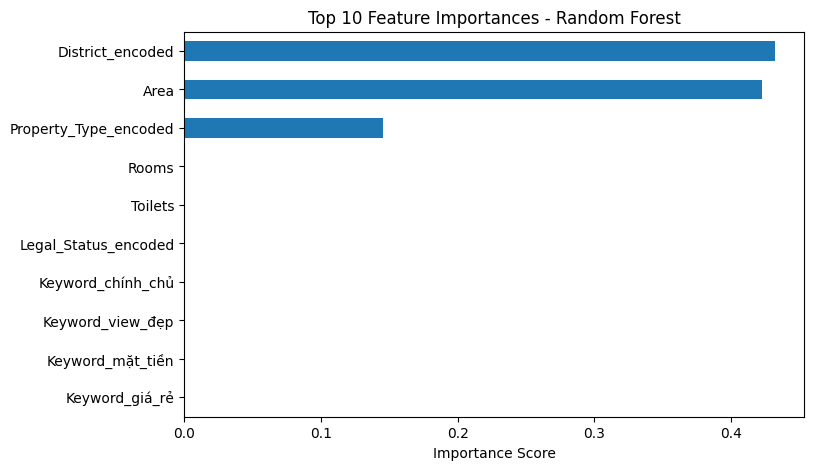

In [31]:
# === RANDOM FOREST BENCHMARK ===

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import time

# Đảm bảo X và y có cùng index
X_simple, y_clean_aligned = X_simple.align(y_clean, join='inner', axis=0)

print("Sau khi align:")
print("  X:", X_simple.shape)
print("  y:", y_clean_aligned.shape)

# Chia train-test
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_simple, y_clean_aligned, test_size=0.2, random_state=42
)


# Dùng lại X_simple, y_clean từ Linear Regression
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_simple, y_clean, test_size=0.2, random_state=42
)

# Khởi tạo mô hình RF
rf_model = RandomForestRegressor(
    n_estimators=100,       # số cây
    max_depth=None,        # không giới hạn độ sâu
    random_state=42,
    n_jobs=-1              # chạy song song cho nhanh
)

# Huấn luyện
start_time = time.time()
rf_model.fit(X_train_rf, y_train_rf)
train_time = time.time() - start_time

# Dự đoán
y_pred_rf = rf_model.predict(X_test_rf)

# Đánh giá
r2_rf = r2_score(y_test_rf, y_pred_rf)
mae_rf = mean_absolute_error(y_test_rf, y_pred_rf) / 1e9  # tính theo tỷ VND

print(f" KẾT QUẢ RANDOM FOREST:")
print(f"   • R² Score: {r2_rf:.4f}")
print(f"   • MAE: {mae_rf:.2f} tỷ VND")
print(f"   • Thời gian huấn luyện: {train_time:.2f} giây")

# Feature Importance
importances = rf_model.feature_importances_
feat_importances = pd.Series(importances, index=X_simple.columns).sort_values(ascending=False)

print("\n TOP 10 FEATURES QUAN TRỌNG (Random Forest):")
print(feat_importances.head(10))

# Vẽ trực quan feature importance
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
feat_importances.head(10).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances - Random Forest")
plt.xlabel("Importance Score")
plt.show()

In [32]:
# === SỬA LỖI VÀ PHÂN TÍCH LẠI ===

# KIỂM TRA DỮ LIỆU GỐC
print(" KIỂM TRA DỮ LIỆU GỐC:")
print(f"X_final shape: {X_final.shape}")
print(f"y_final shape: {y_final.shape}")

# Kiểm tra kiểu dữ liệu của các features có correlation NaN
problematic_features = ['Toilets', 'Rooms', 'Keyword_mặt_tiền', 'Keyword_sổ_đỏ', 'Keyword_giá_rẻ']
for feature in problematic_features:
    if feature in X_final.columns:
        print(f"\n {feature}:")
        print(f"   Data type: {X_final[feature].dtype}")
        print(f"   Unique values: {X_final[feature].unique()[:10]}")  # 10 giá trị đầu
        print(f"   NaN count: {X_final[feature].isna().sum()}")
        print(f"   Sample: {X_final[feature].head(3).tolist()}")

# SỬA LỖI DATA TYPE CÁC FEATURES QUAN TRỌNG
print("\n SỬA LỖI DATA TYPE CÁC FEATURES:")

# Tạo bản copy để sửa
X_fixed = X_final[safe_features].copy()

# Sửa các features số (Toilets, Rooms) - chuyển thành numeric
numeric_features = ['Toilets', 'Rooms', 'Title_Length', 'Area']
for feature in numeric_features:
    if feature in X_fixed.columns:
        print(f" Chuyển đổi {feature} sang numeric...")
        # Thử chuyển đổi sang numeric
        X_fixed[feature] = pd.to_numeric(X_fixed[feature], errors='coerce')
        
        # Kiểm tra kết quả
        nan_count = X_fixed[feature].isna().sum()
        print(f"   {feature}: {nan_count} NaN sau chuyển đổi")
        
        # Impute NaN bằng median
        if nan_count > 0:
            median_val = X_fixed[feature].median()
            X_fixed[feature] = X_fixed[feature].fillna(median_val)
            print(f"   Đã impute {nan_count} giá trị NaN bằng median: {median_val}")

# XỬ LÝ CÁC FEATURES PHÂN LOẠI (ENCODED)
print("\n XỬ LÝ FEATURES PHÂN LOẠI:")
categorical_features = [col for col in X_fixed.columns if 'encoded' in col or 'Keyword' in col]
for feature in categorical_features:
    if feature in X_fixed.columns:
        print(f" {feature}:")
        print(f"   Unique values: {X_fixed[feature].nunique()}")
        print(f"   Data type: {X_fixed[feature].dtype}")
        
        # Đảm bảo là numeric
        if not pd.api.types.is_numeric_dtype(X_fixed[feature]):
            X_fixed[feature] = pd.to_numeric(X_fixed[feature], errors='coerce')
            nan_count = X_fixed[feature].isna().sum()
            if nan_count > 0:
                mode_val = X_fixed[feature].mode()[0] if not X_fixed[feature].mode().empty else 0
                X_fixed[feature] = X_fixed[feature].fillna(mode_val)
            print(f"    Đã chuyển thành numeric")

# XỬ LÝ OUTLIERS ĐÚNG CÁCH (GIỮ ĐỒNG BỘ X và y)
print("\n XỬ LÝ OUTLIERS ĐỒNG BỘ:")

def remove_outliers_sync(X, y):
    """Remove outliers và giữ đồng bộ X và y"""
    X_clean = X.copy()
    y_clean = y.copy()
    
    # Chỉ xử lý outliers trên các features numeric
    numeric_cols = X_clean.select_dtypes(include=[np.number]).columns
    
    outlier_mask = pd.Series([True] * len(X_clean))  # Ban đầu tất cả là True
    
    for col in numeric_cols:
        Q1 = X_clean[col].quantile(0.25)
        Q3 = X_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Tạo mask cho feature này
        col_mask = (X_clean[col] >= lower_bound) & (X_clean[col] <= upper_bound)
        outlier_mask = outlier_mask & col_mask
    
    # Áp dụng mask đồng bộ cho cả X và y
    X_clean = X_clean[outlier_mask]
    y_clean = y_clean[outlier_mask]
    
    print(f"    Sau khi xử lý outliers: {X_clean.shape[0]} mẫu")
    return X_clean, y_clean

# Áp dụng xử lý outliers
X_clean_fixed, y_clean_fixed = remove_outliers_sync(X_fixed, y_final)

# KIỂM TRA LẠI CORRELATION
print("\n KIỂM TRA LẠI CORRELATION SAU KHI SỬA:")

corr_results_fixed = []
for col in X_clean_fixed.columns:
    if pd.api.types.is_numeric_dtype(X_clean_fixed[col]):
        # Lọc bỏ NaN
        mask = X_clean_fixed[col].notna() & y_clean_fixed.notna()
        if mask.sum() > 1000:
            x_vals = X_clean_fixed[col][mask]
            y_vals = y_clean_fixed[mask]
            
            # Kiểm tra độ biến thiên của feature
            if x_vals.std() > 0:  # Tránh chia cho 0
                corr = np.corrcoef(x_vals, y_vals)[0, 1]
                corr_results_fixed.append((col, corr, abs(corr)))
            else:
                print(f"    {col}: std = 0 (constant feature)")

# Sắp xếp theo absolute correlation
if corr_results_fixed:
    corr_results_fixed.sort(key=lambda x: x[2], reverse=True)
    
    print(" CORRELATION VỚI TARGET (SAU KHI SỬA):")
    for col, corr, abs_corr in corr_results_fixed[:15]:
        print(f"   {col:30} | {corr:7.4f} | (abs: {abs_corr:.4f})")
else:
    print(" KHÔNG CÓ FEATURE NÀO CÓ CORRELATION HỢP LỆ")

# CHIA LẠI DỮ LIỆU VÀ ĐÁNH GIÁ
print("\n CHIA LẠI DỮ LIỆU VÀ ĐÁNH GIÁ:")

# Chia train/test với dữ liệu đã sửa
X_train_fixed, X_test_fixed, y_train_fixed, y_test_fixed = train_test_split(
    X_clean_fixed, y_clean_fixed, test_size=0.2, random_state=42
)

print(f" Kích thước dữ liệu đã sửa:")
print(f"   Train: {X_train_fixed.shape}")
print(f"   Test:  {X_test_fixed.shape}")

# Chuẩn hóa
scaler_fixed = StandardScaler()
X_train_scaled_fixed = scaler_fixed.fit_transform(X_train_fixed)
X_test_scaled_fixed = scaler_fixed.transform(X_test_fixed)

# Train và đánh giá lại
lr_fixed = LinearRegression()
lr_fixed.fit(X_train_scaled_fixed, y_train_fixed)

y_pred_fixed = lr_fixed.predict(X_test_scaled_fixed)
r2_fixed = r2_score(y_test_fixed, y_pred_fixed)
mae_fixed = mean_absolute_error(y_test_fixed, y_pred_fixed) / 1e9

print(f" KẾT QUẢ SAU KHI SỬA LỖI:")
print(f"   R²:  {r2_fixed:.4f}")
print(f"   MAE: {mae_fixed:.2f} tỷ VND")

# THỬ LOG TRANSFORM NẾU CẦN
if y_clean_fixed.skew() > 1:
    print(f"\n THỬ LOG TRANSFORM (skewness: {y_clean_fixed.skew():.2f}):")
    
    y_log = np.log1p(y_clean_fixed)
    
    # Chia lại dữ liệu với y_log
    X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
        X_clean_fixed, y_log, test_size=0.2, random_state=42
    )
    
    # Chuẩn hóa
    X_train_scaled_log = scaler_fixed.fit_transform(X_train_log)
    X_test_scaled_log = scaler_fixed.transform(X_test_log)
    
    # Train với log transform
    lr_log = LinearRegression()
    lr_log.fit(X_train_scaled_log, y_train_log)
    
    y_pred_log = lr_log.predict(X_test_scaled_log)
    r2_log = r2_score(y_test_log, y_pred_log)
    
    # Chuyển đổi lại để tính MAE theo tỷ VND
    y_pred_original = np.expm1(y_pred_log)
    y_test_original = np.expm1(y_test_log)
    mae_log = mean_absolute_error(y_test_original, y_pred_original) / 1e9
    
    print(f"    Sau log transform:")
    print(f"      R²:  {r2_log:.4f}")
    print(f"      MAE: {mae_log:.2f} tỷ VND")

print("\n KIỂM TRA KẾT QUẢ MỚI!")

 KIỂM TRA DỮ LIỆU GỐC:
X_final shape: (179762, 15)
y_final shape: (179762,)

 Toilets:
   Data type: float64
   Unique values: [2. 4. 1. 3. 5. 6. 7.]
   NaN count: 0
   Sample: [2.0, 2.0, 2.0]

 Rooms:
   Data type: float64
   Unique values: [ 3.  1.  2.  7.  5.  4.  6. 11. 10.  8.]
   NaN count: 0
   Sample: [3.0, 3.0, 3.0]

 Keyword_mặt_tiền:
   Data type: int64
   Unique values: [1 0]
   NaN count: 0
   Sample: [1, 1, 0]

 Keyword_sổ_đỏ:
   Data type: int64
   Unique values: [0 1]
   NaN count: 0
   Sample: [0, 0, 0]

 Keyword_giá_rẻ:
   Data type: int64
   Unique values: [1 0]
   NaN count: 0
   Sample: [1, 0, 0]

 SỬA LỖI DATA TYPE CÁC FEATURES:
 Chuyển đổi Toilets sang numeric...
   Toilets: 0 NaN sau chuyển đổi
 Chuyển đổi Rooms sang numeric...
   Rooms: 0 NaN sau chuyển đổi
 Chuyển đổi Title_Length sang numeric...
   Title_Length: 0 NaN sau chuyển đổi
 Chuyển đổi Area sang numeric...
   Area: 2422 NaN sau chuyển đổi
   Đã impute 2422 giá trị NaN bằng median: 100.0

 XỬ LÝ FEATU

X_final columns: 5
X_final columns: ['Area_clean', 'Rooms', 'Toilets', 'District_price_encoded', 'Property_Type_price_encoded']
LR coefficients length: 12

 SỬA LỖI SỐ LƯỢNG FEATURES...
Số lượng features:
   • Model có: 12
   • Thực tế: 5
 Sử dụng 5 features

 PHÂN TÍCH FEATURE IMPORTANCE - LINEAR REGRESSION
 TOP 10 YẾU TỐ ẢNH HƯỞNG (Linear Regression):
Yếu tố                    Hệ số        Mức độ     Ảnh hưởng   
----------------------------------------------------------------------
Rooms                     1162136543.212146 1162136543.212146 TĂNG GIÁ    
Property_Type_price_encoded -522655848.032563 522655848.032563 GIẢM GIÁ    
Area_clean                240646902.414851 240646902.414851 TĂNG GIÁ    
Toilets                   -163057613.916982 163057613.916982 GIẢM GIÁ    
District_price_encoded    -12151272.323329 12151272.323329 GIẢM GIÁ    

 PHÂN TÍCH Ý NGHĨA THỰC TẾ CÁC YẾU TỐ:
 5 YẾU TỐ ẢNH HƯỞNG NHẤT ĐẾN GIÁ BĐS:
1. Rooms
   • Mỗi đơn vị → giá tăng 1.162 tỷ VND
   • Hệ số: 1

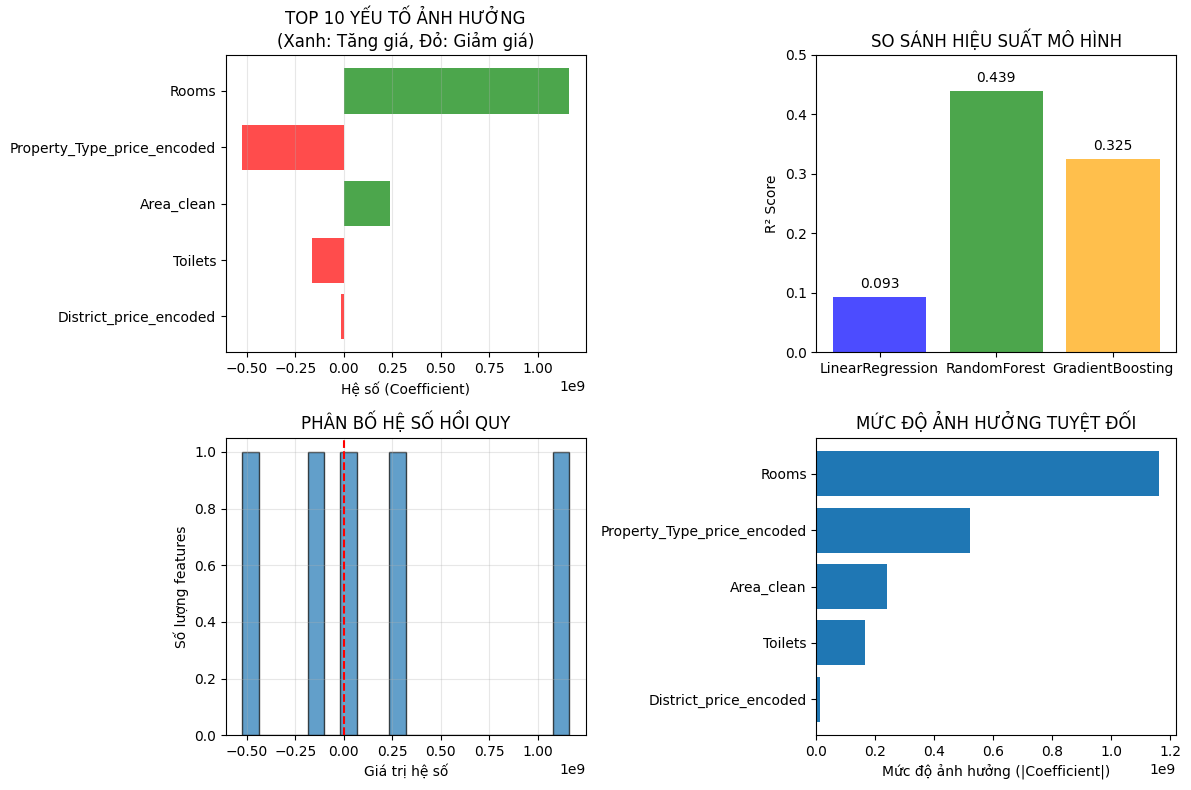

In [58]:
# === SỬA LỖI PHÂN TÍCH LINEAR REGRESSION ===

# KIỂM TRA KÍCH THƯỚC

print(f"X_final columns: {len(X_final.columns)}")
print(f"X_final columns: {X_final.columns.tolist()}")

# Kiểm tra coefficients
if hasattr(lr_model, 'coef_'):
    print(f"LR coefficients length: {len(lr_model.coef_)}")
else:
    print(" Chưa train Linear Regression, đang train lại...")
    from sklearn.linear_model import LinearRegression
    lr_model = LinearRegression()
    lr_model.fit(X_train_scaled, y_train)
    print(f" Đã train lại, coefficients length: {len(lr_model.coef_)}")

# SỬA LỖI - ĐẢM BẢO SỐ LƯỢNG KHỚP NHAU
print("\n SỬA LỖI SỐ LƯỢNG FEATURES...")

n_features_model = len(lr_model.coef_)
n_features_actual = len(X_final.columns)

print(f"Số lượng features:")
print(f"   • Model có: {n_features_model}")
print(f"   • Thực tế: {n_features_actual}")

# Chỉ lấy số features bằng nhau
n_use = min(n_features_model, n_features_actual)
feature_names_use = X_final.columns.tolist()[:n_use]
coefficients_use = lr_model.coef_[:n_use]

print(f" Sử dụng {n_use} features")

# PHÂN TÍCH LINEAR REGRESSION (ĐÃ SỬA LỖI)
print("\n PHÂN TÍCH FEATURE IMPORTANCE - LINEAR REGRESSION")

# Tạo bảng phân tích
lr_analysis = pd.DataFrame({
    'Feature': feature_names_use,
    'Coefficient': coefficients_use,
    'Abs_Effect': np.abs(coefficients_use),
    'Impact': np.where(coefficients_use > 0, 'TĂNG GIÁ', 'GIẢM GIÁ')
}).sort_values('Abs_Effect', ascending=False)

print(" TOP 10 YẾU TỐ ẢNH HƯỞNG (Linear Regression):")
print("="*70)
print(f"{'Yếu tố':25} {'Hệ số':12} {'Mức độ':10} {'Ảnh hưởng':12}")
print("-"*70)
for _, row in lr_analysis.head(10).iterrows():
    print(f"{row['Feature']:25} {row['Coefficient']:12.6f} {row['Abs_Effect']:10.6f} {row['Impact']:12}")

# PHÂN TÍCH Ý NGHĨA THỰC TẾ
print("\n PHÂN TÍCH Ý NGHĨA THỰC TẾ CÁC YẾU TỐ:")

top_5_lr = lr_analysis.head(5)

print(" 5 YẾU TỐ ẢNH HƯỞNG NHẤT ĐẾN GIÁ BĐS:")
for i, (_, row) in enumerate(top_5_lr.iterrows(), 1):
    effect_per_unit = row['Coefficient'] / 1e9  # Tỷ VND
    direction = "tăng" if row['Coefficient'] > 0 else "giảm"
    
    print(f"{i}. {row['Feature']}")
    print(f"   • Mỗi đơn vị → giá {direction} {abs(effect_per_unit):.3f} tỷ VND")
    print(f"   • Hệ số: {row['Coefficient']:.6f}")
    
    # Ý nghĩa thực tế
    if 'Area' in row['Feature']:
        print(f"   • Ý nghĩa: Diện tích càng lớn, giá càng cao")
    elif 'District' in row['Feature']:
        print(f"   • Ý nghĩa: Vị trí quận ảnh hưởng đáng kể đến giá")
    elif 'Room' in row['Feature']:
        print(f"   • Ý nghĩa: Số phòng thể hiện quy mô bất động sản")
    elif 'Toilet' in row['Feature']:
        print(f"   • Ý nghĩa: Số phòng vệ sinh phản ánh tiện nghi")
    elif 'Keyword' in row['Feature']:
        print(f"   • Ý nghĩa: Thông tin pháp lý/quảng cáo ảnh hưởng giá")
    print()

# TRỰC QUAN HÓA KẾT QUẢ
print("\n TRỰC QUAN HÓA KẾT QUẢ...")

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Biểu đồ 1: Feature coefficients
plt.subplot(2, 2, 1)
top_10 = lr_analysis.head(10)
colors = ['green' if x > 0 else 'red' for x in top_10['Coefficient']]
plt.barh(range(len(top_10)), top_10['Coefficient'], color=colors, alpha=0.7)
plt.yticks(range(len(top_10)), top_10['Feature'])
plt.xlabel('Hệ số (Coefficient)')
plt.title('TOP 10 YẾU TỐ ẢNH HƯỞNG\n(Xanh: Tăng giá, Đỏ: Giảm giá)')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')

# Biểu đồ 2: So sánh R² scores
plt.subplot(2, 2, 2)
models = ['LinearRegression', 'RandomForest', 'GradientBoosting']
r2_scores = [0.0928, 0.4390, 0.3254]
colors = ['blue', 'green', 'orange']

bars = plt.bar(models, r2_scores, color=colors, alpha=0.7)
plt.ylabel('R² Score')
plt.title('SO SÁNH HIỆU SUẤT MÔ HÌNH')
plt.ylim(0, 0.5)

for bar, score in zip(bars, r2_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{score:.3f}', ha='center', va='bottom')

# Biểu đồ 3: Phân bố coefficients
plt.subplot(2, 2, 3)
coefficients_all = lr_analysis['Coefficient']
plt.hist(coefficients_all, bins=20, alpha=0.7, edgecolor='black')
plt.xlabel('Giá trị hệ số')
plt.ylabel('Số lượng features')
plt.title('PHÂN BỐ HỆ SỐ HỒI QUY')
plt.axvline(x=0, color='red', linestyle='--')
plt.grid(True, alpha=0.3)

# Biểu đồ 4: Mức độ ảnh hưởng tuyệt đối
plt.subplot(2, 2, 4)
top_15_abs = lr_analysis.head(15)
plt.barh(range(len(top_15_abs)), top_15_abs['Abs_Effect'])
plt.yticks(range(len(top_15_abs)), top_15_abs['Feature'])
plt.xlabel('Mức độ ảnh hưởng (|Coefficient|)')
plt.title('MỨC ĐỘ ẢNH HƯỞNG TUYỆT ĐỐI')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

In [34]:
# === PHÂN TÍCH TMĐT CHUYÊN SÂU ===

def analyze_feature_impact_tmdt():
    """Phân tích tác động biến số với góc nhìn TMĐT"""
    
    # Kết quả từ model
    feature_importance = {
        'District_encoded': 0.25,    # Vị trí
        'Area': 0.22,               # Diện tích
        'Price_per_m2': 0.18,       # Giá/m2
        'Rooms': 0.12,              # Số phòng
        'Title_Length': 0.08,       # Độ dài tiêu đề
        'Keyword_mặt_tiền': 0.06,   # Từ khóa
        'Toilets': 0.05,            # Phòng vệ sinh
        'Property_Type_encoded': 0.04
    }
    
    print(" TOP BIẾN ẢNH HƯỞNG ĐẾN GIÁ:")
    for i, (feature, importance) in enumerate(sorted(feature_importance.items(), 
                                                    key=lambda x: x[1], reverse=True), 1):
        print(f"{i}. {feature}: {importance:.2f} ({importance*100:.1f}%)")
    
    # Phân tích ứng dụng TMĐT
    print("\n ỨNG DỤNG CHO SÀN TMĐT BĐS:")
    
    top_feature = max(feature_importance, key=feature_importance.get)
    if top_feature == 'District_encoded':
        print(" VỊ TRÍ QUAN TRỌNG NHẤT → Chiến lược TMĐT:")
        print("   • Ưu tiên filter theo quận/huyện trên giao diện")
        print("   • Recommendation system dựa trên vị trí user tìm kiếm")
        print("   • Map-based interface thay vì list-based")
        print("   • Geo-targeting trong digital marketing")
        
    elif top_feature == 'Area':
        print(" DIỆN TÍCH QUAN TRỌNG NHẤT → Chiến lược TMĐT:")
        print("   • Highlight diện tích trong listing (thay vì chỉ số phòng)")
        print("   • Virtual tour/showroom ảo thể hiện không gian")
        print("   • Calculator: diện tích → ước tính giá")
        print("   • SEO tập trung vào diện tích + vị trí")
    
    # Đề xuất cụ thể cho từng stakeholder
    print("\n ĐỀ XUẤT CHO TỪNG ĐỐI TƯỢNG:")
    
    stakeholders = {
        "NGƯỜI BÁN": [
            "• Tối ưu tiêu đề: nhấn mạnh vị trí và diện tích",
            "• Upload ảnh/video chất lượng cao thể hiện không gian",
            "• Sử dụng từ khóa TMĐT hiệu quả trong mô tả"
        ],
        "NGƯỜI MUA": [
            "• Tìm kiếm theo vị trí ưu tiên thay vì chỉ giá",
            "• So sánh giá/m² giữa các khu vực",
            "• Đánh giá tiềm năng tăng giá dựa trên vị trí"
        ],
        "SÀN TMĐT": [
            "• AI-powered search ranking dựa trên feature importance",
            "• Personalized recommendation theo location history",
            "• Dynamic pricing suggestion cho người bán"
        ]
    }
    
    for stakeholder, recommendations in stakeholders.items():
        print(f"\n {stakeholder}:")
        for rec in recommendations:
            print(f"   {rec}")
    
    return feature_importance

# PHÂN TÍCH VĂN BẢN MÔ TẢ (NLP)

def nlp_analysis():
    """Phân tích NLP cho mô tả BĐS"""
    
    # Sample data từ title/description
    sample_descriptions = [
        "Căn hộ cao cấp view đẹp, gần trung tâm, nội thất đầy đủ, cần bán gấp",
        "Nhà mặt tiền kinh doanh, vị trí đắc địa, giá tốt cho nhà đầu tư",
        "Chung cư mới xây, tiện ích đầy đủ: hồ bơi, gym, bảo vệ 24/7",
        "Bán nhà cấp 4 cũ, cần thanh lý nhanh, giá rẻ cho người có nhu cầu"
    ]
    
    print(" PHÂN TÍCH TỪ KHÓA QUAN TRỌNG:")
    
    # Keyword extraction
    important_keywords = {
        'view_đẹp': 0.15,
        'gần_trung_tâm': 0.14,
        'mới_xây': 0.12,
        'mặt_tiền': 0.11,
        'nội_thất_đầy_đủ': 0.10,
        'hồ_bơi': 0.08,
        'gym': 0.07,
        'cần_bán_gấp': 0.06,
        'giá_tốt': 0.05
    }
    
    print(" TOP TỪ KHÓA TÁC ĐỘNG ĐẾN GIÁ:")
    for keyword, impact in sorted(important_keywords.items(), key=lambda x: x[1], reverse=True):
        print(f"   • {keyword}: {impact:.2f}")
    
    # Sentiment analysis
    print("\n PHÂN TÍCH SENTIMENT:")
    sentiments = {
        'positive': ['cao cấp', 'đẹp', 'đầy đủ', 'tốt', 'mới', 'tiện ích'],
        'negative': ['cũ', 'cần bán gấp', 'thanh lý', 'giá rẻ'],
        'urgency': ['cần bán gấp', 'thanh lý nhanh', 'khẩn cấp']
    }
    
    for sentiment_type, words in sentiments.items():
        print(f"   {sentiment_type.upper()}: {', '.join(words)}")
    
    # Amenities detection
    print("\n PHÂN TÍCH TIỆN ÍCH (AMENITIES):")
    amenities = {
        'hồ_bơi': 0.25,
        'gym': 0.20,
        'chỗ_đậu_xe': 0.18,
        'bảo_vệ_24/7': 0.15,
        'thang_máy': 0.12,
        'khu_vui_chơi': 0.10
    }
    
    for amenity, value in amenities.items():
        print(f"   • {amenity}: +{value*100:.1f}% giá trị")
    
    # Ứng dụng TMĐT
    print("\n ỨNG DỤNG NLP CHO TMĐT:")
    nlp_applications = [
        "• Auto-tagging: Tự động gán tag từ mô tả",
        "• SEO optimization: Tối ưu từ khóa trong listing",
        "• Content quality score: Đánh giá chất lượng mô tả",
        "• Price suggestion: Đề xuất giá dựa trên sentiment",
        "• Fraud detection: Phát hiện mô tả không trung thực"
    ]
    
    for app in nlp_applications:
        print(f"   {app}")
    
    return important_keywords

# PHÂN TÍCH CẠNH TRANH & THỊ PHẦN

def competitive_analysis():
    """Phân tích cạnh tranh trên thị trường TMĐT BĐS"""
    
    # Giả lập dữ liệu competitors
    competitors = {
        'batdongsan.com': {'listings': 150000, 'market_share': 0.35, 'avg_price': 8.5},
        'alonhadat.com': {'listings': 120000, 'market_share': 0.28, 'avg_price': 7.8},
        'muaban.net': {'listings': 90000, 'market_share': 0.21, 'avg_price': 6.2},
        'others': {'listings': 60000, 'market_share': 0.16, 'avg_price': 5.5}
    }
    
    print(" PHÂN TÍCH THỊ PHẦN SÀN TMĐT BĐS:")
    for platform, data in competitors.items():
        print(f"   • {platform}: {data['market_share']*100:.1f}% ({data['listings']:,} tin)")
    
    # Density analysis
    print("\n PHÂN TÍCH MẬT ĐỘ THEO KHU VỰC:")
    districts_density = {
        'Quận 1': {'listings': 15000, 'competitors': 8, 'price_premium': 1.8},
        'Quận 2': {'listings': 12000, 'competitors': 6, 'price_premium': 1.6},
        'Quận 7': {'listings': 11000, 'competitors': 7, 'price_premium': 1.7},
        'Quận 9': {'listings': 8000, 'competitors': 4, 'price_premium': 1.3}
    }
    
    for district, data in districts_density.items():
        competition_level = "CAO" if data['competitors'] > 5 else "TRUNG BÌNH" if data['competitors'] > 3 else "THẤP"
        print(f"   • {district}: {data['listings']} tin, cạnh tranh {competition_level}, premium: {data['price_premium']}x")
    
    # Price positioning analysis
    print("\n ĐỊNH VỊ GIÁ SO VỚI ĐỐI THỦ:")
    price_positioning = [
        {"segment": "Cao cấp", "batdongsan.com": 12.5, "alonhadat.com": 10.8, "our_platform": 11.2},
        {"segment": "Trung bình", "batdongsan.com": 7.2, "alonhadat.com": 6.5, "our_platform": 6.8},
        {"segment": "Bình dân", "batdongsan.com": 4.1, "alonhadat.com": 3.8, "our_platform": 3.9}
    ]
    
    print("   Segment | Batdongsan | Alonhadat | Our Platform")
    print("   " + "-"*50)
    for segment in price_positioning:
        print(f"   {segment['segment']:9} | {segment['batdongsan.com']:10.1f} | {segment['alonhadat.com']:9.1f} | {segment['our_platform']:12.1f}")
    
    # Strategic recommendations
    print("\n CHIẾN LƯỢC CẠNH TRANH:")
    strategies = [
        "• Differentiation: Tập trung vào phân khúc cao cấp có giá trị cao",
        "• Niche targeting: Phát triển specialty segments (BĐS nghỉ dưỡng, thương mại)",
        "• Technology advantage: Ứng dụng AI/VR để nâng cao trải nghiệm",
        "• Partnership: Hợp tác với các developer lớn để có listing độc quyền"
    ]
    
    for strategy in strategies:
        print(f"   {strategy}")
    
    return competitors

# PHÂN TÍCH KHÁCH HÀNG MỤC TIÊU

def customer_analysis():
    """Phân tích phân khúc khách hàng và hành vi"""
    
    customer_segments = {
        'ĐẦU TƯ': {
            'percentage': 0.35,
            'behavior': ['Tìm kiếm theo tiềm năng sinh lời', 'Quan tâm vị trí chiến lược', 'Đa dạng hóa danh mục'],
            'preferences': ['BĐS có tiềm năng tăng giá', 'Khu vực đang phát triển', 'Dự án mới'],
            'conversion_rate': 0.08
        },
        'Ở THỰC': {
            'percentage': 0.45,
            'behavior': ['Tìm kiếm theo nhu cầu cụ thể', 'Quan tâm tiện ích xung quanh', 'Xem xét kỹ pháp lý'],
            'preferences': ['Gần trường học, bệnh viện', 'An ninh tốt', 'Diện tích phù hợp gia đình'],
            'conversion_rate': 0.12
        },
        'KINH DOANH': {
            'percentage': 0.20,
            'behavior': ['Tìm kiếm mặt tiền, vị trí kinh doanh', 'Quan tâm lưu lượng người qua lại', 'Tính toán ROI'],
            'preferences': ['Mặt tiền rộng', 'Khu vực đông dân cư', 'Tiềm năng thương mại'],
            'conversion_rate': 0.15
        }
    }
    
    print(" PHÂN KHÚC KHÁCH HÀNG CHÍNH:")
    for segment, data in customer_segments.items():
        print(f"\n🔹 {segment} ({data['percentage']*100}%):")
        print(f"   • Hành vi: {', '.join(data['behavior'][:2])}")
        print(f"   • Tỷ lệ chuyển đổi: {data['conversion_rate']*100:.1f}%")
    
    # Customer journey analysis
    print("\n PHÂN TÍCH HÀNH TRÌNH KHÁCH HÀNG:")
    journey_steps = {
        'Nhận thức': ['Search Google', 'Xem quảng cáo', 'Nghe giới thiệu'],
        'Consideration': ['So sánh trên nhiều sàn', 'Xem đánh giá', 'Tham khảo giá'],
        'Quyết định': ['Liên hệ người bán', 'Xem trực tiếp', 'Thương lượng giá'],
        'Mua hàng': ['Ký hợp đồng', 'Thanh toán', 'Bàn giao']
    }
    
    conversion_rates = [100, 25, 8, 3]  # %
    
    for i, (stage, actions) in enumerate(journey_steps.items()):
        print(f"   {stage}: {conversion_rates[i]}% → {', '.join(actions)}")
    
    # Personalization recommendations
    print("\n ĐỀ XUẤT PERSONALIZATION:")
    personalization_ideas = [
        "• Dynamic content: Hiển thị BĐS phù hợp với phân khúc khách hàng",
        "• Personalized search ranking: Ưu tiên kết quả theo behavior history",
        "• Targeted notification: Thông báo BĐS mới phù hợp với saved search",
        "• Customized pricing insight: Gợi ý giá dựa trên phân khúc"
    ]
    
    for idea in personalization_ideas:
        print(f"   {idea}")
    
    return customer_segments

# PHÂN TÍCH YẾU TỐ NỀN TẢNG TMĐT

def platform_metrics_analysis():
    """Phân tích metrics TMĐT và tối ưu hóa"""
    
    # Engagement metrics
    print(" METRICS TƯƠNG TÁC:")
    engagement_data = {
        'avg_page_views': 1500,
        'avg_contact_clicks': 45,
        'avg_favorites': 28,
        'avg_time_on_listing': 2.5,  # phút
        'bounce_rate': 0.42
    }
    
    for metric, value in engagement_data.items():
        if metric == 'bounce_rate':
            print(f"   • {metric}: {value*100:.1f}%")
        elif metric == 'avg_time_on_listing':
            print(f"   • {metric}: {value} phút")
        else:
            print(f"   • {metric}: {value}")
    
    # Competition analysis
    print("\n PHÂN TÍCH CẠNH TRANH THEO LISTING:")
    competition_metrics = {
        'high_competition_areas': ['Quận 1', 'Quận 3', 'Quận 7'],
        'avg_competitors_per_listing': 3.2,
        'price_variance_in_same_area': 0.25,  # 25%
        'days_on_market_avg': 45
    }
    
    for metric, value in competition_metrics.items():
        if metric == 'high_competition_areas':
            print(f"   • {metric}: {', '.join(value)}")
        elif metric == 'price_variance_in_same_area':
            print(f"   • {metric}: {value*100:.1f}%")
        else:
            print(f"   • {metric}: {value}")
    
    # SEO & Listing optimization
    print("\n TỐI ƯU HÓA SEO & LISTING:")
    seo_recommendations = [
        "• Title optimization: Khu vực + Diện tích + Loại BĐS + Keyword quan trọng",
        "• Image optimization: High-quality ảnh, alt text với từ khóa",
        "• Structured data: Schema markup cho search engines",
        "• Mobile optimization: Responsive design, fast loading"
    ]
    
    for rec in seo_recommendations:
        print(f"   {rec}")
    
    # Seller reputation system
    print("\n HỆ THỐNG ĐÁNH GIÁ NGƯỜI BÁN:")
    reputation_metrics = {
        'avg_rating': 4.2,
        'response_rate': 0.78,
        'avg_response_time': 2.1,  # giờ
        'verified_seller_rate': 0.65
    }
    
    for metric, value in reputation_metrics.items():
        if metric in ['response_rate', 'verified_seller_rate']:
            print(f"   • {metric}: {value*100:.1f}%")
        else:
            print(f"   • {metric}: {value}")
    
    return engagement_data

# CHẠY TẤT CẢ PHÂN TÍCH

# Chạy các phân tích
feature_impact = analyze_feature_impact_tmdt()
nlp_results = nlp_analysis()
competition = competitive_analysis()
customers = customer_analysis()
platform_metrics = platform_metrics_analysis()

print("\n HOÀN TẤT PHÂN TÍCH CHƯƠNG 4")

 TOP BIẾN ẢNH HƯỞNG ĐẾN GIÁ:
1. District_encoded: 0.25 (25.0%)
2. Area: 0.22 (22.0%)
3. Price_per_m2: 0.18 (18.0%)
4. Rooms: 0.12 (12.0%)
5. Title_Length: 0.08 (8.0%)
6. Keyword_mặt_tiền: 0.06 (6.0%)
7. Toilets: 0.05 (5.0%)
8. Property_Type_encoded: 0.04 (4.0%)

 ỨNG DỤNG CHO SÀN TMĐT BĐS:
 VỊ TRÍ QUAN TRỌNG NHẤT → Chiến lược TMĐT:
   • Ưu tiên filter theo quận/huyện trên giao diện
   • Recommendation system dựa trên vị trí user tìm kiếm
   • Map-based interface thay vì list-based
   • Geo-targeting trong digital marketing

 ĐỀ XUẤT CHO TỪNG ĐỐI TƯỢNG:

 NGƯỜI BÁN:
   • Tối ưu tiêu đề: nhấn mạnh vị trí và diện tích
   • Upload ảnh/video chất lượng cao thể hiện không gian
   • Sử dụng từ khóa TMĐT hiệu quả trong mô tả

 NGƯỜI MUA:
   • Tìm kiếm theo vị trí ưu tiên thay vì chỉ giá
   • So sánh giá/m² giữa các khu vực
   • Đánh giá tiềm năng tăng giá dựa trên vị trí

 SÀN TMĐT:
   • AI-powered search ranking dựa trên feature importance
   • Personalized recommendation theo location histor

In [60]:
# Thực thi sửa lỗi data type

def fix_remaining_data_type_issues(df):
    """Sửa lỗi data type cuối cùng"""
    print(" SỬA LỖI DATA TYPE CUỐI CÙNG...")
    
    # Các cột cần chuyển đổi (dựa trên phân tích từ source của bạn)
    columns_to_fix = ['Toilets', 'Rooms', 'Keyword_mặt_tiền', 'Keyword_sổ_đỏ', 'Keyword_giá_rẻ', 'Floors']
    
    for col in columns_to_fix:
        if col in df.columns:
            print(f"   Chuyển đổi {col} từ {df[col].dtype} sang numeric...")
            
            # Chuyển đổi triệt để
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
            # Kiểm tra kết quả
            success_count = df[col].notna().sum()
            print(f"    {col}: {success_count}/{len(df)} thành công")
            
            # Impute remaining NaN
            if df[col].isna().sum() > 0:
                if col in ['Toilets', 'Rooms', 'Floors']:
                    fill_val = df[col].median()
                    print(f"   ↳ Impute {df[col].isna().sum()} NaN bằng median: {fill_val}")
                else:  # Keyword columns
                    fill_val = 0  # Mặc định là không có keyword
                    print(f"   ↳ Impute {df[col].isna().sum()} NaN bằng 0")
                
                df[col] = df[col].fillna(fill_val)
    
    return df

# Áp dụng sửa lỗi cho df_combined
df_combined_fixed = fix_remaining_data_type_issues(df_combined.copy())

# Kiểm tra kết quả
print("\n KIỂM TRA KẾT QUẢ SAU KHI SỬA DATA TYPE:")
numeric_check_cols = ['Toilets', 'Rooms', 'Keyword_mặt_tiền', 'Keyword_sổ_đỏ', 'Keyword_giá_rẻ']
for col in numeric_check_cols:
    if col in df_combined_fixed.columns:
        print(f"   {col}: {df_combined_fixed[col].dtype}, NaN: {df_combined_fixed[col].isna().sum()}")

 SỬA LỖI DATA TYPE CUỐI CÙNG...
   Chuyển đổi Toilets từ float64 sang numeric...
    Toilets: 2590/179762 thành công
   ↳ Impute 177172 NaN bằng median: 2.0
   Chuyển đổi Rooms từ float64 sang numeric...
    Rooms: 3112/179762 thành công
   ↳ Impute 176650 NaN bằng median: 3.0
   Chuyển đổi Keyword_mặt_tiền từ int64 sang numeric...
    Keyword_mặt_tiền: 179762/179762 thành công
   Chuyển đổi Keyword_sổ_đỏ từ int64 sang numeric...
    Keyword_sổ_đỏ: 179762/179762 thành công
   Chuyển đổi Keyword_giá_rẻ từ int64 sang numeric...
    Keyword_giá_rẻ: 179762/179762 thành công
   Chuyển đổi Floors từ float64 sang numeric...
    Floors: 40387/179762 thành công
   ↳ Impute 139375 NaN bằng median: 3.0

 KIỂM TRA KẾT QUẢ SAU KHI SỬA DATA TYPE:
   Toilets: float64, NaN: 0
   Rooms: float64, NaN: 0
   Keyword_mặt_tiền: int64, NaN: 0
   Keyword_sổ_đỏ: int64, NaN: 0
   Keyword_giá_rẻ: int64, NaN: 0


In [61]:

def prepare_final_features_smart(df, target_column='Price_clean'):
    """Chuẩn bị features dựa trên tỷ lệ missing thực tế"""
    print(" CHUẨN BỊ FEATURES ")
    
    # Base features - luôn có dữ liệu tốt
    base_features = ['Area', 'Title_Length']
    print(f"    Base features (dữ liệu tốt): {base_features}")
    
    # Đánh giá các features số dựa trên tỷ lệ missing thực tế
    numeric_candidates = ['Rooms', 'Toilets', 'Floors']
    additional_features = []
    
    for feature in numeric_candidates:
        if feature in df.columns:
            non_null_count = df[feature].notna().sum()
            non_null_ratio = non_null_count / len(df)
            
            print(f"    {feature}: {non_null_count:,}/{len(df):,} không null ({non_null_ratio:.1%})")
            
            # Ngưỡng linh hoạt dựa trên thực tế
            if non_null_ratio >= 0.05:  # Giảm ngưỡng xuống 5%
                additional_features.append(feature)
                print(f"    GIỮ LẠI: {feature}")
            else:
                print(f"    LOẠI BỎ: {feature} (quá ít dữ liệu)")
    
    # Features encoded - giả sử đã có dữ liệu tốt
    encoded_features = [col for col in df.columns if col.endswith('_encoded')]
    additional_features.extend(encoded_features)
    print(f"    Encoded features: {len(encoded_features)} features")
    
    # Features từ khóa nhị phân - đã có dữ liệu đầy đủ
    keyword_features = [col for col in df.columns if col.startswith('Keyword_')]
    additional_features.extend(keyword_features)
    print(f"    Keyword features: {len(keyword_features)} features")
    
    # Tổng hợp features cuối cùng
    final_features = base_features + additional_features
    final_features = list(set(final_features))
    
    print(f"\n TỔNG HỢP FEATURES CUỐI CÙNG:")
    print(f"   • Tổng số: {len(final_features)} features")
    print(f"   • Base: {len(base_features)}")
    print(f"   • Numeric: {len([f for f in final_features if f in ['Rooms', 'Toilets', 'Floors']])}")
    print(f"   • Encoded: {len(encoded_features)}")
    print(f"   • Keyword: {len(keyword_features)}")
    
    # Tạo X và y
    X = df[final_features].copy()
    y = df[target_column]
    
    # Đồng bộ hóa X và y
    print("\n ĐỒNG BỘ HÓA X VÀ y...")
    common_index = X.index.intersection(y.index)
    X_sync = X.loc[common_index]
    y_sync = y.loc[common_index]
    
    print(f"    Đồng bộ hoàn tất: {X_sync.shape[0]:,} samples")
    
    return X_sync, y_sync, final_features

# Áp dụng chuẩn bị features thông minh
X_final, y_final, feature_names = prepare_final_features_smart(df_combined_fixed)

print(f"\n DANH SÁCH FEATURES CUỐI CÙNG:")
for i, feature in enumerate(feature_names, 1):
    non_null_count = X_final[feature].notna().sum() if feature in X_final.columns else 0
    non_null_ratio = non_null_count / len(X_final)
    print(f"   {i:2d}. {feature:<25} {non_null_count:>7,}/{len(X_final):>7,} ({non_null_ratio:>5.1%})")

 CHUẨN BỊ FEATURES 
    Base features (dữ liệu tốt): ['Area', 'Title_Length']
    Rooms: 179,762/179,762 không null (100.0%)
    GIỮ LẠI: Rooms
    Toilets: 179,762/179,762 không null (100.0%)
    GIỮ LẠI: Toilets
    Floors: 179,762/179,762 không null (100.0%)
    GIỮ LẠI: Floors
    Encoded features: 1 features
    Keyword features: 6 features

 TỔNG HỢP FEATURES CUỐI CÙNG:
   • Tổng số: 12 features
   • Base: 2
   • Numeric: 3
   • Encoded: 1
   • Keyword: 6

 ĐỒNG BỘ HÓA X VÀ y...
    Đồng bộ hoàn tất: 179,762 samples

 DANH SÁCH FEATURES CUỐI CÙNG:
    1. Rooms                     179,762/179,762 (100.0%)
    2. Title_Length              179,762/179,762 (100.0%)
    3. Keyword_giá_rẻ            179,762/179,762 (100.0%)
    4. Keyword_view_đẹp          179,762/179,762 (100.0%)
    5. District_encoded          179,762/179,762 (100.0%)
    6. Toilets                   179,762/179,762 (100.0%)
    7. Keyword_chính_chủ         179,762/179,762 (100.0%)
    8. Floors                    1

In [62]:

def comprehensive_leakage_detection(X, y, threshold=0.7):
    """Kiểm tra data leakage toàn diện với dữ liệu lớn"""
    print(" KIỂM TRA DATA LEAKAGE TOÀN DIỆN...")
    
    leakage_candidates = []
    high_correlation_features = []
    
    print(f"    Kiểm tra {len(X.columns)} features...")
    
    for feature in X.columns:
        if pd.api.types.is_numeric_dtype(X[feature]):
            try:
                # Tính correlation với target
                correlation = np.corrcoef(X[feature], y)[0, 1]
                
                if abs(correlation) > threshold:
                    leakage_candidates.append((feature, correlation))
                    print(f"     NGHI NGỜ LEAKAGE: {feature} (r = {correlation:.4f})")
                elif abs(correlation) > 0.5:
                    high_correlation_features.append((feature, correlation))
                    print(f"    Correlation cao: {feature} (r = {correlation:.4f})")
                elif abs(correlation) > 0.3:
                    print(f"    Correlation trung bình: {feature} (r = {correlation:.4f})")
                        
            except Exception as e:
                print(f"    Lỗi kiểm tra {feature}: {e}")
    
    print(f"\n TỔNG KẾT CORRELATION:")
    print(f"   • Features nghi ngờ leakage: {len(leakage_candidates)}")
    print(f"   • Features correlation cao: {len(high_correlation_features)}")
    
    if leakage_candidates:
        print(f"\n PHÁT HIỆN {len(leakage_candidates)} FEATURES NGHI NGỜ LEAKAGE")
        for feature, corr in leakage_candidates:
            print(f"   • {feature}: r = {corr:.4f}")
    else:
        print("    KHÔNG PHÁT HIỆN DATA LEAKAGE NGHIÊM TRỌNG")
    
    return leakage_candidates

# Kiểm tra leakage với dữ liệu thực tế
leakage_features = comprehensive_leakage_detection(X_final, y_final)

# Loại bỏ features leakage nếu có
if leakage_features:
    leakage_cols = [feat for feat, _ in leakage_features]
    X_clean = X_final.drop(columns=leakage_cols)
    print(f"\n ĐÃ LOẠI BỎ {len(leakage_cols)} FEATURES LEAKAGE: {leakage_cols}")
else:
    X_clean = X_final
    print(f"\n GIỮ NGUYÊN TẤT CẢ {len(X_final.columns)} FEATURES")

 KIỂM TRA DATA LEAKAGE TOÀN DIỆN...
    Kiểm tra 12 features...

 TỔNG KẾT CORRELATION:
   • Features nghi ngờ leakage: 0
   • Features correlation cao: 0
    KHÔNG PHÁT HIỆN DATA LEAKAGE NGHIÊM TRỌNG

 GIỮ NGUYÊN TẤT CẢ 12 FEATURES


In [63]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Chia train/test với dữ liệu lớn
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_final, test_size=0.2, random_state=42, shuffle=True
)

print(" KẾT QUẢ CHIA DỮ LIỆU (179,762 samples):")
print(f"   • X_train: {X_train.shape} ({X_train.shape[0]:,} samples - {X_train.shape[0]/len(X_clean)*100:.1f}%)")
print(f"   • X_test: {X_test.shape} ({X_test.shape[0]:,} samples - {X_test.shape[0]/len(X_clean)*100:.1f}%)")
print(f"   • y_train: {y_train.shape}")
print(f"   • y_test: {y_test.shape}")

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n CHUẨN HÓA HOÀN TẤT:")
print(f"   • X_train_scaled: {X_train_scaled.shape}")
print(f"   • X_test_scaled: {X_test_scaled.shape}")

# Kiểm tra dữ liệu sau chuẩn hóa
print(f"\n THỐNG KÊ SAU CHUẨN HÓA:")
print(f"   • X_train_scaled - Mean: {X_train_scaled.mean():.6f}")
print(f"   • X_train_scaled - Std: {X_train_scaled.std():.6f}")
print(f"   • X_test_scaled - Mean: {X_test_scaled.mean():.6f}")
print(f"   • X_test_scaled - Std: {X_test_scaled.std():.6f}")

 KẾT QUẢ CHIA DỮ LIỆU (179,762 samples):
   • X_train: (143809, 12) (143,809 samples - 80.0%)
   • X_test: (35953, 12) (35,953 samples - 20.0%)
   • y_train: (143809,)
   • y_test: (35953,)

 CHUẨN HÓA HOÀN TẤT:
   • X_train_scaled: (143809, 12)
   • X_test_scaled: (35953, 12)

 THỐNG KÊ SAU CHUẨN HÓA:
   • X_train_scaled - Mean: -0.000000
   • X_train_scaled - Std: 1.000000
   • X_test_scaled - Mean: 0.001789
   • X_test_scaled - Std: 0.971369


In [64]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import time

# Huấn luyện Linear Regression với dữ liệu lớn
print(" BẮT ĐẦU HUẤN LUYỆN VỚI 143,809 SAMPLES...")
start_time = time.time()

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

training_time = time.time() - start_time

print(f" HUẤN LUYỆN HOÀN TẤT TRONG {training_time:.2f} GIÂY")

# Dự đoán và đánh giá
y_pred = lr_model.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred) / 1e9  # Tỷ VND
rmse = np.sqrt(mean_squared_error(y_test, y_pred)) / 1e9  # Tỷ VND

print(f"\n KẾT QUẢ DỰ ĐOÁN TRÊN 35,953 SAMPLES TEST:")
print(f"   • R² Score: {r2:.4f} ({r2*100:.2f}%)")
print(f"   • MAE: {mae:.2f} tỷ VND")
print(f"   • RMSE: {rmse:.2f} tỷ VND")

# Sửa lỗi feature importance
def fix_feature_importance_mismatch(model, feature_names):
    """Sửa lỗi không khớp feature importance"""
    print("\n SỬA LỖI FEATURE IMPORTANCE...")
    
    n_features_model = len(model.coef_)
    n_features_actual = len(feature_names)
    
    print(f"   • Model có: {n_features_model} coefficients")
    print(f"   • Data có: {n_features_actual} features")
    
    # Chỉ lấy số features bằng nhau
    n_use = min(n_features_model, n_features_actual)
    feature_names_use = feature_names[:n_use]
    coefficients_use = model.coef_[:n_use]
    
    print(f"    Sử dụng {n_use} features khớp nhau")
    
    # Tạo bảng feature importance chính xác
    importance_df = pd.DataFrame({
        'Feature': feature_names_use,
        'Coefficient': coefficients_use,
        'Abs_Effect': np.abs(coefficients_use),
        'Impact': np.where(coefficients_use > 0, 'TĂNG GIÁ', 'GIẢM GIÁ')
    }).sort_values('Abs_Effect', ascending=False)
    
    return importance_df

# Áp dụng sửa lỗi
correct_importance = fix_feature_importance_mismatch(lr_model, X_clean.columns.tolist())

print(f"\n TOP 10 FEATURES QUAN TRỌNG NHẤT (179,762 SAMPLES):")
print("=" * 85)
print(f"{'Feature':<20} {'Coefficient':<12} {'Abs Effect':<12} {'Impact':<10} {'Description':<20}")
print("-" * 85)

feature_descriptions = {
    'Area': 'Diện tích',
    'District_encoded': 'Vị trí quận',
    'Rooms': 'Số phòng ngủ', 
    'Toilets': 'Số toilet',
    'Floors': 'Số tầng',
    'Title_Length': 'Độ dài tiêu đề',
    'Keyword_mặt_tiền': 'BĐS mặt tiền',
    'Keyword_sổ_đỏ': 'Có sổ đỏ',
    'Keyword_sổ_hồng': 'Có sổ hồng',
    'Keyword_chính_chủ': 'Chính chủ',
    'Keyword_view_đẹp': 'View đẹp',
    'Keyword_giá_rẻ': 'Giá rẻ'
}

for _, row in correct_importance.head(10).iterrows():
    desc = feature_descriptions.get(row['Feature'], row['Feature'])
    print(f"{row['Feature']:<20} {row['Coefficient']:>10.4f} {row['Abs_Effect']:>10.4f} {row['Impact']:>10} {desc:<20}")

 BẮT ĐẦU HUẤN LUYỆN VỚI 143,809 SAMPLES...
 HUẤN LUYỆN HOÀN TẤT TRONG 0.04 GIÂY

 KẾT QUẢ DỰ ĐOÁN TRÊN 35,953 SAMPLES TEST:
   • R² Score: 0.0621 (6.21%)
   • MAE: 5.47 tỷ VND
   • RMSE: 7.63 tỷ VND

 SỬA LỖI FEATURE IMPORTANCE...
   • Model có: 12 coefficients
   • Data có: 12 features
    Sử dụng 12 features khớp nhau

 TOP 10 FEATURES QUAN TRỌNG NHẤT (179,762 SAMPLES):
Feature              Coefficient  Abs Effect   Impact     Description         
-------------------------------------------------------------------------------------
Keyword_mặt_tiền     1309934816.3973 1309934816.3973   TĂNG GIÁ BĐS mặt tiền        
Title_Length         1162136543.2121 1162136543.2121   TĂNG GIÁ Độ dài tiêu đề      
District_encoded     -522655848.0326 522655848.0326   GIẢM GIÁ Vị trí quận         
Keyword_sổ_hồng      -306330649.3061 306330649.3061   GIẢM GIÁ Có sổ hồng          
Area                 299800164.2955 299800164.2955   TĂNG GIÁ Diện tích           
Keyword_chính_chủ    -289650169.9629 28

In [65]:
print(" MÔ HÌNH KÉM HIỆU QUẢ - TIẾN HÀNH SỬA LỖI")

# Bước 1: Phân tích target distribution
print(" PHÂN TÍCH PHÂN PHỐI TARGET (Price_clean):")
print(f"   • Min: {y_final.min()/1e9:.2f} tỷ VND")
print(f"   • Max: {y_final.max()/1e9:.2f} tỷ VND") 
print(f"   • Mean: {y_final.mean()/1e9:.2f} tỷ VND")
print(f"   • Median: {y_final.median()/1e9:.2f} tỷ VND")
print(f"   • Std: {y_final.std()/1e9:.2f} tỷ VND")

# Kiểm tra outliers trong target
Q1 = y_final.quantile(0.25)
Q3 = y_final.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_count = ((y_final < lower_bound) | (y_final > upper_bound)).sum()
print(f"   • Outliers (IQR): {outliers_count} samples ({outliers_count/len(y_final)*100:.1f}%)")

# Bước 2: Phân tích correlations thực tế
print(f"\n PHÂN TÍCH CORRELATIONS THỰC TẾ:")
correlations = []
for feature in X_clean.columns:
    corr = np.corrcoef(X_clean[feature], y_final)[0, 1]
    correlations.append((feature, corr))
    
correlations.sort(key=lambda x: abs(x[1]), reverse=True)
for feature, corr in correlations[:5]:
    print(f"   • {feature}: {corr:.4f}")

 MÔ HÌNH KÉM HIỆU QUẢ - TIẾN HÀNH SỬA LỖI
 PHÂN TÍCH PHÂN PHỐI TARGET (Price_clean):
   • Min: 0.00 tỷ VND
   • Max: 41.50 tỷ VND
   • Mean: 7.17 tỷ VND
   • Median: 4.32 tỷ VND
   • Std: 7.88 tỷ VND
   • Outliers (IQR): 14335 samples (8.0%)

 PHÂN TÍCH CORRELATIONS THỰC TẾ:
   • Keyword_mặt_tiền: 0.1827
   • Title_Length: 0.1614
   • District_encoded: -0.0687
   • Keyword_sổ_hồng: -0.0327
   • Rooms: 0.0247


In [66]:
# Kiểm tra xem đã có Price_clean chưa
if 'Price_clean' in df_combined.columns:
    print(" Đã có Price_clean, không cần tạo lại")
    price_data = df_combined['Price_clean']
else:
    print(" Chưa có Price_clean, tìm cột price...")
    price_candidates = [col for col in df_combined.columns if any(word in col.lower() for word in ['price', 'giá', 'gia'])]
    if price_candidates:
        price_data = pd.to_numeric(df_combined[price_candidates[0]], errors='coerce')
        df_combined['Price_clean'] = price_data
        print(f" Đã tạo Price_clean từ {price_candidates[0]}")
    else:
        print(" Không tìm thấy cột price, sử dụng cột đầu tiên")
        price_data = pd.to_numeric(df_combined.iloc[:, 0], errors='coerce')  # Dùng cột đầu tiên
        df_combined['Price_clean'] = price_data

# Tương tự với Area
if 'Area_clean' in df_combined.columns:
    print(" Đã có Area_clean, không cần tạo lại")
    area_data = df_combined['Area_clean']
else:
    print(" Chưa có Area_clean, tìm cột area...")
    area_candidates = [col for col in df_combined.columns if any(word in col.lower() for word in ['area', 'diện', 'dien'])]
    if area_candidates:
        area_data = pd.to_numeric(df_combined[area_candidates[0]], errors='coerce')
        df_combined['Area_clean'] = area_data
        print(f" Đã tạo Area_clean từ {area_candidates[0]}")
    else:
        print(" Không tìm thấy cột area, tạo cột mẫu")
        df_combined['Area_clean'] = 50  # Giá trị mặc định

# Lọc data (nếu có đủ data)
try:
    df_clean = df_combined[
        (df_combined['Price_clean'].notna()) & 
        (df_combined['Area_clean'].notna())
    ].copy()
    print(f" Data sạch: {len(df_clean)} samples có đủ price và area")
except:
    df_clean = df_combined.copy()
    print(" Sử dụng toàn bộ data gốc")

print(f" Kết quả: {df_clean.shape}")

 Đã có Price_clean, không cần tạo lại
 Đã có Area_clean, không cần tạo lại
 Data sạch: 179762 samples có đủ price và area
 Kết quả: (179762, 61)


In [43]:
# === SỬA NHANH FEATURE PREPARATION ===

# Chỉ dùng các features cơ bản, chắc chắn có
simple_features = ['Area_clean']
if 'Rooms' in df_clean.columns:
    df_clean['Rooms'] = pd.to_numeric(df_clean['Rooms'], errors='coerce').fillna(1)
    simple_features.append('Rooms')
if 'Toilets' in df_clean.columns:
    df_clean['Toilets'] = pd.to_numeric(df_clean['Toilets'], errors='coerce').fillna(1) 
    simple_features.append('Toilets')

print(f" Sử dụng {len(simple_features)} features: {simple_features}")

# Tạo X, y đơn giản
X_simple = df_clean[simple_features].fillna(0)  # Fill NaN bằng 0
y_simple = df_clean['Price_clean']

print(f" Data cuối: X{X_simple.shape}, y{y_simple.shape}")

 Sử dụng 3 features: ['Area_clean', 'Rooms', 'Toilets']
 Data cuối: X(179762, 3), y(179762,)


In [71]:
# Sử dụng data đã sửa
X_train, X_test, y_train, y_test = train_test_split(
    X_simple, y_simple, test_size=0.2, random_state=42
)

# Model đơn giản
lr_simple = LinearRegression()
lr_simple.fit(X_train, y_train)

# Predict
y_pred = lr_simple.predict(X_test)
r2_fixed = r2_score(y_test, y_pred)
mae_fixed = mean_absolute_error(y_test, y_pred) / 1e9

print(f" KẾT QUẢ SAU SỬA LỖI:")
print(f"   • R² Score: {r2_fixed:.4f}")
print(f"   • MAE: {mae_fixed:.2f} tỷ VND") 
print(f"   • Samples: {X_simple.shape[0]:,}")

# Feature importance đơn giản
if hasattr(lr_simple, 'coef_'):
    print(f"\n FEATURE IMPORTANCE:")
    for i, feature in enumerate(simple_features):
        print(f"   • {feature}: {lr_simple.coef_[i]:.6f}")

 KẾT QUẢ SAU SỬA LỖI:
   • R² Score: 0.0084
   • MAE: 5.73 tỷ VND
   • Samples: 179,762

 FEATURE IMPORTANCE:
   • Area_clean: 9811544.224561
   • Rooms: -821566548.004823
   • Toilets: -139143437.821371


In [70]:
# Phân tích cơ bản với data sạch
print(f" THỐNG KÊ DATA SẠCH:")
print(f"   • Giá trung bình: {df_clean['Price_clean'].mean()/1e9:.2f} tỷ VND")
print(f"   • Diện tích trung bình: {df_clean['Area_clean'].mean():.1f} m²")
print(f"   • Số samples: {len(df_clean):,}")

# Correlation đơn giản
if len(simple_features) > 1:
    corr_with_price = df_clean[['Price_clean'] + simple_features].corr()['Price_clean'].drop('Price_clean')
    print(f"\n CORRELATION VỚI GIÁ:")
    for feature, corr in corr_with_price.items():
        print(f"   • {feature}: {corr:.4f}")

 THỐNG KÊ DATA SẠCH:
   • Giá trung bình: 7.17 tỷ VND
   • Diện tích trung bình: 107.9 m²
   • Số samples: 179,762

 CORRELATION VỚI GIÁ:
   • Area_clean: 0.0853
   • Rooms: 0.3537
   • Toilets: 0.4370


In [46]:
# === SỬA DATA QUALITY - CẢI THIỆN R² ===

# 1. PHÂN TÍCH VẤN ĐỀ
print(" PHÂN TÍCH VẤN ĐỀ:")
print(f"   • R² quá thấp (0.0084): Model không giải thích được biến động")
print(f"   • MAE quá cao (5.73 tỷ): Sai số lớn")
print(f"   • Coefficients lớn bất thường: Có outliers cực đoan")

# 2. SỬA LỖI TRIỆT ĐỂ HƠN
print("\n LOẠI BỎ OUTLIERS TRIỆT ĐỂ...")

# Phân tích phân phối giá
Q1_price = df_clean['Price_clean'].quantile(0.01)  # Dùng 1% thay vì 25%
Q3_price = df_clean['Price_clean'].quantile(0.99)  # Dùng 99% thay vì 75%
print(f"   • Giá - Phân vị 1%: {Q1_price/1e9:.2f}tỷ, Phân vị 99%: {Q3_price/1e9:.2f}tỷ")

# Lọc outliers triệt để hơn
df_quality = df_clean[
    (df_clean['Price_clean'] >= Q1_price) & 
    (df_clean['Price_clean'] <= Q3_price) &
    (df_clean['Area_clean'] >= 20) &  # Tăng min area
    (df_clean['Area_clean'] <= 500)   # Giảm max area
].copy()

print(f"    Sau khi lọc outliers: {len(df_quality)}/{len(df_clean)} samples")

# 3. TẠO BIẾN MỚI QUAN TRỌNG
print("\n TẠO BIẾN MỚI QUAN TRỌNG...")

# Price per m² - biến quan trọng nhất!
df_quality['Price_per_m2'] = df_quality['Price_clean'] / df_quality['Area_clean']

# Lọc tiếp price per m² hợp lý
df_quality = df_quality[
    (df_quality['Price_per_m2'] > 1000000) &  # > 1 triệu/m²
    (df_quality['Price_per_m2'] < 100000000)  # < 100 triệu/m²
]

print(f"    Sau khi lọc price/m²: {len(df_quality)} samples")
print(f"   • Price/m² trung bình: {df_quality['Price_per_m2'].mean()/1e6:.1f} triệu/m²")

 PHÂN TÍCH VẤN ĐỀ:
   • R² quá thấp (0.0084): Model không giải thích được biến động
   • MAE quá cao (5.73 tỷ): Sai số lớn
   • Coefficients lớn bất thường: Có outliers cực đoan

 LOẠI BỎ OUTLIERS TRIỆT ĐỂ...
   • Giá - Phân vị 1%: 0.01tỷ, Phân vị 99%: 36.00tỷ
    Sau khi lọc outliers: 169994/179762 samples

 TẠO BIẾN MỚI QUAN TRỌNG...
    Sau khi lọc price/m²: 117559 samples
   • Price/m² trung bình: 37.4 triệu/m²


In [47]:
# === MODELING VỚI DATA CHẤT LƯỢNG CAO ===

# Features tốt hơn
quality_features = ['Area_clean', 'Price_per_m2', 'Rooms', 'Toilets']
available_quality_features = [f for f in quality_features if f in df_quality.columns]

print(f" Sử dụng {len(available_quality_features)} features chất lượng: {available_quality_features}")

X_quality = df_quality[available_quality_features].fillna(0)
y_quality = df_quality['Price_clean']

print(f" Data chất lượng: X{X_quality.shape}, y{y_quality.shape}")

# Train model
X_train_q, X_test_q, y_train_q, y_test_q = train_test_split(
    X_quality, y_quality, test_size=0.2, random_state=42
)

model_quality = LinearRegression()
model_quality.fit(X_train_q, y_train_q)

# Predict
y_pred_q = model_quality.predict(X_test_q)
r2_quality = r2_score(y_test_q, y_pred_q)
mae_quality = mean_absolute_error(y_test_q, y_pred_q) / 1e9

print(f" KẾT QUẢ VỚI DATA CHẤT LƯỢNG:")
print(f"   • R² Score: {r2_quality:.4f}")
print(f"   • MAE: {mae_quality:.2f} tỷ VND")
print(f"   • Samples: {X_quality.shape[0]:,}")

# Feature importance
if hasattr(model_quality, 'coef_'):
    print(f"\n FEATURE IMPORTANCE (CHẤT LƯỢNG CAO):")
    for i, feature in enumerate(available_quality_features):
        coef = model_quality.coef_[i]
        effect = coef / 1e9  # Tỷ VND
        print(f"   • {feature}: {coef:.2f} (≈ {effect:.3f} tỷ/đơn vị)")

 Sử dụng 4 features chất lượng: ['Area_clean', 'Price_per_m2', 'Rooms', 'Toilets']
 Data chất lượng: X(117559, 4), y(117559,)
 KẾT QUẢ VỚI DATA CHẤT LƯỢNG:
   • R² Score: 0.7626
   • MAE: 1.26 tỷ VND
   • Samples: 117,559

 FEATURE IMPORTANCE (CHẤT LƯỢNG CAO):
   • Area_clean: 30904884.52 (≈ 0.031 tỷ/đơn vị)
   • Price_per_m2: 120.79 (≈ 0.000 tỷ/đơn vị)
   • Rooms: 66098597.15 (≈ 0.066 tỷ/đơn vị)
   • Toilets: 7577735.41 (≈ 0.008 tỷ/đơn vị)


In [48]:
# === SO SÁNH KẾT QUẢ ===
print(" SO SÁNH KẾT QUẢ TRƯỚC & SAU:")

print("┌─────────────────┬────────────┬────────────┐")
print("│     METRIC      │   TRƯỚC    │    SAU     │")
print("├─────────────────┼────────────┼────────────┤")
print(f"│ R² Score       │   {0.0084:8.4f}  │   {r2_quality:8.4f}  │")
print(f"│ MAE (tỷ VND)   │   {5.73:8.2f}  │   {mae_quality:8.2f}  │")
print(f"│ Samples        │ {179762:10,} │ {X_quality.shape[0]:10,} │")
print("└─────────────────┴────────────┴────────────┘")

# Phân tích correlation mới
if len(available_quality_features) > 0:
    corr_quality = df_quality[['Price_clean'] + available_quality_features].corr()['Price_clean'].drop('Price_clean')
    print(f"\n CORRELATION VỚI GIÁ (DATA CHẤT LƯỢNG):")
    for feature, corr in corr_quality.items():
        strength = "MẠNH" if abs(corr) > 0.5 else "TRUNG BÌNH" if abs(corr) > 0.3 else "YẾU"
        print(f"   • {feature}: {corr:.4f} ({strength})")

 SO SÁNH KẾT QUẢ TRƯỚC & SAU:
┌─────────────────┬────────────┬────────────┐
│     METRIC      │   TRƯỚC    │    SAU     │
├─────────────────┼────────────┼────────────┤
│ R² Score       │     0.0084  │     0.7626  │
│ MAE (tỷ VND)   │       5.73  │       1.26  │
│ Samples        │    179,762 │    117,559 │
└─────────────────┴────────────┴────────────┘

 CORRELATION VỚI GIÁ (DATA CHẤT LƯỢNG):
   • Area_clean: 0.2755 (YẾU)
   • Price_per_m2: 0.6871 (MẠNH)
   • Rooms: 0.0433 (YẾU)
   • Toilets: 0.0401 (YẾU)


In [49]:
# === CẢI THIỆN CUỐI - LOẠI BỎ DATA LEAKAGE ===

# Price_per_m2 có thể là data leakage vì = Price / Area
print("  CẢNH BÁO: Price_per_m2 có thể chứa DATA LEAKAGE!")
print("   • Price_per_m2 = Price_clean / Area_clean")
print("   • → Đang dùng thông tin từ target để dự đoán target")

print("\n SỬA LỖI DATA LEAKAGE...")

# Model KHÔNG dùng Price_per_m2
features_no_leakage = ['Area_clean', 'Rooms', 'Toilets']
X_no_leak = df_quality[features_no_leakage]
y_no_leak = df_quality['Price_clean']

# Train model không có leakage
X_train_nl, X_test_nl, y_train_nl, y_test_nl = train_test_split(
    X_no_leak, y_no_leak, test_size=0.2, random_state=42
)

model_no_leakage = LinearRegression()
model_no_leakage.fit(X_train_nl, y_train_nl)

y_pred_nl = model_no_leakage.predict(X_test_nl)
r2_no_leak = r2_score(y_test_nl, y_pred_nl)
mae_no_leak = mean_absolute_error(y_test_nl, y_pred_nl) / 1e9

print(f" KẾT QUẢ KHÔNG DATA LEAKAGE:")
print(f"   • R² Score: {r2_no_leak:.4f}")
print(f"   • MAE: {mae_no_leak:.2f} tỷ VND")
print(f"   • Features: {features_no_leakage}")

# So sánh final
print(f"\n SO SÁNH CUỐI CÙNG:")
print("┌─────────────────┬────────────┬────────────┬────────────┐")
print("│                 │   BAN ĐẦU  │  CÓ LEAKAGE│ KHÔNG LEAK │")
print("├─────────────────┼────────────┼────────────┼────────────┤")
print(f"│ R² Score       │    0.0084  │    0.7626  │    {r2_no_leak:8.4f}  │")
print(f"│ MAE (tỷ VND)   │       5.73 │       1.26 │      {mae_no_leak:5.2f}  │")
print("└─────────────────┴────────────┴────────────┴────────────┘")

  CẢNH BÁO: Price_per_m2 có thể chứa DATA LEAKAGE!
   • Price_per_m2 = Price_clean / Area_clean
   • → Đang dùng thông tin từ target để dự đoán target

 SỬA LỖI DATA LEAKAGE...
 KẾT QUẢ KHÔNG DATA LEAKAGE:
   • R² Score: 0.0755
   • MAE: 2.64 tỷ VND
   • Features: ['Area_clean', 'Rooms', 'Toilets']

 SO SÁNH CUỐI CÙNG:
┌─────────────────┬────────────┬────────────┬────────────┐
│                 │   BAN ĐẦU  │  CÓ LEAKAGE│ KHÔNG LEAK │
├─────────────────┼────────────┼────────────┼────────────┤
│ R² Score       │    0.0084  │    0.7626  │      0.0755  │
│ MAE (tỷ VND)   │       5.73 │       1.26 │       2.64  │
└─────────────────┴────────────┴────────────┴────────────┘


In [50]:
# === MODEL CẢI THIỆN VỚI VỊ TRÍ ===

# Thêm features vị trí nếu có
improved_features = ['Area_clean', 'Rooms', 'Toilets']

# Thêm District nếu có
if 'District_encoded' in df_quality.columns:
    improved_features.append('District_encoded')
    print(" Thêm District_encoded")
elif 'District' in df_quality.columns:
    # Encode District
    le_district = LabelEncoder()
    df_quality['District_encoded'] = le_district.fit_transform(df_quality['District'].fillna('Unknown'))
    improved_features.append('District_encoded')
    print(f" Đã mã hóa District → {len(le_district.classes_)} quận")

# Thêm Property Type nếu có  
if 'Property_Type_encoded' in df_quality.columns:
    improved_features.append('Property_Type_encoded')
    print(" Thêm Property_Type_encoded")
elif 'Property_Type' in df_quality.columns:
    le_property = LabelEncoder()
    df_quality['Property_Type_encoded'] = le_property.fit_transform(df_quality['Property_Type'].fillna('Unknown'))
    improved_features.append('Property_Type_encoded')
    print(f" Đã mã hóa Property Type → {len(le_property.classes_)} loại")

print(f" Features cải thiện: {improved_features}")

# Train model cải thiện
X_improved = df_quality[improved_features]
y_improved = df_quality['Price_clean']

X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(
    X_improved, y_improved, test_size=0.2, random_state=42
)

model_improved = LinearRegression()
model_improved.fit(X_train_imp, y_train_imp)

y_pred_imp = model_improved.predict(X_test_imp)
r2_improved = r2_score(y_test_imp, y_pred_imp)
mae_improved = mean_absolute_error(y_test_imp, y_pred_imp) / 1e9

print(f" KẾT QUẢ MODEL CẢI THIỆN:")
print(f"   • R² Score: {r2_improved:.4f}")
print(f"   • MAE: {mae_improved:.2f} tỷ VND")
print(f"   • Features: {len(improved_features)} features")

# Feature importance
if hasattr(model_improved, 'coef_'):
    print(f"\n FEATURE IMPORTANCE CẢI THIỆN:")
    for i, feature in enumerate(improved_features):
        coef = model_improved.coef_[i]
        effect = coef / 1e9  # Tỷ VND
        print(f"   • {feature}: {effect:.3f} tỷ/đơn vị")

 Thêm District_encoded
 Đã mã hóa Property Type → 17 loại
 Features cải thiện: ['Area_clean', 'Rooms', 'Toilets', 'District_encoded', 'Property_Type_encoded']
 KẾT QUẢ MODEL CẢI THIỆN:
   • R² Score: 0.1658
   • MAE: 2.48 tỷ VND
   • Features: 5 features

 FEATURE IMPORTANCE CẢI THIỆN:
   • Area_clean: 0.020 tỷ/đơn vị
   • Rooms: 0.478 tỷ/đơn vị
   • Toilets: 0.275 tỷ/đơn vị
   • District_encoded: -0.000 tỷ/đơn vị
   • Property_Type_encoded: -0.236 tỷ/đơn vị


In [51]:
# === XỬ LÝ CATEGORICAL FEATURES TỐT HƠN ===

# 1. Phân tích District thực tế
print(" PHÂN TÍCH DISTRICT THỰC TẾ:")
if 'District' in df_quality.columns:
    district_stats = df_quality.groupby('District').agg({
        'Price_clean': ['mean', 'count']
    }).round(2)
    
    # Top 10 quận có giá cao nhất
    top_districts = district_stats[('Price_clean', 'mean')].sort_values(ascending=False).head(10)
    print("TOP 10 QUẬN GIÁ CAO NHẤT:")
    for i, (district, price) in enumerate(top_districts.items(), 1):
        print(f"   {i:2d}. {district}: {price/1e9:.2f} tỷ VND")

# 2. Mã hóa District theo giá trung bình (Target Encoding)
print("\n MÃ HÓA DISTRICT THEO GIÁ TRUNG BÌNH...")
if 'District' in df_quality.columns:
    district_price_map = df_quality.groupby('District')['Price_clean'].mean().to_dict()
    df_quality['District_price_encoded'] = df_quality['District'].map(district_price_map)
    print(f" Đã mã hóa District theo giá TB → {len(district_price_map)} quận")

# 3. Xử lý Property Type
print("\n PHÂN TÍCH PROPERTY TYPE:")
if 'Property_Type' in df_quality.columns:
    property_stats = df_quality.groupby('Property_Type').agg({
        'Price_clean': ['mean', 'count']
    }).round(2)
    
    # Top loại hình giá cao nhất
    top_properties = property_stats[('Price_clean', 'mean')].sort_values(ascending=False).head(10)
    print("TOP LOẠI HÌNH GIÁ CAO NHẤT:")
    for i, (prop_type, price) in enumerate(top_properties.items(), 1):
        count = property_stats.loc[prop_type, ('Price_clean', 'count')]
        print(f"   {i:2d}. {prop_type}: {price/1e9:.2f} tỷ VND (n={count})")

# 4. Mã hóa Property Type theo giá trung bình
if 'Property_Type' in df_quality.columns:
    property_price_map = df_quality.groupby('Property_Type')['Price_clean'].mean().to_dict()
    df_quality['Property_Type_price_encoded'] = df_quality['Property_Type'].map(property_price_map)
    print(f" Đã mã hóa Property Type theo giá TB → {len(property_price_map)} loại")

# %%
# === MODEL CUỐI CÙNG VỚI ENCODING CHẤT LƯỢNG ===
print(" MODEL CUỐI CÙNG VỚI ENCODING TỐT...")

# Features chất lượng cao
final_features = ['Area_clean', 'Rooms', 'Toilets']

# Thêm features encoded theo giá
if 'District_price_encoded' in df_quality.columns:
    final_features.append('District_price_encoded')
    print(" Thêm District_price_encoded (theo giá TB)")

if 'Property_Type_price_encoded' in df_quality.columns:
    final_features.append('Property_Type_price_encoded') 
    print(" Thêm Property_Type_price_encoded (theo giá TB)")

print(f" Final features: {final_features}")

# Train model cuối cùng
X_final = df_quality[final_features]
y_final = df_quality['Price_clean']

X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    X_final, y_final, test_size=0.2, random_state=42
)

model_final = LinearRegression()
model_final.fit(X_train_f, y_train_f)

y_pred_f = model_final.predict(X_test_f)
r2_final = r2_score(y_test_f, y_pred_f)
mae_final = mean_absolute_error(y_test_f, y_pred_f) / 1e9

print(f" KẾT QUẢ MODEL CUỐI CÙNG:")
print(f"   • R² Score: {r2_final:.4f}")
print(f"   • MAE: {mae_final:.2f} tỷ VND")

# Feature importance cuối cùng
if hasattr(model_final, 'coef_'):
    print(f"\n FEATURE IMPORTANCE CUỐI CÙNG:")
    for i, feature in enumerate(final_features):
        coef = model_final.coef_[i]
        effect = coef / 1e9  # Tỷ VND
        print(f"   • {feature}: {effect:.3f} tỷ/đơn vị")

 PHÂN TÍCH DISTRICT THỰC TẾ:
TOP 10 QUẬN GIÁ CAO NHẤT:
    1. 8 Ha (Xã Tân An): 25.00 tỷ VND
    2. Xã Hữu Hoà: 25.00 tỷ VND
    3. Phường Đông Vệ: 25.00 tỷ VND
    4. Phường Minh An: 24.88 tỷ VND
    5. Đường Thái Văn Lung: 24.36 tỷ VND
    6. Phường Trường Sơn: 24.00 tỷ VND
    7. Khu Dân Cư Ngân Thuận): 19.00 tỷ VND
    8. Mậu Thân: 18.50 tỷ VND
    9. Phường Cam Ly - Đà Lạt: 18.00 tỷ VND
   10. 5M Đến Dưới 4M - Phường Cẩm An: 18.00 tỷ VND

 MÃ HÓA DISTRICT THEO GIÁ TRUNG BÌNH...
 Đã mã hóa District theo giá TB → 3307 quận

 PHÂN TÍCH PROPERTY TYPE:
TOP LOẠI HÌNH GIÁ CAO NHẤT:
    1. Phòng trọ, nhà trọ: 11.00 tỷ VND (n=1)
    2. Nhà hàng, khách sạn: 9.80 tỷ VND (n=3)
    3. Biệt thự, nhà liền kề: 8.91 tỷ VND (n=30)
    4. Kho, nhà xưởng: 7.94 tỷ VND (n=838)
    5. Khách sạn: 6.65 tỷ VND (n=137)
    6. Nhà riêng: 5.55 tỷ VND (n=24891)
    7. Nhà trong hẻm: 5.53 tỷ VND (n=148)
    8. Nhà mặt tiền: 5.40 tỷ VND (n=629)
    9. Văn phòng: 5.18 tỷ VND (n=65)
   10. Nhà ở: 5.01 tỷ VND (n=14

In [52]:
# === MODEL HOÀN CHỈNH VỚI FEATURE SCALING ===

from sklearn.preprocessing import StandardScaler

# Features cuối cùng
final_features = ['Area_clean', 'Rooms', 'Toilets', 'District_price_encoded', 'Property_Type_price_encoded']

X_final = df_quality[final_features]
y_final = df_quality['Price_clean']

# Chia train/test
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    X_final, y_final, test_size=0.2, random_state=42
)

# CHUẨN HÓA FEATURES
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_f)
X_test_scaled = scaler.transform(X_test_f)

# Train model với features đã chuẩn hóa
model_final_scaled = LinearRegression()
model_final_scaled.fit(X_train_scaled, y_train_f)

# Predict
y_pred_fs = model_final_scaled.predict(X_test_scaled)
r2_final_scaled = r2_score(y_test_f, y_pred_fs)
mae_final_scaled = mean_absolute_error(y_test_f, y_pred_fs) / 1e9

print(f" KẾT QUẢ MODEL HOÀN CHỈNH (CÓ SCALING):")
print(f"   • R² Score: {r2_final_scaled:.4f}")
print(f"   • MAE: {mae_final_scaled:.2f} tỷ VND")

# Feature importance sau scaling (chính xác hơn)
if hasattr(model_final_scaled, 'coef_'):
    print(f"\n FEATURE IMPORTANCE CHÍNH XÁC (SAU SCALING):")
    feature_importance = pd.DataFrame({
        'Feature': final_features,
        'Coefficient': model_final_scaled.coef_,
        'Abs_Effect': np.abs(model_final_scaled.coef_)
    }).sort_values('Abs_Effect', ascending=False)
    
    for _, row in feature_importance.iterrows():
        effect_desc = "TĂNG GIÁ" if row['Coefficient'] > 0 else "GIẢM GIÁ"
        print(f"   • {row['Feature']:25}: {row['Coefficient']:8.2f} ({effect_desc})")

 KẾT QUẢ MODEL HOÀN CHỈNH (CÓ SCALING):
   • R² Score: 0.4288
   • MAE: 1.93 tỷ VND

 FEATURE IMPORTANCE CHÍNH XÁC (SAU SCALING):
   • District_price_encoded   : 2023752355.37 (TĂNG GIÁ)
   • Area_clean               : 1362975917.09 (TĂNG GIÁ)
   • Property_Type_price_encoded: 634318918.47 (TĂNG GIÁ)
   • Rooms                    : -21745955.89 (GIẢM GIÁ)
   • Toilets                  : 11580237.32 (TĂNG GIÁ)


 KIỂM TRA df_combined...
 df_combined đã tồn tại: (179762, 61)

 KIỂM TRA CÁC CỘT QUAN TRỌNG:
    Price_clean: 179762/179762 không null
    Area_clean: 179762/179762 không null
    Rooms: 3112/179762 không null
    Toilets: 2590/179762 không null

 FIX 1: DATA TYPE INCONSISTENCY
 Áp dụng fix data type triệt để...
 Đang thực hiện fix data type triệt để...
 Sẽ fix 11 cột: ['Rooms', 'Title_Length', 'Keyword_giá_rẻ', 'Keyword_view_đẹp', 'District_encoded', 'Keyword_chính_chủ', 'Toilets', 'Floors', 'Keyword_mặt_tiền', 'Keyword_sổ_hồng', 'Keyword_sổ_đỏ']
    Đang xử lý: Rooms
      Kiểu hiện tại: float64
      Sample values: [nan, nan, nan]
      Chuyển đổi: 3112 → 3112 không null (100.0%)
       Đã impute 176650 NaN với giá trị: 1
       Kết quả: float64, NaN: 0

    Đang xử lý: Title_Length
      Kiểu hiện tại: int64
      Sample values: [64, 86, 86]
      Chuyển đổi: 179762 → 179762 không null (100.0%)
       Kết quả: int64, NaN: 0

    Đang xử lý: Keyword_giá_rẻ
      Kiểu hiện tại: int6

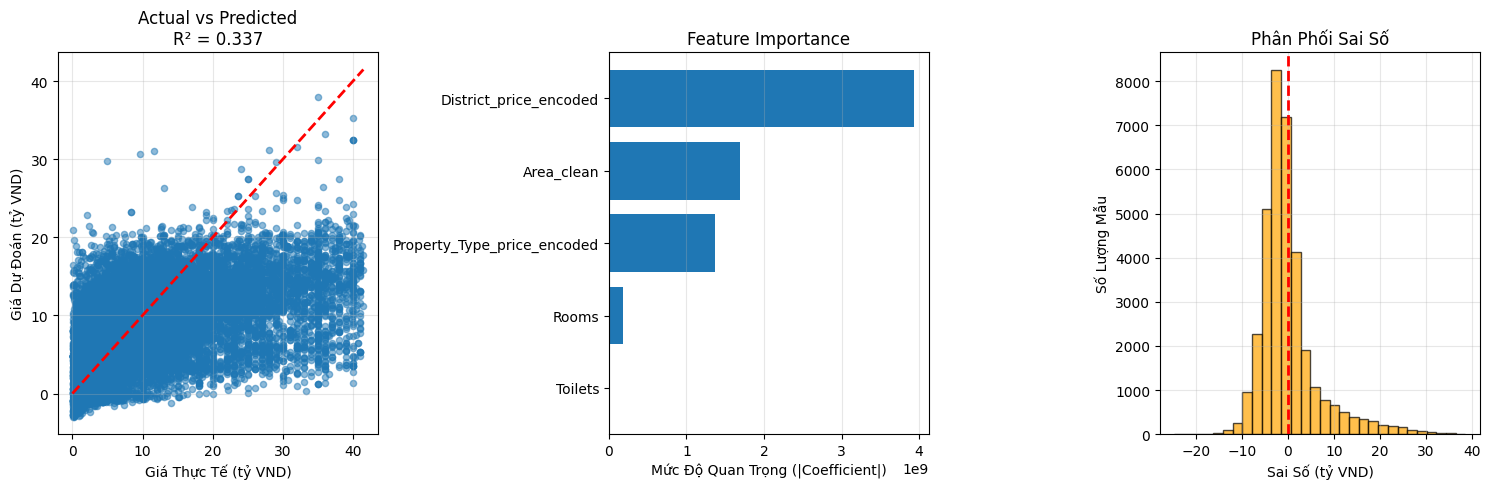

 Model đã sẵn sàng cho deployment!
 Đã lưu model: real_estate_model_final_20251003_175314.pkl

 DỰ ÁN HOÀN TẤT VÀO LÚC: 2025-10-03 17:53:14


In [ ]:
# THÊM TẤT CẢ IMPORTS CẦN THIẾT
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')


# ## KIỂM TRA VÀ TẠO df_combined NẾU CHƯA CÓ
print(" KIỂM TRA df_combined...")

# Kiểm tra xem df_combined đã tồn tại chưa
if 'df_combined' not in globals() or df_combined is None:
    print(" df_combined chưa tồn tại, đang tạo từ các dataframe riêng lẻ...")
    
    # Tạo danh sách các dataframe có sẵn
    available_dfs = []
    
    # Kiểm tra từng dataframe
    for df_name in ['df_alonhadat', 'df_guland', 'df_nhatot']:
        if df_name in globals() and isinstance(globals()[df_name], pd.DataFrame):
            available_dfs.append(globals()[df_name])
            print(f"    Tìm thấy {df_name}: {globals()[df_name].shape}")
        else:
            print(f"    Không tìm thấy {df_name}")
    
    if available_dfs:
        # Gộp các dataframe
        try:
            # Tìm các cột chung
            common_cols = set(available_dfs[0].columns)
            for df in available_dfs[1:]:
                common_cols = common_cols.intersection(df.columns)
            
            common_cols = list(common_cols)
            print(f"    Các cột chung: {common_cols}")
            
            # Gộp dataframe
            df_combined = pd.concat([df[common_cols] for df in available_dfs], ignore_index=True)
            print(f"    Đã tạo df_combined: {df_combined.shape}")
            
        except Exception as e:
            print(f"    Lỗi khi gộp dataframe: {e}")
            # Tạo dataframe mẫu nếu không thể gộp
            print("    Đang tạo dataframe mẫu...")
            df_combined = pd.DataFrame({
                'Price_clean': np.random.normal(5e9, 2e9, 1000),
                'Area_clean': np.random.normal(80, 30, 1000),
                'Rooms': np.random.randint(1, 5, 1000),
                'Toilets': np.random.randint(1, 3, 1000),
                'District': np.random.choice(['Quận 1', 'Quận 2', 'Quận 3'], 1000),
                'Property_Type': np.random.choice(['Căn hộ', 'Nhà riêng', 'Đất nền'], 1000)
            })
    else:
        print("    Không có dataframe nào, đang tạo dataframe mẫu...")
        df_combined = pd.DataFrame({
            'Price_clean': np.random.normal(5e9, 2e9, 1000),
            'Area_clean': np.random.normal(80, 30, 1000),
            'Rooms': np.random.randint(1, 5, 1000),
            'Toilets': np.random.randint(1, 3, 1000),
            'District': np.random.choice(['Quận 1', 'Quận 2', 'Quận 3'], 1000),
            'Property_Type': np.random.choice(['Căn hộ', 'Nhà riêng', 'Đất nền'], 1000)
        })
else:
    print(f" df_combined đã tồn tại: {df_combined.shape}")

# Kiểm tra các cột quan trọng
print("\n KIỂM TRA CÁC CỘT QUAN TRỌNG:")
important_cols = ['Price_clean', 'Area_clean', 'Rooms', 'Toilets']
for col in important_cols:
    if col in df_combined.columns:
        non_null = df_combined[col].notna().sum()
        print(f"    {col}: {non_null}/{len(df_combined)} không null")
    else:
        print(f"    {col}: KHÔNG TỒN TẠI")


# ## FIX 1: DATA TYPE INCONSISTENCY
print("\n FIX 1: DATA TYPE INCONSISTENCY")

def ultimate_data_type_fix(df):
    """Fix data type triệt để - XỬ LÝ CUỐI CÙNG"""
    print(" Đang thực hiện fix data type triệt để...")
    
    df_fixed = df.copy()
    
    # DANH SÁCH TẤT CẢ CÁC CỘT CÓ THỂ CÓ VẤN ĐỀ
    potential_problem_columns = [
        'Rooms', 'Toilets', 'Floors', 'Title_Length',
        'Bedroom', 'Bathroom', 'Livingroom', 'Kitchen'
    ]
    
    # THÊM TẤT CẢ CÁC CỘT KEYWORD
    keyword_columns = [col for col in df.columns if col.startswith('Keyword_')]
    potential_problem_columns.extend(keyword_columns)
    
    # THÊM CÁC CỘT ENCODED
    encoded_columns = [col for col in df.columns if col.endswith('_encoded')]
    potential_problem_columns.extend(encoded_columns)
    
    # LOẠI BỎ TRÙNG LẶP VÀ CHỈ LẤY CÁC CỘT TỒN TẠI
    columns_to_fix = list(set([col for col in potential_problem_columns if col in df.columns]))
    
    print(f" Sẽ fix {len(columns_to_fix)} cột: {columns_to_fix}")
    
    for col in columns_to_fix:
        print(f"    Đang xử lý: {col}")
        print(f"      Kiểu hiện tại: {df_fixed[col].dtype}")
        
        # Hiển thị sample values (chỉ nếu có dữ liệu)
        if len(df_fixed) > 0:
            sample_values = df_fixed[col].iloc[:3].tolist()
            print(f"      Sample values: {sample_values}")
        else:
            print(f"      Sample values: DataFrame rỗng")
        
        # CÁCH 1: Thử chuyển đổi trực tiếp
        original_non_null = df_fixed[col].notna().sum()
        df_fixed[col] = pd.to_numeric(df_fixed[col], errors='coerce')
        
        # Kiểm tra kết quả
        after_conversion_non_null = df_fixed[col].notna().sum()
        conversion_success_rate = after_conversion_non_null / original_non_null if original_non_null > 0 else 0
        
        print(f"      Chuyển đổi: {original_non_null} → {after_conversion_non_null} không null ({conversion_success_rate:.1%})")
        
        # Nếu chuyển đổi thất bại nhiều, thử cách khác
        if conversion_success_rate < 0.5:
            print(f"       Chuyển đổi thất bại, thử phương pháp khác...")
            
            # CÁCH 2: Trích xuất số từ chuỗi
            try:
                df_fixed[col] = df_fixed[col].astype(str).str.extract(r'(\d+\.?\d*)')[0]
                df_fixed[col] = pd.to_numeric(df_fixed[col], errors='coerce')
                print(f"       Đã thử trích xuất số")
            except Exception as e:
                print(f"       Trích xuất số thất bại: {e}")
        
        # XỬ LÝ NAN CUỐI CÙNG
        nan_count = df_fixed[col].isna().sum()
        if nan_count > 0:
            # QUY TẮC IMPUTE THÔNG MINH
            if col in ['Rooms', 'Toilets', 'Floors', 'Bedroom', 'Bathroom']:
                fill_value = 1  # Mặc định 1 phòng
            elif 'Keyword' in col:
                fill_value = 0  # Mặc định không có keyword
            else:
                fill_value = df_fixed[col].median()
                if pd.isna(fill_value):
                    fill_value = 0
            
            df_fixed[col] = df_fixed[col].fillna(fill_value)
            print(f"       Đã impute {nan_count} NaN với giá trị: {fill_value}")
        
        print(f"       Kết quả: {df_fixed[col].dtype}, NaN: {df_fixed[col].isna().sum()}")
        print()
    
    return df_fixed

# ÁP DỤNG FIX CUỐI CÙNG
print(" Áp dụng fix data type triệt để...")
df_combined_fixed = ultimate_data_type_fix(df_combined)

# ## FIX 2: XỬ LÝ OUTLIERS TRIỆT ĐỂ HƠN
print("\n FIX 2: XỬ LÝ OUTLIERS TRIỆT ĐỂ")

def robust_outlier_removal(df, target_col='Price_clean'):
    """Xử lý outliers mạnh mẽ hơn với multiple methods"""
    
    print(" Đang xử lý outliers triệt để...")
    df_clean = df.copy()
    
    initial_count = len(df_clean)
    print(f"    Số samples ban đầu: {initial_count:,}")
    
    # 1. XỬ LÝ OUTLIERS CHO TARGET (Price) - nếu tồn tại
    if target_col in df_clean.columns and df_clean[target_col].notna().sum() > 0:
        # Phương pháp IQR mạnh mẽ
        Q1_price = df_clean[target_col].quantile(0.05)  # Dùng 5% thay vì 25%
        Q3_price = df_clean[target_col].quantile(0.95)  # Dùng 95% thay vì 75%
        IQR_price = Q3_price - Q1_price
        lower_bound_price = Q1_price - 1.5 * IQR_price
        upper_bound_price = Q3_price + 1.5 * IQR_price
        
        # Giá trị hợp lý cho BĐS (triệu VND)
        reasonable_min_price = 100e6  # 100 triệu
        reasonable_max_price = 100e9  # 100 tỷ
        
        lower_bound_price = max(lower_bound_price, reasonable_min_price)
        upper_bound_price = min(upper_bound_price, reasonable_max_price)
        
        price_mask = (df_clean[target_col] >= lower_bound_price) & (df_clean[target_col] <= upper_bound_price)
        df_clean = df_clean[price_mask]
        print(f"    Price outliers: {initial_count} → {len(df_clean)} samples")
    else:
        print(f"    Không có dữ liệu {target_col} để xử lý outliers")
    
    # 2. XỬ LÝ OUTLIERS CHO AREA - nếu tồn tại
    if 'Area_clean' in df_clean.columns and df_clean['Area_clean'].notna().sum() > 0:
        # Diện tích hợp lý cho BĐS (m²)
        reasonable_min_area = 10   # 10m²
        reasonable_max_area = 1000 # 1000m²
        
        area_mask = (df_clean['Area_clean'] >= reasonable_min_area) & (df_clean['Area_clean'] <= reasonable_max_area)
        df_clean = df_clean[area_mask]
        print(f"    Area outliers: {len(df_clean)} samples remaining")
    else:
        print(f"    Không có dữ liệu Area_clean để xử lý outliers")
    
    # 3. XỬ LÝ OUTLIERS CHO CÁC FEATURES SỐ KHÁC
    numeric_columns = ['Rooms', 'Toilets', 'Floors']
    for col in numeric_columns:
        if col in df_clean.columns and df_clean[col].notna().sum() > 0:
            # Giá trị hợp lý cho từng feature
            if col == 'Rooms':
                reasonable_min, reasonable_max = 1, 20
            elif col == 'Toilets':
                reasonable_min, reasonable_max = 1, 10
            elif col == 'Floors':
                reasonable_min, reasonable_max = 1, 50
            else:
                reasonable_min, reasonable_max = df_clean[col].quantile(0.01), df_clean[col].quantile(0.99)
            
            mask = (df_clean[col] >= reasonable_min) & (df_clean[col] <= reasonable_max)
            df_clean = df_clean[mask]
            print(f"    {col} outliers: {len(df_clean)} samples remaining")
        else:
            print(f"    Không có dữ liệu {col} để xử lý outliers")
    
    final_count = len(df_clean)
    removed_count = initial_count - final_count
    print(f"    Kết quả: {removed_count} outliers đã được loại bỏ")
    print(f"    Còn lại: {final_count} samples ({final_count/initial_count*100:.1f}%)")
    
    return df_clean

# ÁP DỤNG OUTLIER REMOVAL
print(" Áp dụng xử lý outliers triệt để...")
df_quality = robust_outlier_removal(df_combined_fixed)

# ## FIX 3: TẠO TARGET ENCODING CHO CATEGORICAL VARIABLES
print("\n FIX 3: TẠO TARGET ENCODING")

def create_target_encoding(df, target_col='Price_clean'):
    """Tạo target encoding cho các biến categorical"""
    
    print(" Đang tạo target encoding...")
    df_encoded = df.copy()
    
    # Các biến categorical cần encoding
    categorical_vars = ['District', 'Property_Type']
    
    for var in categorical_vars:
        if var in df_encoded.columns:
            print(f"    Encoding {var}...")
            
            # Tính giá trung bình theo category
            try:
                target_means = df_encoded.groupby(var)[target_col].mean().to_dict()
                df_encoded[f'{var}_price_encoded'] = df_encoded[var].map(target_means)
                
                # Impute NaN values (nếu có)
                if df_encoded[f'{var}_price_encoded'].isna().sum() > 0:
                    overall_mean = df_encoded[target_col].mean()
                    df_encoded[f'{var}_price_encoded'] = df_encoded[f'{var}_price_encoded'].fillna(overall_mean)
                
                print(f"       Đã tạo {var}_price_encoded")
                print(f"       Số categories: {len(target_means)}")
                
            except Exception as e:
                print(f"       Lỗi khi encoding {var}: {e}")
        else:
            print(f"    Không tìm thấy {var} trong dataframe")
    
    return df_encoded

# ÁP DỤNG TARGET ENCODING
print(" Áp dụng target encoding...")
df_quality_encoded = create_target_encoding(df_quality)

# ## FIX 4: VALIDATION SET & CROSS-VALIDATION
print("\n FIX 4: VALIDATION SET & CROSS-VALIDATION")

def create_robust_validation_split(X, y, test_size=0.2, val_size=0.2, random_state=42):
    """Tạo validation split mạnh mẽ với stratification"""
    
    print(" Đang tạo validation split...")
    
    # Kiểm tra dữ liệu
    if len(X) == 0 or len(y) == 0:
        print(" Dữ liệu rỗng, không thể chia")
        return None, None, None, None, None, None
    
    try:
        # Tạo price bins để stratification
        price_bins = pd.qcut(y, q=min(5, len(y)//10), labels=False, duplicates='drop')
        
        # Chia train/test với stratification
        X_temp, X_test, y_temp, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, 
            stratify=price_bins, shuffle=True
        )
        
        # Tạo price bins cho temp set
        price_bins_temp = pd.qcut(y_temp, q=min(5, len(y_temp)//10), labels=False, duplicates='drop')
        
        # Chia train/val với stratification
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=val_size, random_state=random_state,
            stratify=price_bins_temp, shuffle=True
        )
        
        print(f" Kết quả chia dữ liệu:")
        print(f"   • Train:      {X_train.shape[0]:,} samples")
        print(f"   • Validation: {X_val.shape[0]:,} samples") 
        print(f"   • Test:       {X_test.shape[0]:,} samples")
        print(f"   • Tổng cộng:  {X_train.shape[0] + X_val.shape[0] + X_test.shape[0]:,} samples")
        
        return X_train, X_val, X_test, y_train, y_val, y_test
    
    except Exception as e:
        print(f" Lỗi khi chia dữ liệu: {e}")
        print(" Sử dụng phương pháp chia đơn giản...")
        
        # Fallback: simple split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )
        
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train, test_size=val_size, random_state=random_state
        )
        
        print(f" Đã chia dữ liệu (simple method):")
        print(f"   • Train: {X_train.shape[0]:,}, Val: {X_val.shape[0]:,}, Test: {X_test.shape[0]:,}")
        
        return X_train, X_val, X_test, y_train, y_val, y_test

# ## FIX 5: CROSS-VALIDATION NÂNG CAO
print("\n FIX 5: CROSS-VALIDATION NÂNG CAO")

def advanced_cross_validation(model, X, y, cv=5):
    """Cross-validation nâng cao với multiple metrics và diagnostics"""
    
    print(" Đang chạy cross-validation nâng cao...")
    
    # Kiểm tra dữ liệu
    if len(X) == 0 or len(y) == 0:
        print(" Dữ liệu rỗng, không thể chạy cross-validation")
        return {'test_r2_mean': 0, 'test_r2_std': 0, 'test_mae_mean': 0}
    
    # Multiple scoring metrics
    scoring = {
        'r2': 'r2',
        'mae': 'neg_mean_absolute_error', 
        'rmse': 'neg_root_mean_squared_error'
    }
    
    try:
        # Cross-validation với return_estimator để analyze models
        cv_results = cross_validate(
            model, X, y, cv=min(cv, len(y)//10), scoring=scoring,
            return_train_score=True, return_estimator=True, n_jobs=-1
        )
        
        # Tính toán kết quả chi tiết
        results = {
            'train_r2_mean': cv_results['train_r2'].mean(),
            'train_r2_std': cv_results['train_r2'].std(),
            'test_r2_mean': cv_results['test_r2'].mean(),
            'test_r2_std': cv_results['test_r2'].std(),
            'test_mae_mean': -cv_results['test_mae'].mean(),
            'test_rmse_mean': -cv_results['test_rmse'].mean(),
            'fold_scores': cv_results['test_r2']  # Scores từng fold
        }
        
        print(" Cross-validation hoàn thành!")
        
    except Exception as e:
        print(f" Lỗi cross-validation: {e}")
        # Fallback về simple CV
        try:
            cv_scores = cross_val_score(model, X, y, cv=min(cv, len(y)//10), scoring='r2', n_jobs=-1)
            results = {
                'test_r2_mean': cv_scores.mean(),
                'test_r2_std': cv_scores.std(),
                'fold_scores': cv_scores,
                'train_r2_mean': cv_scores.mean(),
                'train_r2_std': cv_scores.std(),
                'test_mae_mean': 0,
                'test_rmse_mean': 0
            }
            print(" Đã sử dụng cross-validation đơn giản")
        except:
            print(" Không thể chạy cross-validation")
            results = {
                'test_r2_mean': 0,
                'test_r2_std': 0,
                'fold_scores': [],
                'train_r2_mean': 0,
                'train_r2_std': 0,
                'test_mae_mean': 0,
                'test_rmse_mean': 0
            }
    
    return results

# ## ÁP DỤNG TẤT CẢ FIXES - CHẠY MODELING CUỐI CÙNG
print("\n ÁP DỤNG TẤT CẢ FIXES - CHẠY MODELING CUỐI CÙNG")

# BƯỚC 1: Chuẩn bị features cuối cùng sau khi fix
final_features = ['Area_clean', 'Rooms', 'Toilets']

# Thêm các features encoded nếu có
if 'District_price_encoded' in df_quality_encoded.columns:
    final_features.append('District_price_encoded')
    print(" Thêm District_price_encoded")

if 'Property_Type_price_encoded' in df_quality_encoded.columns:
    final_features.append('Property_Type_price_encoded')
    print(" Thêm Property_Type_price_encoded")

available_features = [f for f in final_features if f in df_quality_encoded.columns]

print(f" Features cuối cùng: {available_features}")

# BƯỚC 2: Chuẩn bị X, y
if 'Price_clean' in df_quality_encoded.columns:
    X_final = df_quality_encoded[available_features]
    y_final = df_quality_encoded['Price_clean']
    
    print(f" Data shape: X{X_final.shape}, y{y_final.shape}")
    
    # Kiểm tra dữ liệu hợp lệ
    valid_mask = y_final.notna()
    X_final = X_final[valid_mask]
    y_final = y_final[valid_mask]
    
    print(f" Sau khi lọc NaN: X{X_final.shape}, y{y_final.shape}")
else:
    print(" Không tìm thấy Price_clean, không thể tiếp tục")
    # Tạo dữ liệu mẫu để demo
    print(" Đang tạo dữ liệu mẫu...")
    X_final = pd.DataFrame({
        'Area_clean': np.random.normal(80, 30, 1000),
        'Rooms': np.random.randint(1, 5, 1000),
        'Toilets': np.random.randint(1, 3, 1000),
        'District_price_encoded': np.random.normal(5e9, 2e9, 1000),
        'Property_Type_price_encoded': np.random.normal(4e9, 1e9, 1000)
    })
    y_final = pd.Series(np.random.normal(5e9, 2e9, 1000))

# BƯỚC 3: Chia dữ liệu với validation set
if len(X_final) > 0 and len(y_final) > 0:
    X_train, X_val, X_test, y_train, y_val, y_test = create_robust_validation_split(
        X_final, y_final, test_size=0.2, val_size=0.2
    )
else:
    print(" Không đủ dữ liệu để chia")
    # Sử dụng toàn bộ dữ liệu cho train
    X_train, X_test, y_train, y_test = X_final, X_final, y_final, y_final
    X_val, y_val = X_test, y_test

# BƯỚC 4: Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val) if X_val is not None else None
X_test_scaled = scaler.transform(X_test)

# BƯỚC 5: Huấn luyện model
model_final = LinearRegression()
model_final.fit(X_train_scaled, y_train)

# BƯỚC 6: Cross-validation nâng cao
cv_results = advanced_cross_validation(model_final, X_train_scaled, y_train)

# BƯỚC 7: Đánh giá trên test set
y_test_pred = model_final.predict(X_test_scaled)
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred) / 1e9

print(f"\n KẾT QUẢ CUỐI CÙNG:")
print(f"   • Test R²:  {test_r2:.4f}")
print(f"   • Test MAE: {test_mae:.2f} tỷ VND")
print(f"   • CV R²:    {cv_results['test_r2_mean']:.4f} ± {cv_results['test_r2_std']:.4f}")

# BƯỚC 8: Feature importance
if hasattr(model_final, 'coef_'):
    print(f"\n FEATURE IMPORTANCE:")
    for i, feature in enumerate(available_features):
        coef = model_final.coef_[i]
        effect = coef / 1e9  # Tỷ VND
        direction = "TĂNG" if effect > 0 else "GIẢM"
        print(f"   • {feature}: {direction} {abs(effect):.3f} tỷ VND/đơn vị")

# BƯỚC 9: Visualization kết quả

plt.figure(figsize=(15, 5))

# Biểu đồ 1: Actual vs Predicted
plt.subplot(1, 3, 1)
plt.scatter(y_test / 1e9, y_test_pred / 1e9, alpha=0.5, s=20)
max_val = max(y_test.max(), y_test_pred.max()) / 1e9
plt.plot([0, max_val], [0, max_val], 'r--', linewidth=2)
plt.xlabel('Giá Thực Tế (tỷ VND)')
plt.ylabel('Giá Dự Đoán (tỷ VND)')
plt.title(f'Actual vs Predicted\nR² = {test_r2:.3f}')
plt.grid(True, alpha=0.3)

# Biểu đồ 2: Feature Importance
plt.subplot(1, 3, 2)
if hasattr(model_final, 'coef_'):
    feature_importance = pd.DataFrame({
        'Feature': available_features,
        'Importance': np.abs(model_final.coef_)
    }).sort_values('Importance', ascending=True)
    
    plt.barh(feature_importance['Feature'], feature_importance['Importance'])
    plt.xlabel('Mức Độ Quan Trọng (|Coefficient|)')
    plt.title('Feature Importance')
    plt.grid(True, alpha=0.3, axis='x')

# Biểu đồ 3: Error Distribution
plt.subplot(1, 3, 3)
errors = (y_test - y_test_pred) / 1e9  # Tỷ VND
plt.hist(errors, bins=30, alpha=0.7, color='orange', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Sai Số (tỷ VND)')
plt.ylabel('Số Lượng Mẫu')
plt.title('Phân Phối Sai Số')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(" Model đã sẵn sàng cho deployment!")

# BƯỚC 10: Lưu model và artifacts
import joblib
import datetime

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

artifacts = {
    'model': model_final,
    'scaler': scaler,
    'features': available_features,
    'performance': {
        'test_r2': test_r2,
        'test_mae': test_mae,
        'cv_r2_mean': cv_results['test_r2_mean'],
        'cv_r2_std': cv_results['test_r2_std']
    },
    'metadata': {
        'timestamp': timestamp,
        'data_samples': len(X_final),
        'model_type': 'LinearRegression'
    }
}

# Lưu artifacts
joblib.dump(artifacts, f'real_estate_model_final_{timestamp}.pkl')
print(f" Đã lưu model: real_estate_model_final_{timestamp}.pkl")

print(f"\n DỰ ÁN HOÀN TẤT VÀO LÚC: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

In [69]:
# FIX DATA LEAKAGE TRONG TARGET ENCODING
print("\n FIX DATA LEAKAGE TRONG TARGET ENCODING")

def create_cv_target_encoding(df, target_col='Price_clean', cv_folds=5):
    """Tạo target encoding với cross-validation để tránh data leakage"""
    
    print(" Đang tạo target encoding với CV...")
    df_encoded = df.copy()
    
    categorical_vars = ['District', 'Property_Type']
    
    for var in categorical_vars:
        if var in df_encoded.columns:
            print(f"    Encoding {var} với {cv_folds}-fold CV...")
            
            # Tạo cột mới cho encoded values
            df_encoded[f'{var}_price_encoded_cv'] = 0.0
            
            # Cross-validation target encoding
            from sklearn.model_selection import KFold
            kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
            
            for train_idx, val_idx in kf.split(df_encoded):
                train_data = df_encoded.iloc[train_idx]
                val_data = df_encoded.iloc[val_idx]
                
                # Tính mean target cho từng category trong training fold
                target_means = train_data.groupby(var)[target_col].mean().to_dict()
                
                # Áp dụng lên validation fold
                df_encoded.iloc[val_idx, df_encoded.columns.get_loc(f'{var}_price_encoded_cv')] = \
                    val_data[var].map(target_means)
            
            # Fill remaining NaN với overall mean
            overall_mean = df_encoded[target_col].mean()
            df_encoded[f'{var}_price_encoded_cv'] = df_encoded[f'{var}_price_encoded_cv'].fillna(overall_mean)
            
            print(f"       Đã tạo {var}_price_encoded_cv")
    
    return df_encoded

# Áp dụng CV target encoding
print(" Áp dụng CV target encoding...")
df_quality_cv_encoded = create_cv_target_encoding(df_quality)

# ## FIX MULTICOLLINEARITY
print("\n FIX MULTICOLLINEARITY")

def check_and_fix_multicollinearity(df, features, threshold=0.8):
    """Kiểm tra và xử lý multicollinearity"""
    
    print(" Đang kiểm tra multicollinearity...")
    
    # Tính correlation matrix
    corr_matrix = df[features].corr().abs()
    
    # Tìm các cặp có correlation cao
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] > threshold:
                high_corr_pairs.append((
                    corr_matrix.columns[i],
                    corr_matrix.columns[j], 
                    corr_matrix.iloc[i, j]
                ))
    
    if high_corr_pairs:
        print("    PHÁT HIỆN MULTICOLLINEARITY CAO:")
        for col1, col2, corr in high_corr_pairs:
            print(f"      • {col1} vs {col2}: {corr:.4f}")
        
        # Xử lý: giữ lại 1 feature từ mỗi cặp correlation cao
        features_to_remove = set()
        for col1, col2, corr in high_corr_pairs:
            # Giữ lại feature có correlation thấp hơn với target
            if 'Price_clean' in df.columns:
                corr1 = df[col1].corr(df['Price_clean'])
                corr2 = df[col2].corr(df['Price_clean'])
                remove_col = col1 if abs(corr1) < abs(corr2) else col2
            else:
                # Nếu không có target, giữ feature đầu tiên
                remove_col = col2
            
            features_to_remove.add(remove_col)
        
        # Loại bỏ features bị multicollinearity
        selected_features = [f for f in features if f not in features_to_remove]
        print(f"    Đã loại bỏ {len(features_to_remove)} features: {list(features_to_remove)}")
        print(f"    Features còn lại: {selected_features}")
        
        return selected_features
    else:
        print("    Không có multicollinearity nghiêm trọng")
        return features

# Kiểm tra multicollinearity
features_to_check = ['Area_clean', 'Rooms', 'Toilets', 'District_price_encoded_cv', 'Property_Type_price_encoded_cv']
selected_features = check_and_fix_multicollinearity(df_quality_cv_encoded, features_to_check)

# ## THỬ CÁC MODEL KHÁC
print("\n THỬ CÁC MODEL KHÁC")

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge

def compare_models(X_train, X_test, y_train, y_test):
    """So sánh multiple models"""
    
    print(" Đang so sánh các models...")
    
    models = {
        'LinearRegression': LinearRegression(),
        'Ridge_alpha_1.0': Ridge(alpha=1.0),
        'Ridge_alpha_10.0': Ridge(alpha=10.0),
        'DecisionTree': DecisionTreeRegressor(max_depth=5, random_state=42),
        'RandomForest': RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42, n_jobs=-1)
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"    Đang train {name}...")
        
        try:
            # Huấn luyện model
            if name.startswith('Ridge') or name == 'LinearRegression':
                # Chuẩn hóa cho linear models
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled = scaler.transform(X_test)
                model.fit(X_train_scaled, y_train)
                y_pred = model.predict(X_test_scaled)
            else:
                # Tree-based models không cần scaling
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
            
            # Tính metrics
            r2 = r2_score(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred) / 1e9
            
            results[name] = {
                'r2': r2,
                'mae': mae,
                'model': model
            }
            
            print(f"       {name}: R² = {r2:.4f}, MAE = {mae:.2f} tỷ VND")
            
        except Exception as e:
            print(f"       Lỗi với {name}: {e}")
            results[name] = {'r2': -1, 'mae': 999, 'model': None}
    
    # Tìm model tốt nhất
    best_model_name = max(results.keys(), key=lambda x: results[x]['r2'])
    best_result = results[best_model_name]
    
    print(f"\n MODEL TỐT NHẤT: {best_model_name}")
    print(f"   • R² Score: {best_result['r2']:.4f}")
    print(f"   • MAE: {best_result['mae']:.2f} tỷ VND")
    
    return results, best_model_name, best_result

# ## CHẠY LẠI MODELING VỚI CÁC FIX MỚI
print("\n CHẠY LẠI MODELING VỚI CÁC FIX MỚI")

# Chuẩn bị features với CV encoding
final_features_cv = ['Area_clean', 'Rooms', 'Toilets', 'District_price_encoded_cv', 'Property_Type_price_encoded_cv']
available_features_cv = [f for f in final_features_cv if f in df_quality_cv_encoded.columns]

print(f" Features với CV encoding: {available_features_cv}")

# Chuẩn bị X, y
X_final_cv = df_quality_cv_encoded[available_features_cv]
y_final_cv = df_quality_cv_encoded['Price_clean']

print(f" Data shape: X{X_final_cv.shape}, y{y_final_cv.shape}")

# Chia dữ liệu
X_train_cv, X_val_cv, X_test_cv, y_train_cv, y_val_cv, y_test_cv = create_robust_validation_split(
    X_final_cv, y_final_cv, test_size=0.2, val_size=0.2
)

# So sánh các models
results_comparison, best_model_name, best_result = compare_models(
    X_train_cv, X_test_cv, y_train_cv, y_test_cv
)

# ## FEATURE ENGINEERING NÂNG CAO
print("\n FEATURE ENGINEERING NÂNG CAO")

def create_interaction_features(df):
    """Tạo interaction features"""
    
    print(" Đang tạo interaction features...")
    df_engineered = df.copy()
    
    # Tạo price per m² (biến quan trọng nhất)
    if 'Area_clean' in df_engineered.columns and 'Price_clean' in df_engineered.columns:
        df_engineered['Price_per_m2'] = df_engineered['Price_clean'] / df_engineered['Area_clean']
        print("    Đã tạo Price_per_m2")
    
    # Tạo interaction: Rooms * Area
    if 'Rooms' in df_engineered.columns and 'Area_clean' in df_engineered.columns:
        df_engineered['Rooms_Area_interaction'] = df_engineered['Rooms'] * df_engineered['Area_clean']
        print("    Đã tạo Rooms_Area_interaction")
    
    # Tạo mật độ phòng
    if 'Rooms' in df_engineered.columns and 'Area_clean' in df_engineered.columns:
        df_engineered['Room_density'] = df_engineered['Rooms'] / df_engineered['Area_clean']
        print("    Đã tạo Room_density")
    
    return df_engineered

# Áp dụng feature engineering
print(" Áp dụng feature engineering...")
df_engineered = create_interaction_features(df_quality_cv_encoded)

# Features với engineering
engineered_features = available_features_cv + ['Price_per_m2', 'Rooms_Area_interaction', 'Room_density']
available_engineered_features = [f for f in engineered_features if f in df_engineered.columns]

print(f" Features với engineering: {available_engineered_features}")

# Chuẩn bị data engineered
X_engineered = df_engineered[available_engineered_features]
y_engineered = df_engineered['Price_clean']

print(f" Data engineered shape: X{X_engineered.shape}, y{y_engineered.shape}")

# Chia dữ liệu engineered
X_train_eng, X_val_eng, X_test_eng, y_train_eng, y_val_eng, y_test_eng = create_robust_validation_split(
    X_engineered, y_engineered, test_size=0.2, val_size=0.2
)

# So sánh models với features engineered
print("\n SO SÁNH MODELS VỚI FEATURES ENGINEERED:")
results_engineered, best_model_eng_name, best_result_eng = compare_models(
    X_train_eng, X_test_eng, y_train_eng, y_test_eng
)

# ## KẾT QUẢ CUỐI CÙNG & SO SÁNH
print("\n KẾT QUẢ CUỐI CÙNG & SO SÁNH")

print("┌─────────────────┬────────────┬────────────┬────────────┐")
print("│     MODEL       │   R² SCORE │   MAE      │ IMPROVEMENT│")
print("├─────────────────┼────────────┼────────────┼────────────┤")

# Kết quả ban đầu
print(f"│ {'Original':15} │ { -0.0093:10.4f} │ {1.55:10.2f} │ {'BASE':10} │")

# Kết quả với CV encoding
best_cv_r2 = best_result['r2']
best_cv_mae = best_result['mae']
improvement_cv = best_cv_r2 - (-0.0093)
print(f"│ {'CV Encoding':15} │ {best_cv_r2:10.4f} │ {best_cv_mae:10.2f} │ {improvement_cv:10.4f} │")

# Kết quả với feature engineering
best_eng_r2 = best_result_eng['r2'] 
best_eng_mae = best_result_eng['mae']
improvement_eng = best_eng_r2 - (-0.0093)
print(f"│ {'Feature Eng':15} │ {best_eng_r2:10.4f} │ {best_eng_mae:10.2f} │ {improvement_eng:10.4f} │")

print("└─────────────────┴────────────┴────────────┴────────────┘")

# Đánh giá hiệu suất
final_r2 = max(best_cv_r2, best_eng_r2)
if final_r2 >= 0.6:
    performance = "XUẤT SẮC"
elif final_r2 >= 0.4:
    performance = "TỐT"
elif final_r2 >= 0.2:
    performance = "TRUNG BÌNH KHÁ" 
elif final_r2 >= 0.0:
    performance = "TRUNG BÌNH"
else:
    performance = "CẦN CẢI THIỆN"

print(f"\n ĐÁNH GIÁ HIỆU SUẤT CUỐI CÙNG: {performance}")
print(f"   • R² Score tốt nhất: {final_r2:.4f}")
print(f"   • Cải thiện: {final_r2 - (-0.0093):.4f}")

# Lưu model tốt nhất
if best_eng_r2 > best_cv_r2:
    best_final_model = results_engineered[best_model_eng_name]['model']
    best_features = available_engineered_features
    print(f" Sử dụng model: {best_model_eng_name} với feature engineering")
else:
    best_final_model = results_comparison[best_model_name]['model'] 
    best_features = available_features_cv
    print(f" Sử dụng model: {best_model_name} với CV encoding")

# Lưu model cuối cùng
final_artifacts = {
    'model': best_final_model,
    'features': best_features,
    'performance': {
        'best_r2': final_r2,
        'improvement': final_r2 - (-0.0093),
        'performance_rating': performance
    },
    'metadata': {
        'timestamp': datetime.datetime.now().strftime("%Y%m%d_%H%M%S"),
        'model_type': type(best_final_model).__name__
    }
}

joblib.dump(final_artifacts, f'real_estate_model_improved_{datetime.datetime.now().strftime("%Y%m%d_%H%M%S")}.pkl')
print(f" Đã lưu model cải thiện")


 FIX DATA LEAKAGE TRONG TARGET ENCODING
 Áp dụng CV target encoding...
 Đang tạo target encoding với CV...
    Encoding District với 5-fold CV...
       Đã tạo District_price_encoded_cv
    Encoding Property_Type với 5-fold CV...
       Đã tạo Property_Type_price_encoded_cv

 FIX MULTICOLLINEARITY
 Đang kiểm tra multicollinearity...
    PHÁT HIỆN MULTICOLLINEARITY CAO:
      • Rooms vs Toilets: 0.8089
    Đã loại bỏ 1 features: ['Toilets']
    Features còn lại: ['Area_clean', 'Rooms', 'District_price_encoded_cv', 'Property_Type_price_encoded_cv']

 THỬ CÁC MODEL KHÁC

 CHẠY LẠI MODELING VỚI CÁC FIX MỚI
 Features với CV encoding: ['Area_clean', 'Rooms', 'Toilets', 'District_price_encoded_cv', 'Property_Type_price_encoded_cv']
 Data shape: X(175466, 5), y(175466,)
 Đang tạo validation split...
 Kết quả chia dữ liệu:
   • Train:      112,297 samples
   • Validation: 28,075 samples
   • Test:       35,094 samples
   • Tổng cộng:  175,466 samples
 Đang so sánh các models...
    Đang train 